(chap2)=

# 3. Linear Models and Probabilistic Programming Languages

With the advent of Probabilistic Programming Languages, modern Bayesian
modeling can be as simple as coding a model and "pressing a button\".
However, effective model building and analysis usually takes more work.
As we progress through this book we will be building many different
types of models but in this chapter we will start with the humble linear
model. Linear models are a broad class of models where the expected
value of a given observation is the linear combination of the associated
predictors. A strong understanding of how to fit and interpret linear
models is a strong foundation for the models that will follow. This will
also help us to consolidate the fundamentals of Bayesian inference
(Chapter [1](chap1)) and exploratory analysis of Bayesian models
(Chapter [2](chap1bis)) and apply them with different PPLs.
This chapter introduces the two PPLs we will use for the majority of
this book, PyMC3, which you have briefly seen, as well as TensorFlow
Probability (TFP). While we are building models in these two PPLs,
focusing on how the same underlying statistical ideas are mapped to
implementation in each PPL. We will first fit an intercept only model,
that is a model with no covariates, and then we will add extra
complexity by adding one or more covariates, and extend to generalized
linear models. By the end of this chapter you will be more comfortable
with linear models, more familiar with many of the steps in a Bayesian
workflow, and more comfortable conducting Bayesian workflows with PyMC3,
TFP and ArviZ.

## 3.1 Comparing Two (or More) Groups

If you are looking for something to compare it is hard to beat penguins.
After all, what is not to like about these cute flightless birds? Our
first question may be "What is the average mass of each penguin
species?\", or may be "How different are those averages?\", or in
statistics parlance "What is the dispersion of the average?\" Luckily
Kristen Gorman also likes studying penguins, so much so that she visited
3 Antarctic islands and collected data about Adelie, Gentoo and
Chinstrap species, which is compiled into the Palmer Penguins
dataset {cite:p}`PalmerPenguins`. The observations consist of physical
characteristics of the penguin mass, flipper length, and sex, as well as
geographic characteristics such as the island they reside on.

We start by loading the data and filtering out any rows where data is
missing in Code Block [penguin_load](penguin_load). This
is called a complete case analysis where, as the name suggests, we only
use the rows where all observations are present. While it is possible to
handle the missing values in another way, either through data
imputation, or imputation during modeling, we will opt to take the
simplest approach for this chapter.

```{code-block} python
:name: penguin_load
:caption: penguin_load

penguins = pd.read_csv("../data/penguins.csv")
# Subset to the columns needed
missing_data = penguins.isnull()[
    ["bill_length_mm", "flipper_length_mm", "sex", "body_mass_g"]
].any(axis=1)
# Drop rows with any missing data
penguins = penguins.loc[~missing_data]
```

In [1]:
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import xarray as xr
import pandas as pd
from scipy import special, stats
import numpy as np

In [2]:
az.style.use("arviz-grayscale")
plt.rcParams['figure.dpi'] = 300

In [3]:
penguins = pd.read_csv("../data/penguins.csv")

# Subset to the columns needed
missing_data = penguins.isnull()[
    ["bill_length_mm", "flipper_length_mm", "sex", "body_mass_g"]
].any(axis=1)

# Drop rows with any missing data
penguins = penguins.loc[~missing_data]

penguins.head()

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
4  Adelie  Torgersen            36.7           19.3              193.0   
5  Adelie  Torgersen            39.3           20.6              190.0   

   body_mass_g     sex  year  
0       3750.0    male  2007  
1       3800.0  female  2007  
2       3250.0  female  2007  
4       3450.0  female  2007  
5       3650.0    male  2007

In [4]:
penguins.shape

(333, 8)

We can then calculate the empirical mean of the mass `body_mass_g` in
Code Block
[penguin_mass_empirical](penguin_mass_empirical) with just
a little bit of code, the results of which are in {numref}`tab:penguin_mass_parameters_point_estimates`

```{code-block} python
:name: penguin_mass_empirical
:caption: penguin_mass_empirical
summary_stats = (penguins.loc[:, ["species", "body_mass_g"]]
                         .groupby("species")
                         .agg(["mean", "std", "count"]))
```

```{list-table} Empirical mean and standard deviation of penguin mass. The count column indicates the observed number of penguins per species.
:name: tab:penguin_mass_parameters_point_estimates
* - **species**
  - **mean (grams)**
  - **std (grams)**
  - **count**
* - **Adelie**
  - 3706
  -  459
  -  146
* - **Chinstrap**
  - 3733
  - 384
  - 68
* - **Gentoo**
  - 5092
  - 501
  - 119
```

In [5]:
summary_stats = (penguins.loc[:, ["species", "body_mass_g"]]
                         .groupby("species")
                         .agg(["mean", "std", "count"]))
summary_stats

body_mass_g                  
                  mean         std count
species                                 
Adelie     3706.164384  458.620135   146
Chinstrap  3733.088235  384.335081    68
Gentoo     5092.436975  501.476154   119

Now we have point estimates for both the mean and the dispersion, but we
do not know the uncertainty of those statistics. One way to get
estimates of uncertainty is by using Bayesian methods. In order to do so
we need to conjecture a relationship of observations to parameters as
example:

```{math}
:label: eq:gaussian_bayes
\overbrace{p(\mu, \sigma \mid Y)}^{Posterior} \propto \overbrace{\mathcal{N}(Y \mid \mu, \sigma)}^{Likelihood}\;  \overbrace{\underbrace{\mathcal{N}(4000, 3000)}_{\mu}
     \underbrace{\mathcal{H}\text{T}(100, 2000)}_{\sigma}}^{Prior}

```

Equation {eq}`eq:gaussian_bayes` is a restatement of Equation
[eq:proportional_bayes](eq:proportional_bayes) where each parameter
is explicitly listed. Since we have no specific reason to choose an
informative prior, we will use wide priors for both $\mu$ and $\sigma$.
In this case, the priors are chosen based on the empirical mean and
standard deviation of the observed data. And lastly instead of
estimating the mass of all species we will first start with the mass of
the Adelie penguin species. A Gaussian is a reasonable choice of
likelihood for penguin mass and biological mass in general, so we will
go with it. Let us translate Equation {eq}`eq:gaussian_bayes` into a
computational model.

```{code-block} python
:name: penguin_mass
:caption: penguin_mass
adelie_mask = (penguins["species"] == "Adelie")
adelie_mass_obs = penguins.loc[adelie_mask, "body_mass_g"].values

with pm.Model() as model_adelie_penguin_mass:
    σ = pm.HalfStudentT("σ", 100, 2000)
    μ = pm.Normal("μ", 4000, 3000)
    mass = pm.Normal("mass", mu=μ, sigma=σ, observed=adelie_mass_obs)

    prior = pm.sample_prior_predictive(samples=5000)
    trace = pm.sample(chains=4)
    inf_data_adelie_penguin_mass = az.from_pymc3(prior=prior, trace=trace)
```

In [6]:
adelie_mask = (penguins["species"] == "Adelie")
adelie_mass_obs = penguins.loc[adelie_mask, "body_mass_g"].values

with pm.Model() as model_adelie_penguin_mass:
    σ = pm.HalfStudentT("σ", 100, 2000)
    μ = pm.Normal("μ", 4000, 3000)
    mass = pm.Normal("mass", mu=μ, sigma=σ, observed=adelie_mass_obs)

    idata_adelie_mass = pm.sample(chains=4)
    idata_adelie_mass.extend(pm.sample_prior_predictive(samples=5000))


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [mass, μ, σ]


Before computing the posterior we are going to check the prior. In
particular we are first checking that sampling from our model is
computationally feasible and that our choice of priors is reasonable
based on our domain knowledge. We plot the samples from the prior in
{numref}`fig:SingleSpecies_Prior_Predictive`. Since we can get a plot at
all we know our model has no "obvious\" computational issues, such as
shape problems or mispecified random variables or likelihoods. From the
prior samples themselves it is evident we are not overly constraining
the possible penguin masses, we may in fact be under constraining the
prior as the prior for the mean of the mass includes negative values.
However, since this is a simple model and we have a decent number of
observations we will just note this aberration and move onto estimating
the posterior distribution.

```{figure} figures/SingleSpecies_Prior_Predictive.png
:name: fig:SingleSpecies_Prior_Predictive
:width: 7.00in
Prior samples generated in Code Block
[penguin_mass](penguin_mass). The distribution estimates
of both the mean and standard deviation for the mass distribution cover
a wide range of possibilities.
```

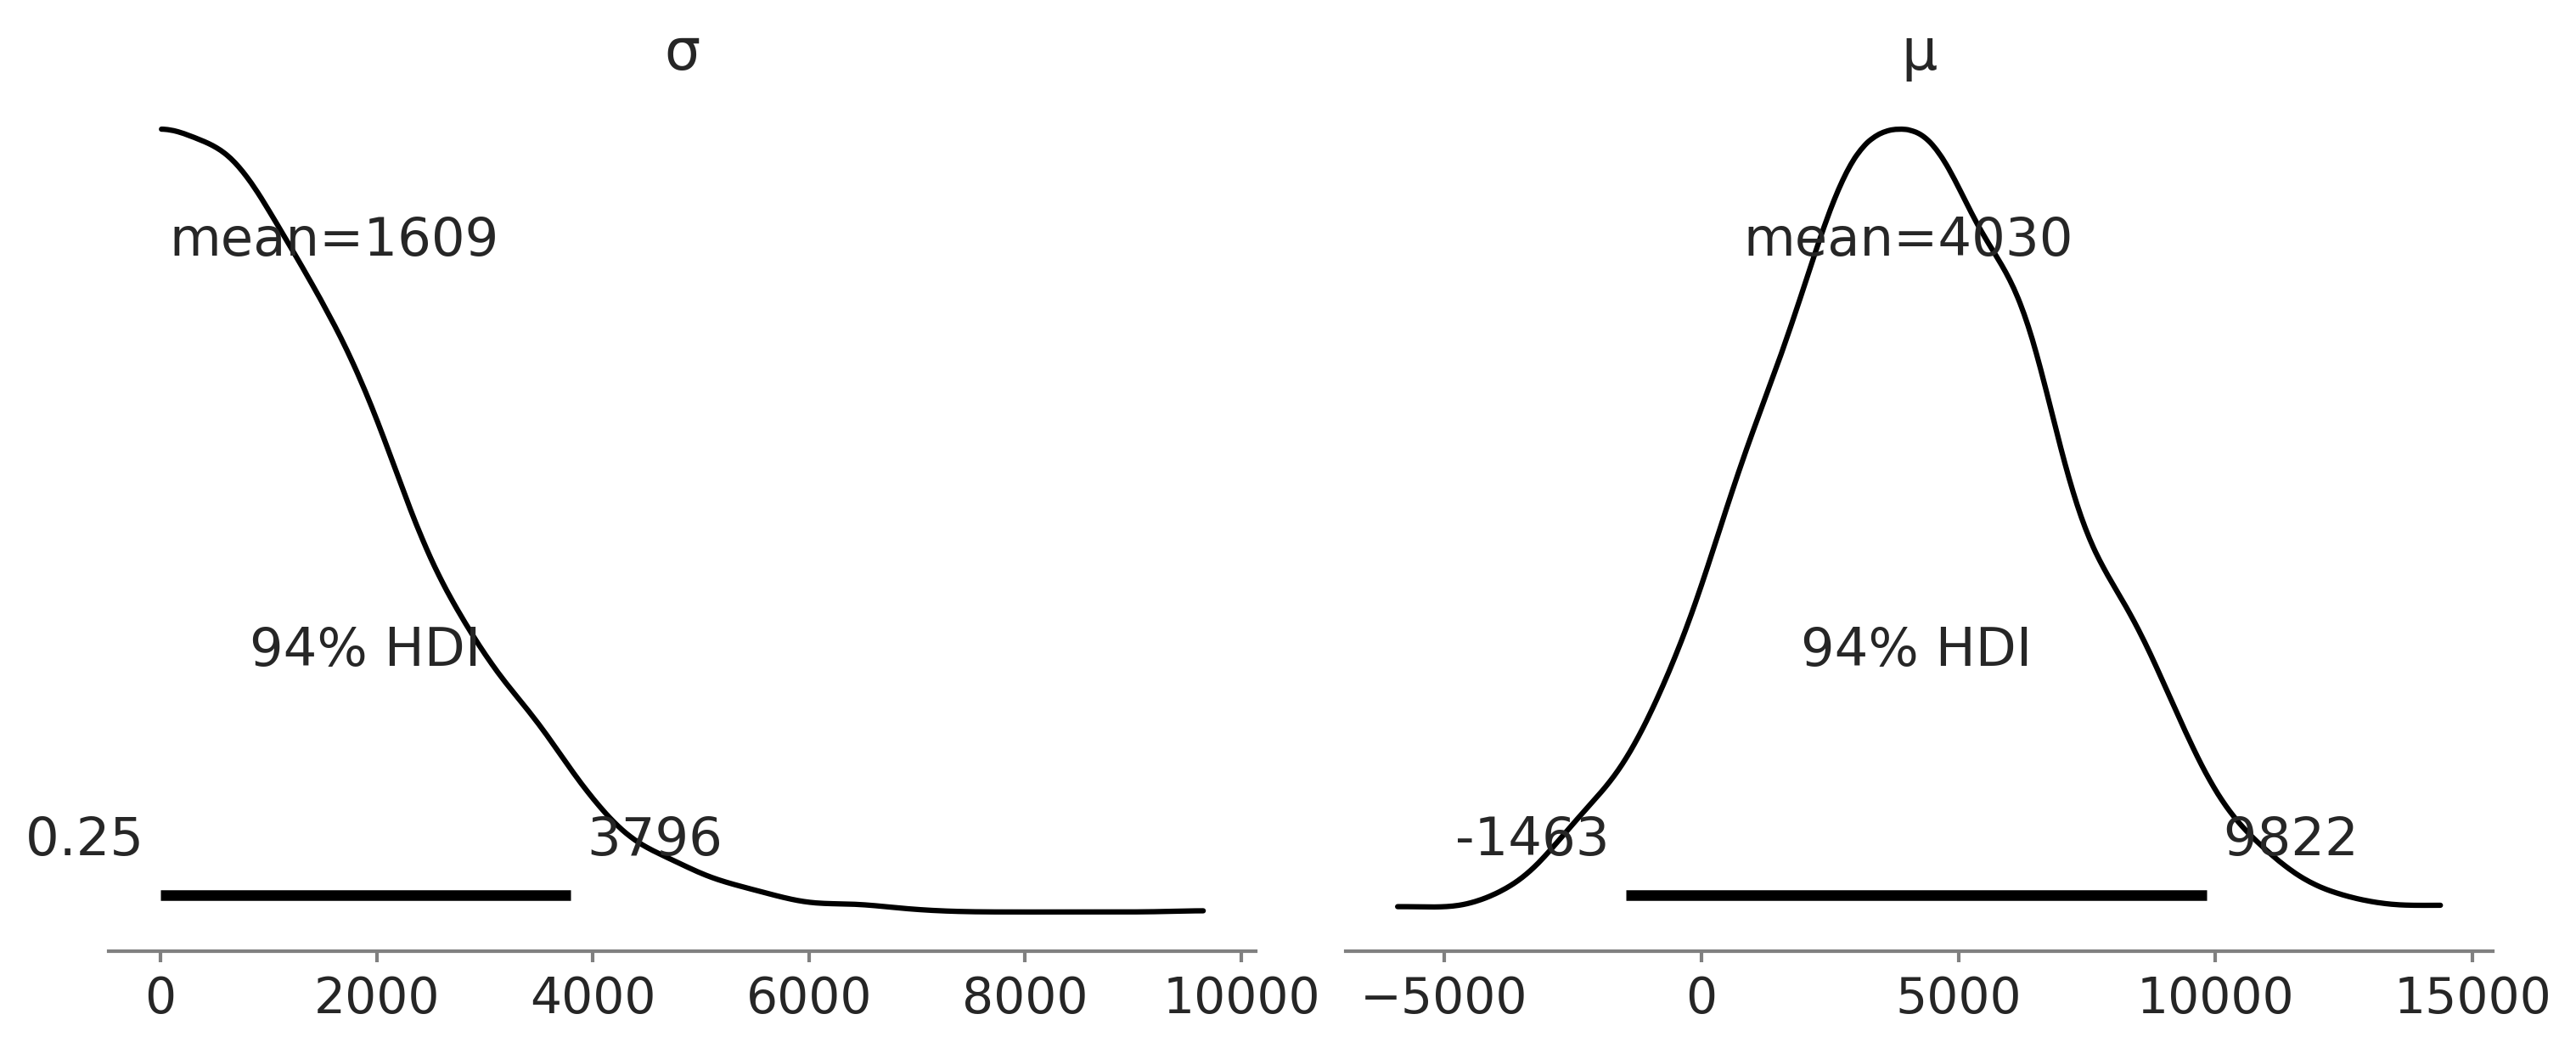

In [7]:
axes = az.plot_posterior(idata_adelie_mass.prior, var_names=["σ", "μ"], figsize=(10, 4))

plt.savefig("img/chp03/single_species_prior_predictive.png")

After sampling from our model, we can create
{numref}`fig:single_penguins_rank_kde_plot` which includes 4 subplots,
the two on the right are the rank plots and the left the KDE of each
parameter, one line for each chain. We also can reference the numerical
diagnostics in {numref}`tab:penguin_mass_parameters_bayesian_estimates` to confirm our
belief that the chains converged. Using the intuition we built in
Chapter [2](chap1bis) we can judge that these fits are
acceptable and we will continue with our analysis.

```{list-table} Bayesian estimates of the mean (μ) and standard deviation (σ) of Adelie penguin mass. Sampling diagnostics also included
:name: tab:penguin_mass_parameters_bayesian_estimates
* -
  - **mean**
  - **sd**
  - **hdi_3%**
  - **hdi_97%**
  - **mcse_mean**
  - **mcse_sd**
  - **ess_bulk**
  - **ess_tail**
  - **r_hat**
* - $\mu$
  - 3707
  - 38
  - 3632
  - 3772
  - 0.6
  - 0.4
  - 3677.0
  - 2754.0
  - 1.0
* - $\sigma$
  - 463
  - 27
  - 401
  - 511
  - 0.5
  - 0.3
  - 3553.0
  - 2226.0
  - 1.0
```

```{figure} figures/SingleSpecies_KDE_RankPlot.png
:name: fig:single_penguins_rank_kde_plot
:width: 7.00in
KDE and rank plot of the posterior of the Bayesian model in Code Block
[penguin_mass](penguin_mass) of Adelie penguin mass. This
plot serves as a visual diagnostic of the sampling to help judge if
there were any issues during sampling across the multiple sampling
chains.
```

In [8]:
az.summary(idata_adelie_mass)

mean      sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
μ  3706.168  33.040  3644.778  3768.978      0.515    0.365    4100.0   
σ   405.902  19.301   370.863   442.123      0.308    0.218    3935.0   

   ess_tail  r_hat  
μ    2648.0    1.0  
σ    3134.0    1.0

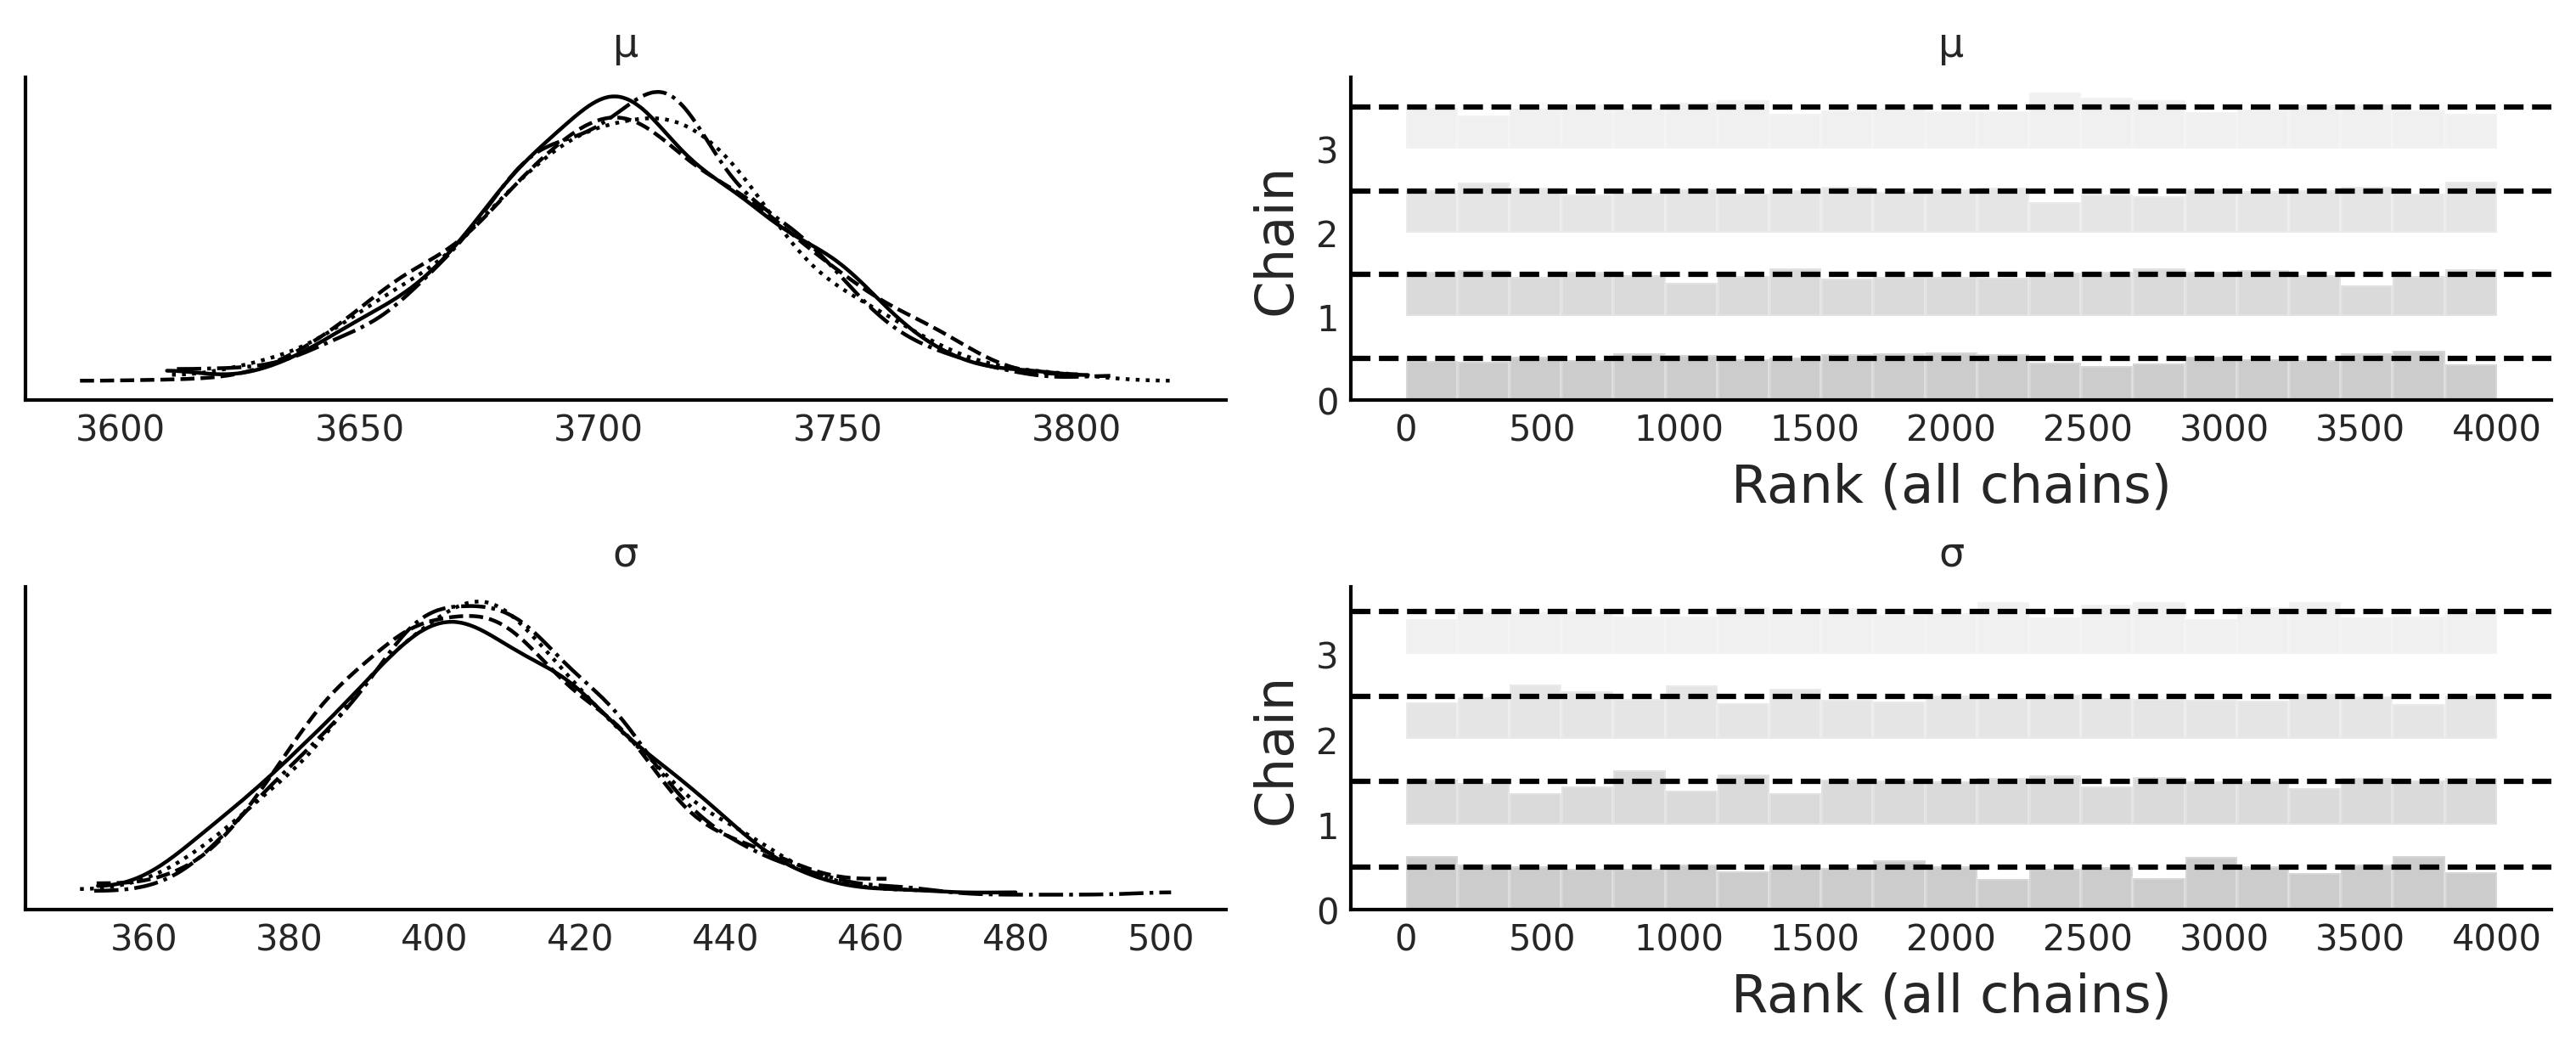

In [9]:
axes = az.plot_trace(idata_adelie_mass, divergences="bottom", kind="rank_bars", figsize=(10, 4))

plt.savefig("img/chp03/single_species_KDE_rankplot.png")

Comfortable with the fit we plot a posterior plot in
{numref}`fig:SingleSpecies_Mass_PosteriorPlot` that combines all the
chains. Compare the point estimates from {numref}`tab:penguin_mass_parameters_point_estimates` of the mean and
standard deviation with our Bayesian estimates as shown in
{numref}`fig:SingleSpecies_Mass_PosteriorPlot`.

```{figure} figures/SingleSpecies_Mass_PosteriorPlot.png
:name: fig:SingleSpecies_Mass_PosteriorPlot
:width: 7.00in
Posterior plot of the posterior of the Bayesian model in Code Block
[penguin_mass](penguin_mass) of Adelie penguins mass. The
vertical lines are the empirical mean and standard deviation.
```

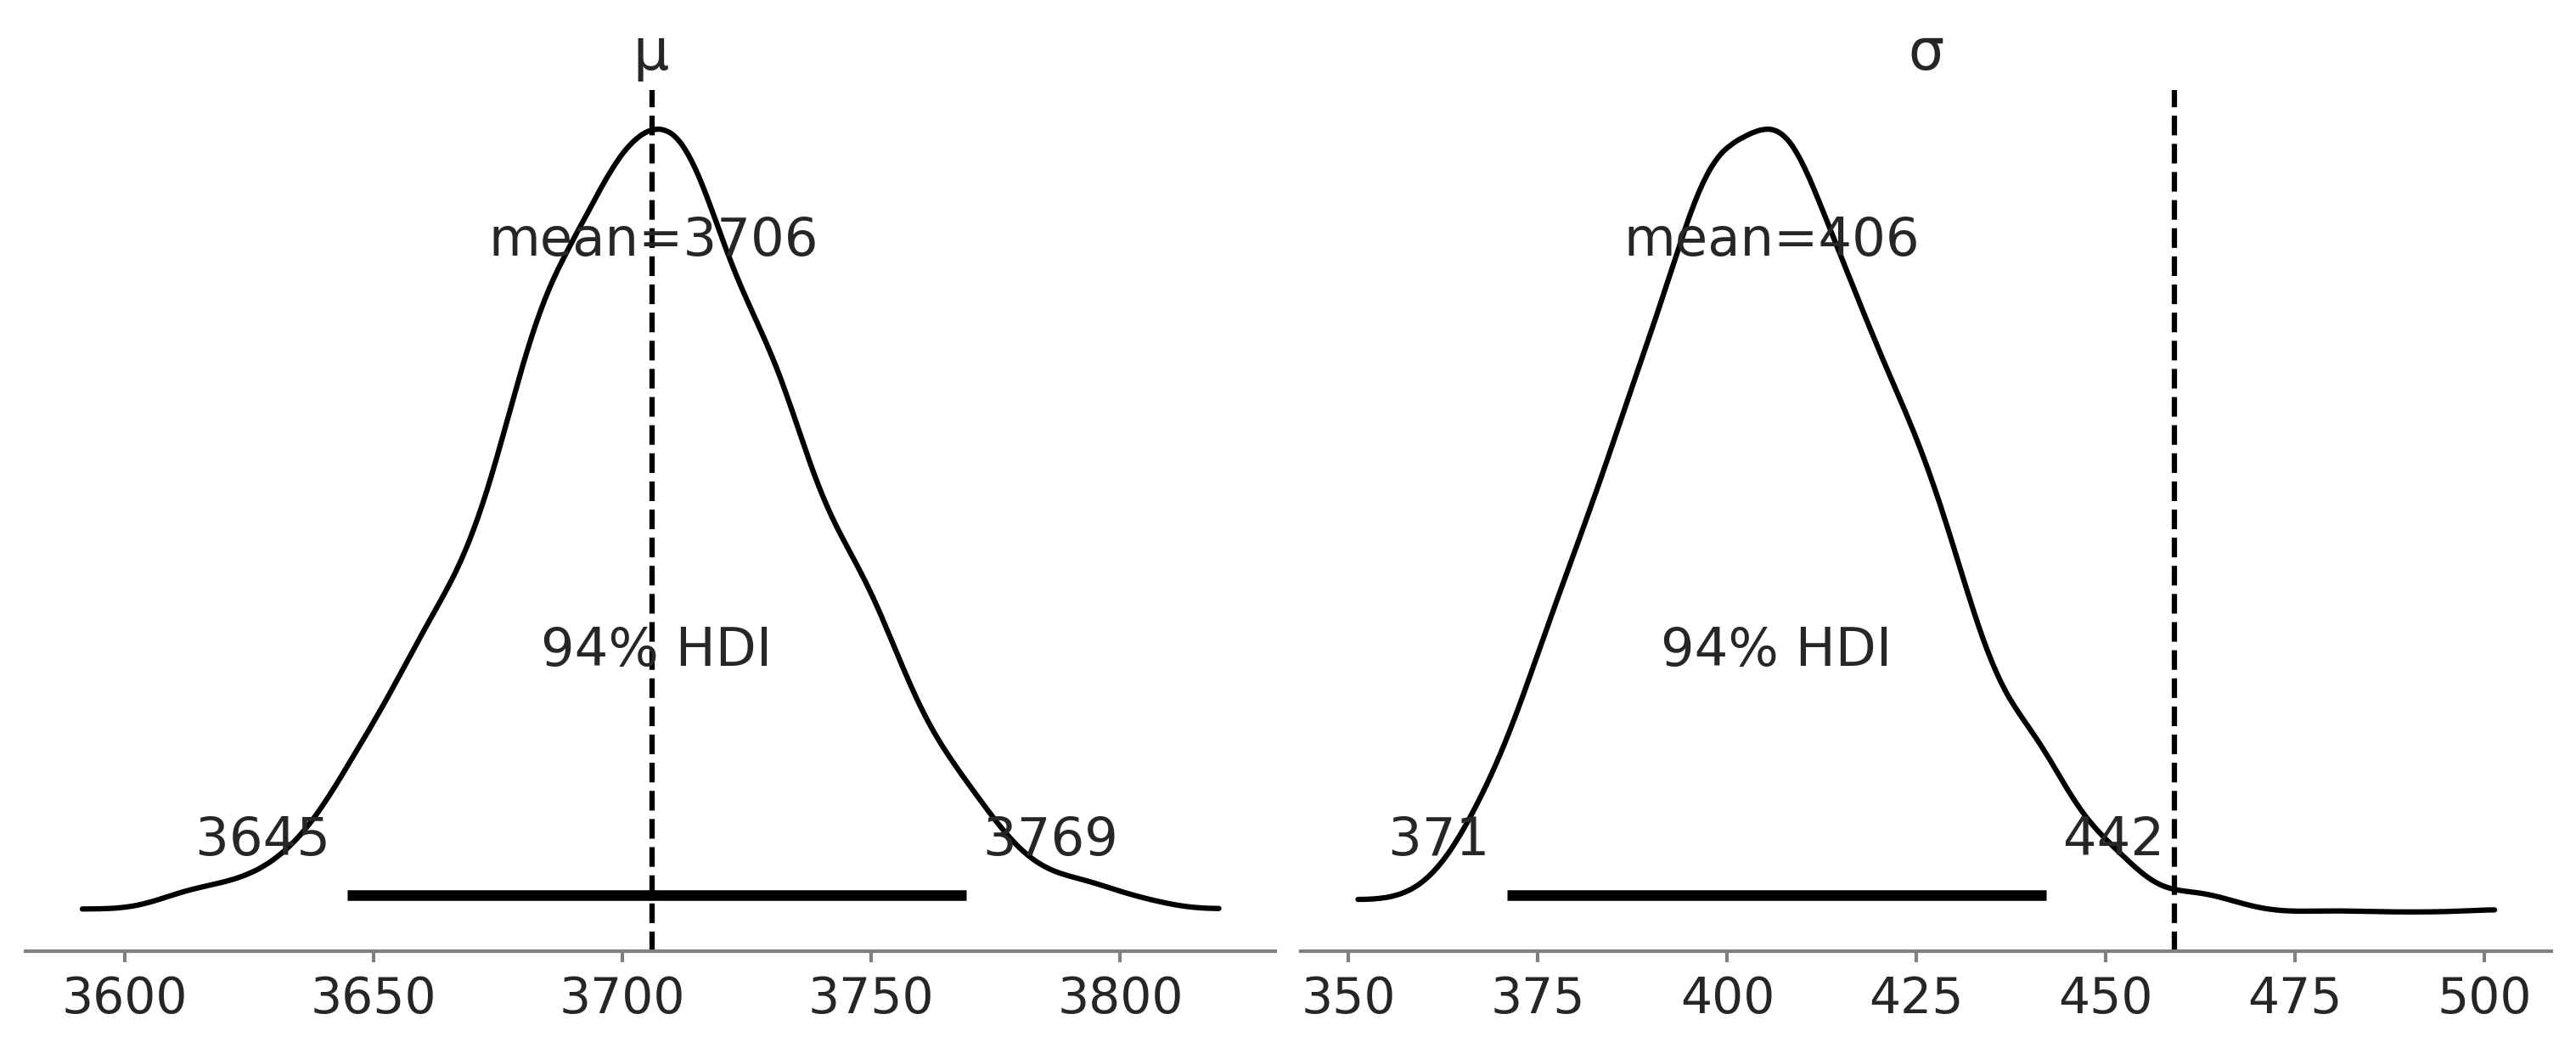

In [10]:
axes = az.plot_posterior(idata_adelie_mass, hdi_prob=.94, figsize=(10, 4));

# Copied from code output 3.2
axes[0].axvline(3706, linestyle="--")
axes[1].axvline(459, linestyle="--")
plt.savefig("img/chp03/single_species_mass_posteriorplot.png")

With the Bayesian estimate however, we also get the distribution of
plausible parameters. Using the tabular summary in Table {numref}`tab:penguin_mass_parameters_bayesian_estimates` from the same
posterior distribution in {numref}`fig:single_penguins_rank_kde_plot`
values of the mean from 3632 to 3772 grams are quite plausible. Note
that the standard deviation of the marginal posterior distribution
varies quite a bit as well. And remember the posterior distribution is
not the distribution of an individual penguin mass but rather possible
parameters of a Gaussian distribution that we assume describes penguin
mass. If we wanted the estimated distribution of individual penguin mass
we would need to generate a posterior predictive distribution. In this
case it will be the same Gaussian distribution conditioned on the
posterior of $\mu$ and $\sigma$.

Now that we have characterized the Adelie penguin's mass, we can do the
same for the other species. We could do so by writing two more models
but instead let us just run one model with 3 separated groups, one per
species.

```{code-block} python
:name: nocovariate_mass
:caption: nocovariate_mass
# pd.categorical makes it easy to index species below
all_species = pd.Categorical(penguins["species"])

with pm.Model() as model_penguin_mass_all_species:
    # Note the addition of the shape parameter
    σ = pm.HalfStudentT("σ", 100, 2000, shape=3)
    μ = pm.Normal("μ", 4000, 3000, shape=3)
    mass = pm.Normal("mass",
                     mu=μ[all_species.codes],
                     sigma=σ[all_species.codes],
                     observed=penguins["body_mass_g"])

    trace = pm.sample()
    inf_data_model_penguin_mass_all_species = az.from_pymc3(
        trace=trace,
        coords={"μ_dim_0": all_species.categories,
                "σ_dim_0": all_species.categories})
```

In [11]:
# pd.categorical makes it easy to index species below
all_species = pd.Categorical(penguins["species"])
coords = {"species": all_species.categories}

with pm.Model(coords=coords) as model_penguin_mass_all_species:
    # Note the addition of the shape parameter
    σ = pm.HalfStudentT("σ", 100, 2000, dims="species")
    μ = pm.Normal("μ", 4000, 3000, dims="species")
    mass = pm.Normal("mass",
                     mu=μ[all_species.codes],
                     sigma=σ[all_species.codes],
                     observed=penguins["body_mass_g"])

    idata_penguin_mass_all_species = pm.sample()



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


We use the optional shape argument in each parameter and add an index in
our likelihood indicating to PyMC3 that we want to condition the
posterior estimate for each species individually. In programming
language design small tricks that make expressing ideas more seamless
are called **syntactic sugar**, and probabilistic programming developers
include these as well. Probabilistic Programming Languages strive to
allow expressing models with ease and with less errors.

After we run the model we once again inspect the KDE and rank plots, see
{numref}`fig:all_penguins_rank_kde_plot`. Compared to
{numref}`fig:single_penguins_rank_kde_plot` you will see 4 additional
plots, 2 each for the additional parameters added. Take a moment to
compare the estimate of the mean with the summary mean shown for each
species in {numref}`tab:penguin_mass_parameters_point_estimates`. To
better visualize the differences between the distributions for each
species, we plot the posterior again in a forest plot using Code Block
[mass_forest_plot](mass_forest_plot).
{numref}`fig:forest_plot_means` makes it easier to compare our estimates
across species and note that the Gentoo penguins seem to have more mass
than Adelie or Chinstrap penguins.

```{figure} figures/AllSpecies_KDE_RankPlot.png
:name: fig:all_penguins_rank_kde_plot
:width: 7.00in
KDE and rank plot for posterior estimates of parameters of masses for
each species of penguins from the `penguins_masses` model. Note how each
species has its own pair of estimates for each parameter.
```

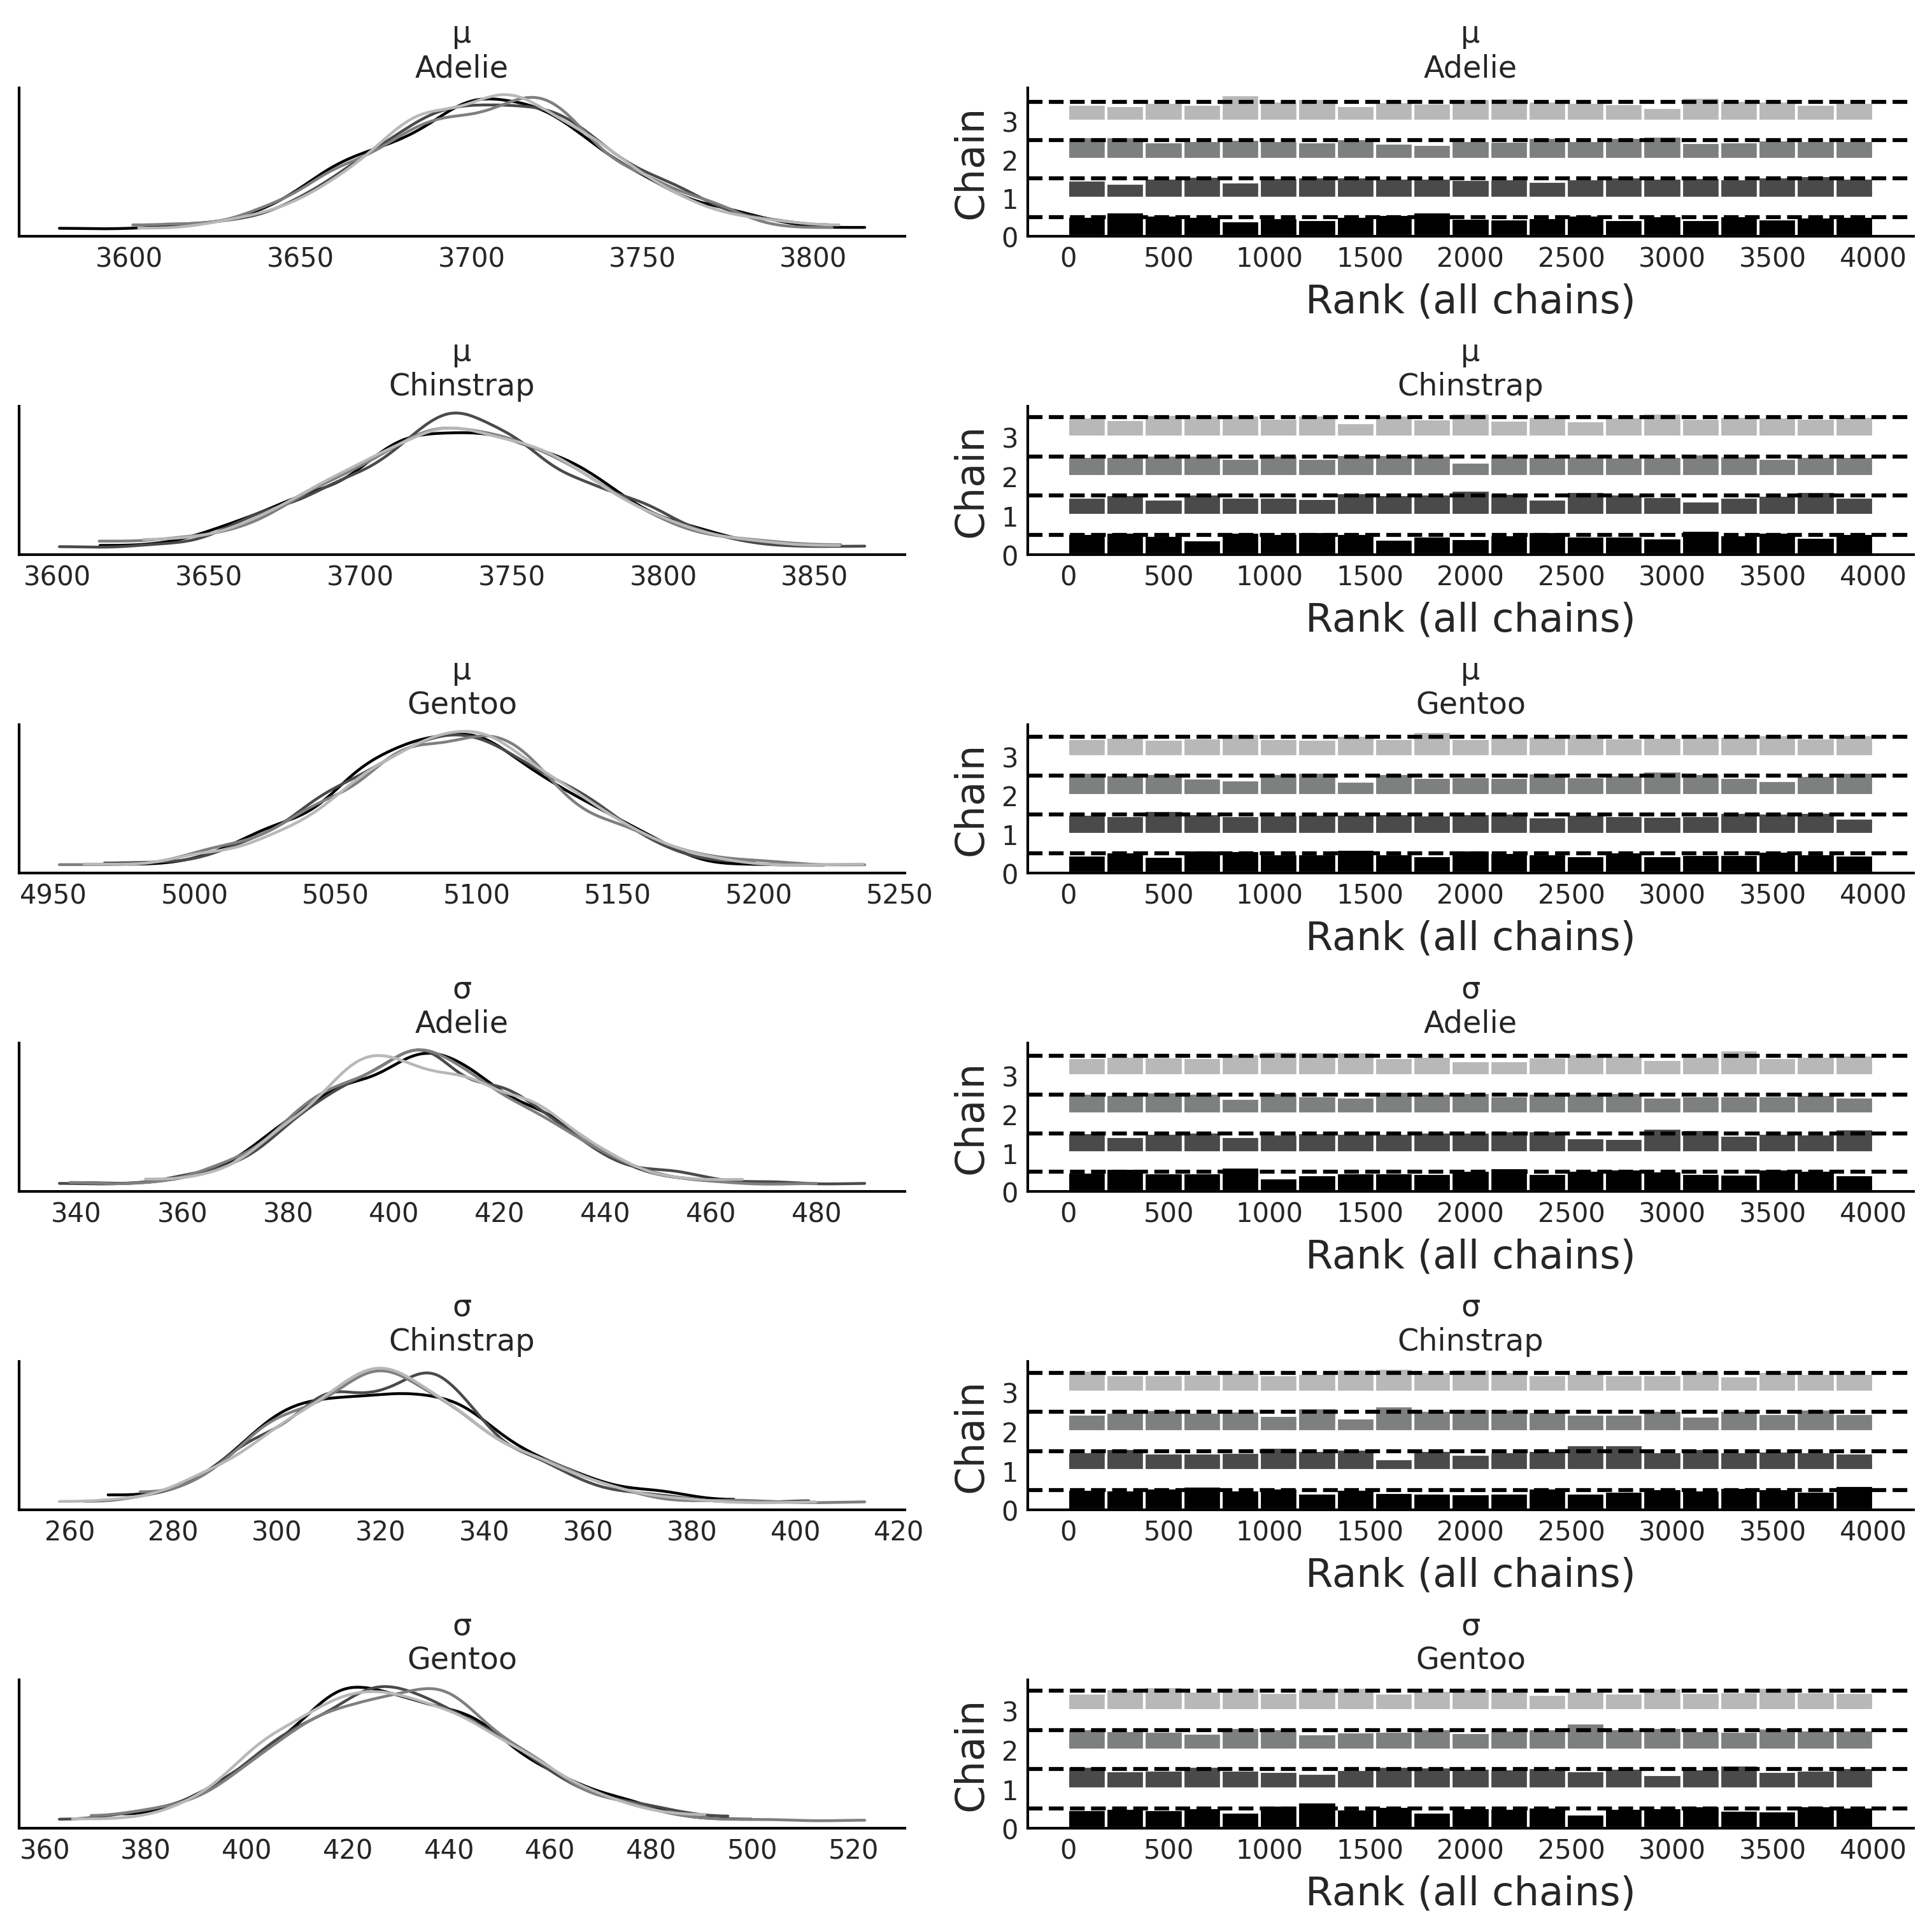

In [12]:
axes = az.plot_trace(idata_penguin_mass_all_species, compact=False,
                     divergences="bottom", kind="rank_bars", figsize=(10, 10));

plt.savefig("img/chp03/all_species_KDE_rankplot.png")

```{code-block} python
:name: mass_forest_plot
:caption: mass_forest_plot

az.plot_forest(inf_data_model_penguin_mass_all_species, var_names=["μ"])
```

```{figure} figures/Independent_Model_ForestPlotMeans.png
:name: fig:forest_plot_means
:width: 7.00in
Forest plot of the mean of mass of each species group in
`model_penguin_mass_all_species`.  Each line represents one chain in the sampler, the dot is the
mean, the thick line is the interquartile range and the thin line is the 94\% Highest Density
Interval.
```

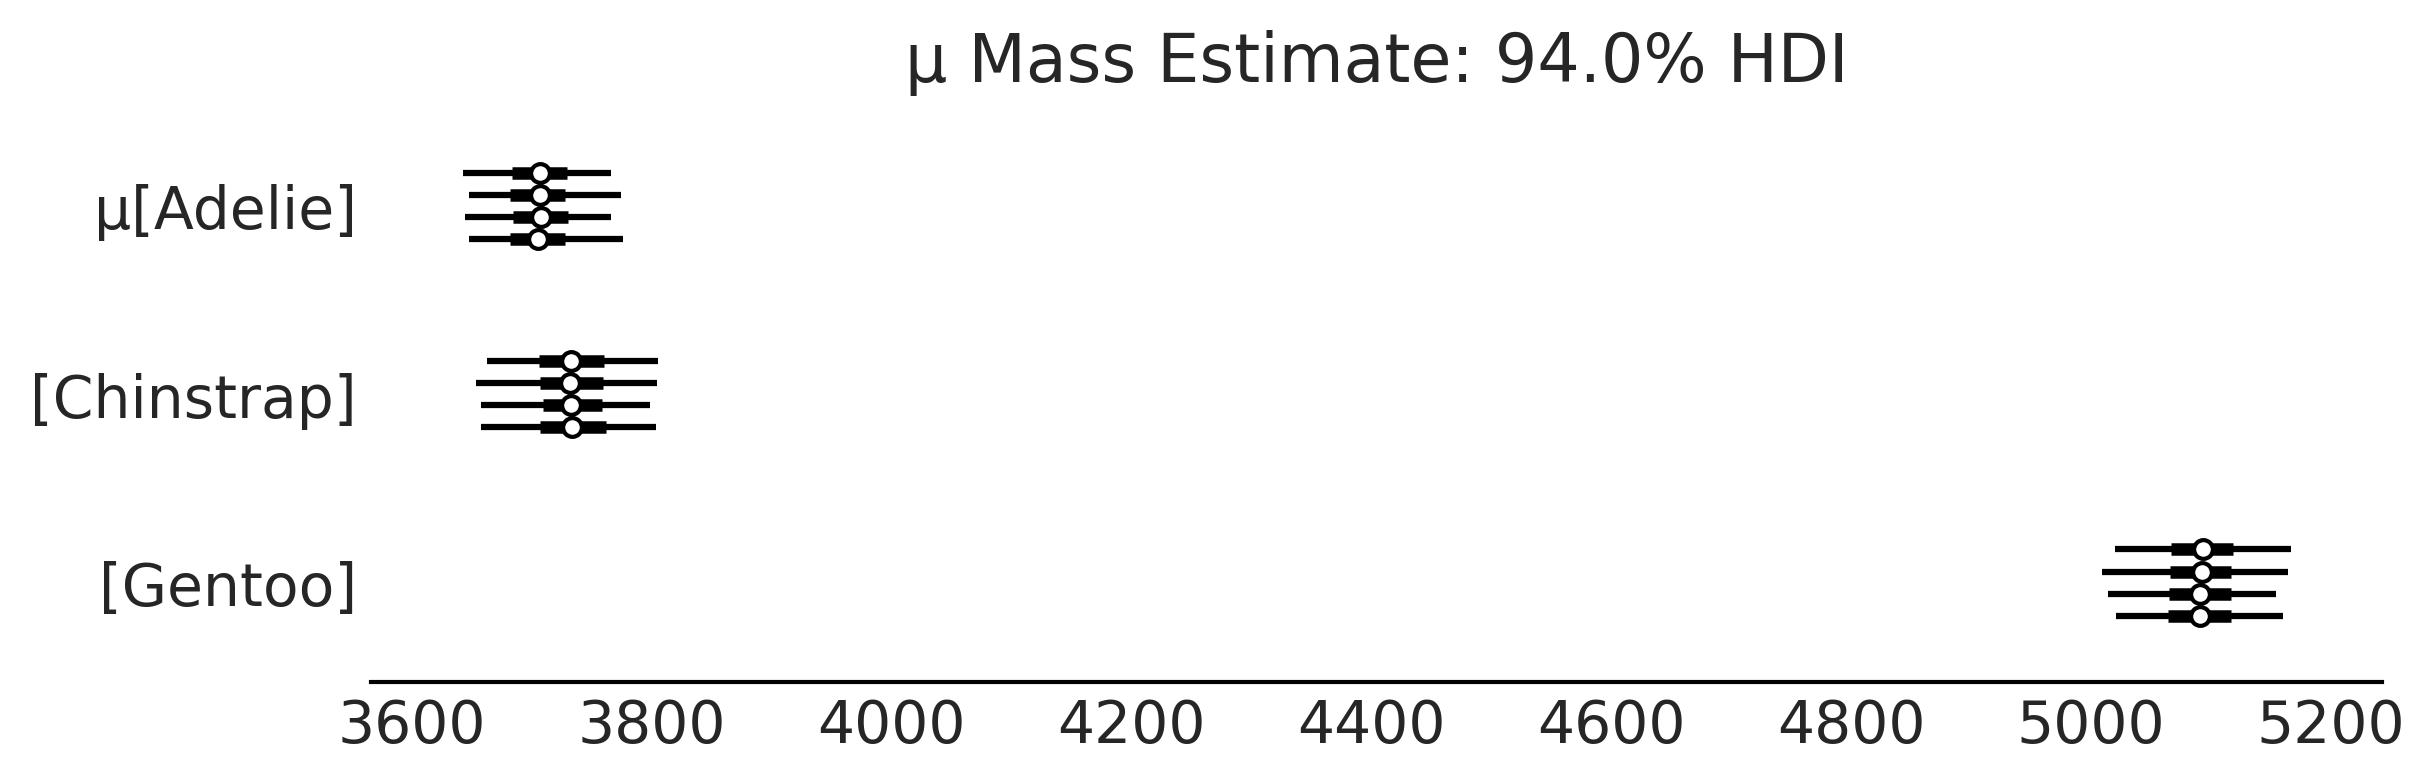

In [13]:
axes = az.plot_forest(idata_penguin_mass_all_species, var_names=["μ"], figsize=(8, 2.5))
axes[0].set_title("μ Mass Estimate: 94.0% HDI")

plt.savefig("img/chp03/independent_model_forestplotmeans.png")

{numref}`fig:forest_plot_means` makes it easier to compare our estimates
and easily note that the Gentoo penguins have more mass than Adelie or
Chinstrap penguins. Let us also look at the standard deviation in
{numref}`fig:forest_plot_sigma`. The 94% highest density interval of the
posterior is reporting uncertainty in the order of 100 grams.

    az.plot_forest(inf_data_model_penguin_mass_all_species, var_names=["σ"])
    
```{figure} figures/Independent_Model_ForestPlotSigma.png
:name: fig:forest_plot_sigma
:width: 7.00in
Forest plot of the standard deviations of the mass for each species
group in `model_penguin_mass_all_species`. This plot depicts our
estimation of the dispersion of penguin mass, so for example, given a
mean estimate of the Gentoo penguin distribution, the associated
standard deviation is plausibly anywhere between 450 grams to 550 grams.
```

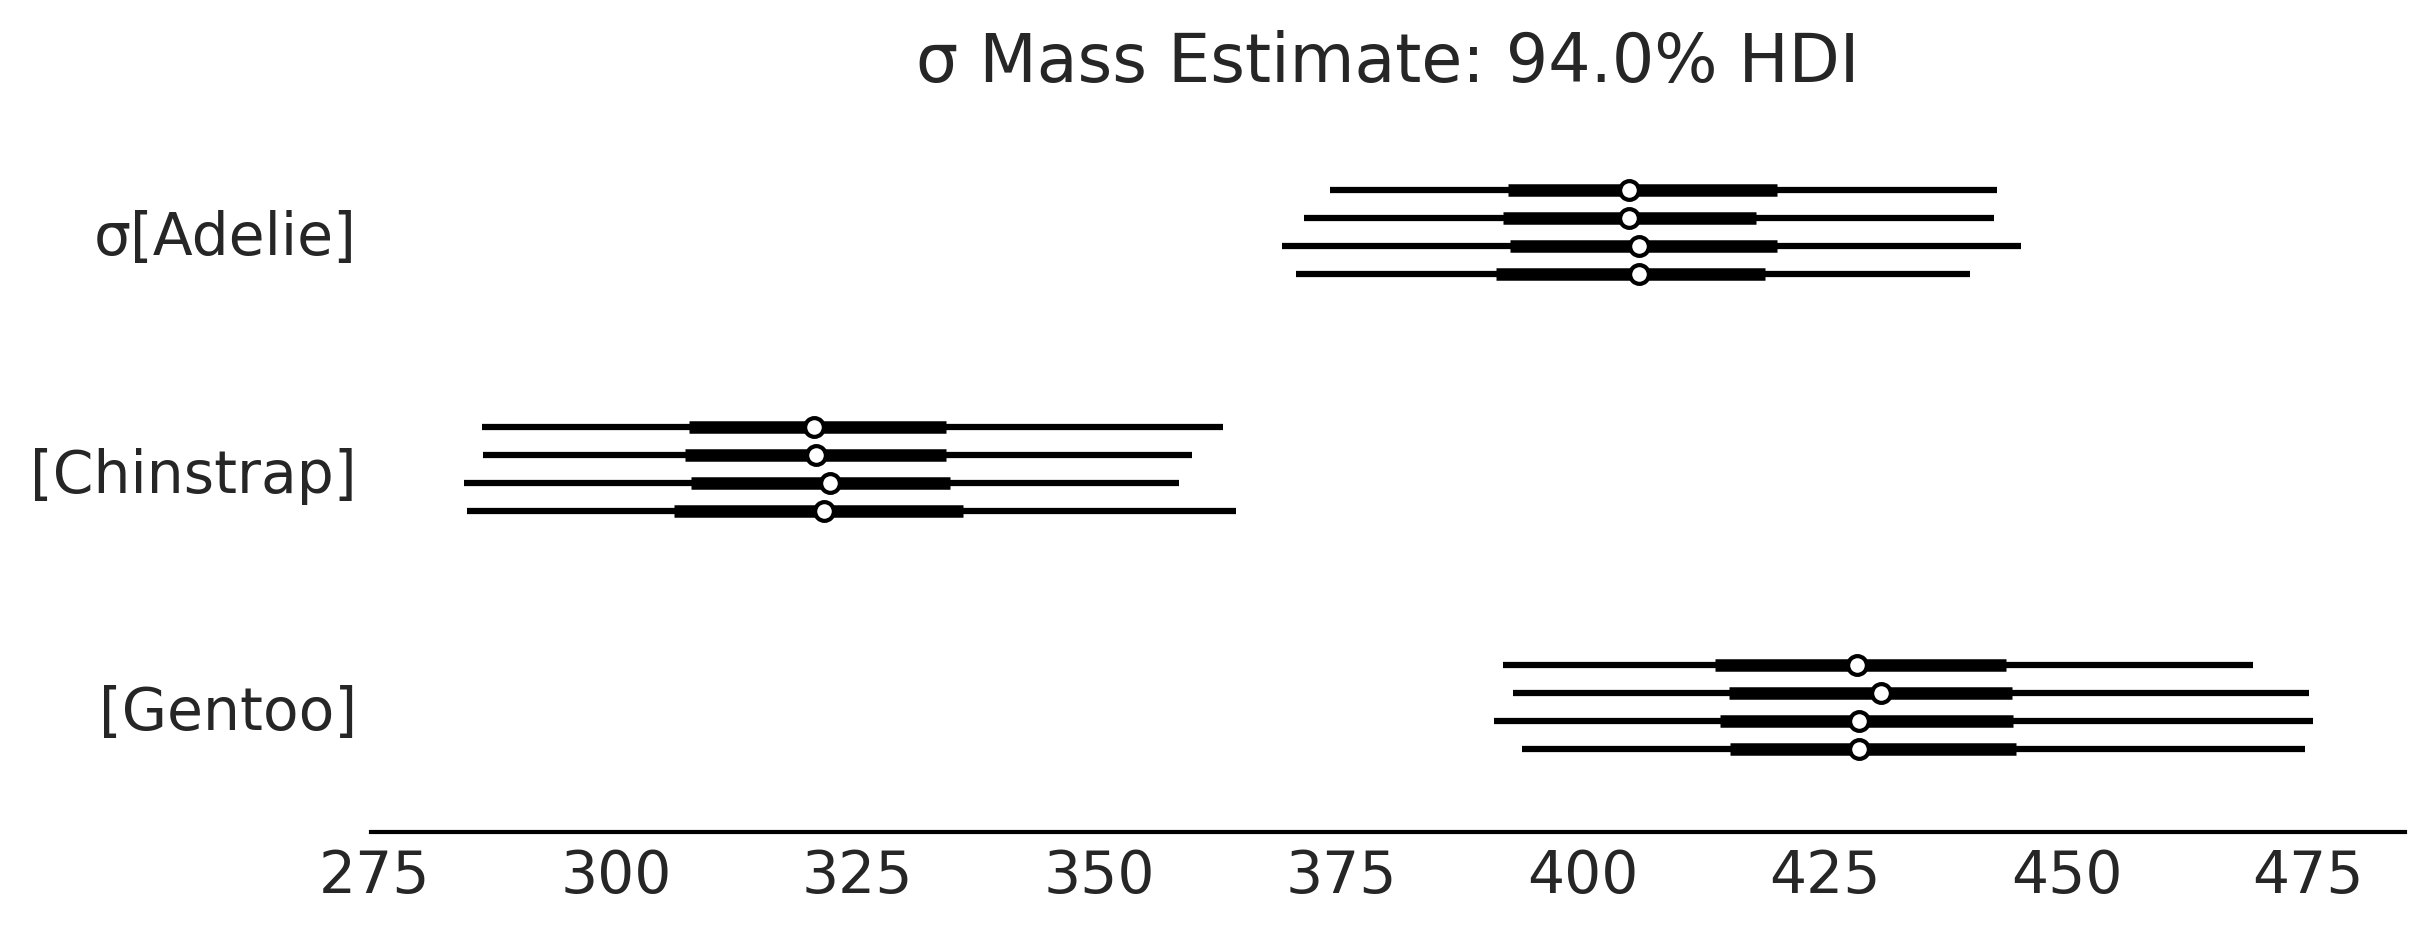

In [14]:
axes = az.plot_forest(idata_penguin_mass_all_species, var_names=["σ"], figsize=(8, 3));
axes[0].set_title("σ Mass Estimate: 94.0% HDI")

plt.savefig("img/chp03/independent_model_forestplotsigma.png")

(comparing-two-ppls)=

### 3.1.1 Comparing Two PPLs

Before expanding on the statistical and modeling ideas further, we will
take a moment to talk about the probabilistic programming languages and
introduce another PPL we will be using in this book, TensorFlow
Probability (TFP). We will do so by translating the PyMC3 intercept only
model in Code Block [nocovariate_mass](nocovariate_mass)
into TFP.

It may seem unnecessary to learn different PPLs. However, there are
specific reasons we chose to use two PPLs instead of one in this book.
Seeing the same workflow in different PPLs will give you a more thorough
understanding of computational Bayesian modeling, help you separate
computational details from statistical ideas, and make you a stronger
modeler overall. Moreover, different PPLs have different strength and
focus. PyMC3 is a higher level PPL that makes it easier to express
models with less code, whereas TFP provides a lower level PPL for
composable modeling and inference. Another is that not all PPLs are
able to express all models as easily as each other. For instance Time
Series models (Chapter [6](chap4)) are more easily defined in
TFP whereas Bayesian Additive Regression Trees are more easily expressed
in PyMC3 (Chapter [7](chap6)). Through this exposure to multiple
languages you will come out with a stronger understanding of both the
fundamental elements of Bayesian modeling and how they are implemented
computationally.

Probabilistic Programming Languages (emphasis on language) are composed
of primitives. The primitives in a programming language are the simplest
elements available to construct more complex programs. You can think of
primitives are like words in natural languages which can form more
complex structures, like sentences. And as different languages use
different words, different PPLs use different primitives. These
primitives are mainly used to express models, perform inference, or
express other parts of the workflow. In PyMC3, model building related
primitives are contained under the namespace `pm.` For example, in Code
Block [penguin_mass](penguin_mass) we see
`pm.HalfStudentT(.)`, and `pm.Normal(.)`, which represent a random
variable. The `with pm.Model() as .` statement evokes a Python context
manager, which PyMC3 uses to build the model `model_adelie_penguin_mass`
by collecting the random variables within the context manager. We then
use `pm.sample_prior_predictive(.)` and `pm.sample(.)` to obtain samples
from the prior predictive distribution and from the posterior
distribution, respectively.

Similarly, TFP provides primitives for user to specify distributions and
model in `tfp.distributions`, running MCMC (`tfp.mcmc`), and more. For
example, to construct a Bayesian model, TensorFlow provides multiple
primitives under the name `tfd.JointDistribution` {cite:p}`piponi2020joint`
API. In this chapter and the remaining of the book we mostly use
`tfd.JointDistributionCoroutine`, but there are other variants of
`tfd.JointDistribution` which may better suit your use case [^1]. Since
basic data import and summary statistics stays the same as Code Block
[penguin_load](penguin_load) and
[penguin_mass_empirical](penguin_mass_empirical) we can
focus on the model building and inference.
`model_penguin_mass_all_species` expressed in TFP which is shown in Code
Block [penguin_mass_tfp](penguin_mass_tfp) below

```{code-block} python
:name: penguin_mass_tfp
:caption: penguin_mass_tfp

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
root = tfd.JointDistributionCoroutine.Root

species_idx = tf.constant(all_species.codes, tf.int32)
body_mass_g = tf.constant(penguins["body_mass_g"], tf.float32)

@tfd.JointDistributionCoroutine
def jd_penguin_mass_all_species():
    σ = yield root(tfd.Sample(
            tfd.HalfStudentT(df=100, loc=0, scale=2000),
            sample_shape=3,
            name="sigma"))
    μ = yield root(tfd.Sample(
            tfd.Normal(loc=4000, scale=3000),
            sample_shape=3,
            name="mu"))
    mass = yield tfd.Independent(
        tfd.Normal(loc=tf.gather(μ, species_idx, axis=-1),
                   scale=tf.gather(σ, species_idx, axis=-1)),
        reinterpreted_batch_ndims=1,
        name="mass")
```

[^1]: You can find more information in the TensorFlow tutorials and
    documentations. For example,
    <https://www.tensorflow.org/probability/examples/JointDistributionAutoBatched_A_Gentle_Tutorial>
    and
    <https://www.tensorflow.org/probability/examples/Modeling_with_JointDistribution>.

In [15]:
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
root = tfd.JointDistributionCoroutine.Root

species_idx = tf.constant(all_species.codes, tf.int32)
body_mass_g = tf.constant(penguins["body_mass_g"], tf.float32)

@tfd.JointDistributionCoroutine
def jd_penguin_mass_all_species():
    σ = yield root(tfd.Sample(
            tfd.HalfStudentT(df=100, loc=0, scale=2000),
            sample_shape=3,
            name="sigma"))
    μ = yield root(tfd.Sample(
            tfd.Normal(loc=4000, scale=3000),
            sample_shape=3,
            name="mu"))
    mass = yield tfd.Independent(
        tfd.Normal(loc=tf.gather(μ, species_idx, axis=-1),
                   scale=tf.gather(σ, species_idx, axis=-1)),
        reinterpreted_batch_ndims=1,
        name="mass")

2025-01-24 23:44:41.531123: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-24 23:44:41.531150: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-24 23:44:41.531725: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-24 23:44:41.535307: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-24 23:44:43.337533: I exter

Since this is our first encounter with a Bayesian model written in TFP,
let us spend a few paragraphs to detail the API. The primitives are
distribution classes in `tfp.distributions`, which we assign a shorter
alias `tfd = tfp.distributions`. `tfd` contains commonly used
distributions like `tfd.Normal(.)`. We also used `tfd.Sample`, which
returns multiple independent copies of the base distribution
(conceptually we achieve the similar goal as using the syntactic sugar
`shape=(.)` in PyMC3). `tfd.Independent` is used to indicate that the
distribution contains multiple copies that we would like to sum over
some axis when computing the log-likelihood, which specified by the
`reinterpreted_batch_ndims` function argument. Usually we wrap the
distributions associated with the observation with `tfd.Independent`
[^2]. You can read a bit more about shape handling in TFP and PPL in
Section {ref}`shape_ppl`.

An interesting signature of a `tfd.JointDistributionCoroutine` model is,
as the name suggests, the usage of Coroutine in Python. Without getting
into too much detail about Generators and Coroutines, here a `yield`
statement of a distribution gives you some random variable inside of
your model function. You can view `y = yield Normal(.)` as the way to
express $y \sim \text{Normal(.)}$. Also, we need to identify the random
variables without dependencies as root nodes by wrapping them with
`tfd.JointDistributionCoroutine.Root`. The model is written as a Python
function with no input argument and no return value. Lastly, it is
convenient to put `@tfd.JointDistributionCoroutine` on top of the Python
function as a decorator to get the model (i.e., a
`tfd.JointDistribution`) directly.

The resulting `jd_penguin_mass_all_species` is the intercept only
regression model in Code Block [nocovariate_mass](nocovariate_mass)
restated in TFP. It has similar methods like other `tfd.Distribution`,
which we can utilize in our Bayesian workflow. For example, to draw
prior and prior predictive samples, we can call the `.sample(.)` method,
which returns a custom nested Python structure similar to a
`namedtuple`. In Code Block
[penguin_mass_tfp_prior_predictive](penguin_mass_tfp_prior_predictive)
we draw 1000 prior and prior predictive samples.

```{code-block} python
:name: penguin_mass_tfp_prior_predictive
:caption: penguin_mass_tfp_prior_predictive

prior_predictive_samples = jd_penguin_mass_all_species.sample(1000)
```

[^2]: `tfd.Sample` and `tfd.Independent` are distribution constructors
    that takes other distributions as input and return a new
    distribution. There are other meta distribution but with different
    purposes like `tfd.Mixture`, `tfd.TransformedDistribution`, and
    `tfd.JointDistribution`. A more comprehensive introduction to
    `tfp.distributions` can be found in
    <https://www.tensorflow.org/probability/examples/TensorFlow_Distributions_Tutorial>

In [16]:
prior_predictive_samples = jd_penguin_mass_all_species.sample(1000)

The `.sample(.)` method of a `tfd.JointDistribution` can also draw
conditional samples, which is the mechanism we will make use of to draw
posterior predictive samples. You can run Code Block
[penguin_mass_tfp_prior_predictive2](penguin_mass_tfp_prior_predictive2)
and inspect the output to see how random samples change if you condition
some random variables in the model to some specific values. Overall, we
invoke the *forward* generative process when calling `.sample(.)`.

```{code-block} python
:name: penguin_mass_tfp_prior_predictive2
:caption: penguin_mass_tfp_prior_predictive2
jd_penguin_mass_all_species.sample(sigma=tf.constant([.1, .2, .3]))
jd_penguin_mass_all_species.sample(mu=tf.constant([.1, .2, .3]))
```

In [17]:
jd_penguin_mass_all_species.sample(sigma=tf.constant([.1, .2, .3]))
jd_penguin_mass_all_species.sample(mu=tf.constant([.1, .2, .3]));

Once we condition the generative model `jd_penguin_mass_all_species` to
the observed penguin body mass, we can get the posterior distribution.
From the computational perspective, we want to generate a function that
returns the posterior log-probability (up to some constant) evaluated at
the input. This could be done by creating a Python function closure or
using the `.experimental_pin` method, as shown in Code Block
[tfp_posterior_generation](tfp_posterior_generation):

```{code-block} python
:name: tfp_posterior_generation
:caption: tfp_posterior_generation

target_density_function = lambda *x: jd_penguin_mass_all_species.log_prob(
    *x, mass=body_mass_g)

jd_penguin_mass_observed = jd_penguin_mass_all_species.experimental_pin(
    mass=body_mass_g)
target_density_function = jd_penguin_mass_observed.unnormalized_log_prob
```

In [18]:
target_density_function = lambda *x: jd_penguin_mass_all_species.log_prob(*x, mass=body_mass_g)

jd_penguin_mass_observed = jd_penguin_mass_all_species.experimental_pin(mass=body_mass_g)
target_density_function = jd_penguin_mass_observed.unnormalized_log_prob

# init_state = jd_penguin_mass_observed.sample_unpinned(10)
# target_density_function1(*init_state), target_density_function2(*init_state)

Inference is done using `target_density_function`, for example, we can
find the maximum of the function, which gives the **maximum a posteriori
probability** (MAP) estimate. We can also use methods in `tfp.mcmc`
{cite:p}`lao2020tfpmcmc` to sample from the posterior. Or more conveniently,
using a standard sampling routine similar to what is currently used in
PyMC3 [^3] as shown in Code Block
[tfp_posterior_inference](tfp_posterior_inference):

```{code-block} python
:name: tfp_posterior_inference
:caption: tfp_posterior_inference

run_mcmc = tf.function(
    tfp.experimental.mcmc.windowed_adaptive_nuts,
    autograph=False, jit_compile=True)
mcmc_samples, sampler_stats = run_mcmc(
    1000, jd_penguin_mass_all_species, n_chains=4, num_adaptation_steps=1000,
    mass=body_mass_g)

inf_data_model_penguin_mass_all_species2 = az.from_dict(
    posterior={
        # TFP mcmc returns (num_samples, num_chains, ...), we swap
        # the first and second axis below for each RV so the shape
        # is what ArviZ expected.
        k:np.swapaxes(v, 1, 0)
        for k, v in mcmc_samples._asdict().items()},
    sample_stats={
        k:np.swapaxes(sampler_stats[k], 1, 0)
        for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]}
)
```

[^3]: <https://mc-stan.org/docs/2_23/reference-manual/hmc-algorithm-parameters.html#automatic-parameter-tuning>

In [19]:
run_mcmc = tf.function(
    tfp.experimental.mcmc.windowed_adaptive_nuts,
    autograph=False, jit_compile=True)
mcmc_samples, sampler_stats = run_mcmc(
    1000, jd_penguin_mass_all_species, n_chains=4, num_adaptation_steps=1000,
    mass=body_mass_g)

idata_penguin_mass_all_species2 = az.from_dict(
    posterior={
        # TFP mcmc returns (num_samples, num_chains, ...), we swap
        # the first and second axis below for each RV so the shape
        # is what ArviZ expected.
        k:np.swapaxes(v, 1, 0)
        for k, v in mcmc_samples._asdict().items()},
    sample_stats={
        k:np.swapaxes(sampler_stats[k], 1, 0)
        for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]}
)

2025-01-24 23:44:52.066571: I external/local_xla/xla/service/service.cc:168] XLA service 0x622b84ca23b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-24 23:44:52.066608: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti Laptop GPU, Compute Capability 8.6
2025-01-24 23:44:52.214737: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-24 23:44:52.311593: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sanitize_seed/seed
2025-01-24 23:44:52.439142: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert
2025-01-24 23:44:56.303853:

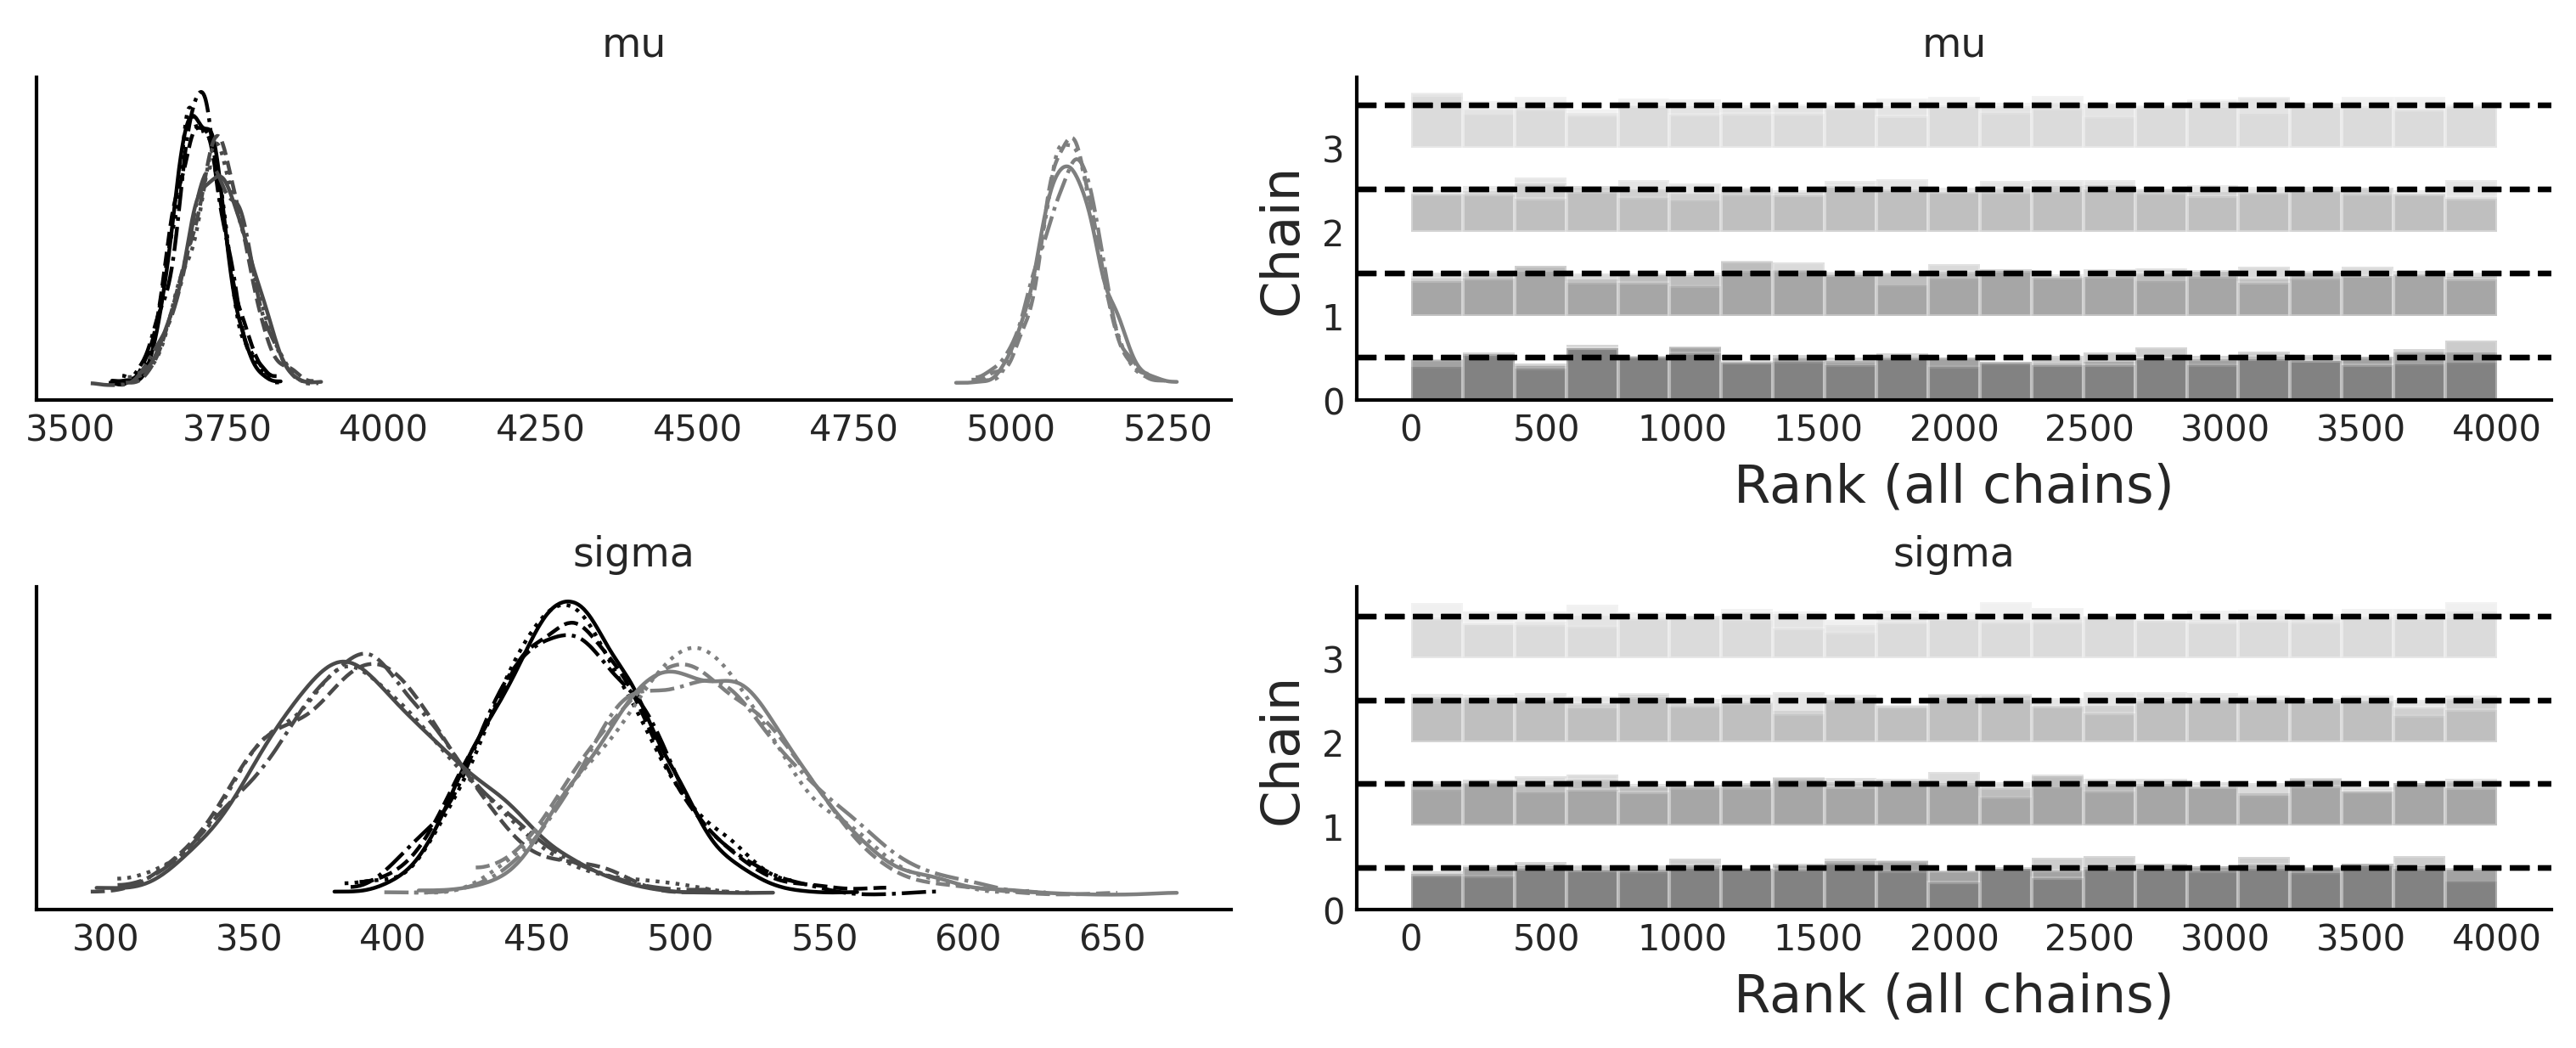

In [20]:
az.plot_trace(idata_penguin_mass_all_species2, divergences="bottom", kind="rank_bars", figsize=(10,4));

In Code Block
[tfp_posterior_inference](tfp_posterior_inference) we ran
4 MCMC chains, each with 1000 posterior samples after 1000 adaptation
steps. Internally it invokes the `experimental_pin` method by
conditioning the model (pass into the function as an argument) with the
observed (additional keyword argument `mass=body_mass_g` at the end).
Lines 8-18 parse the sampling result into an ArviZ InferenceData, which
we can now run diagnostics and exploratory analysis of Bayesian models
in ArviZ. We can additionally add prior and posterior predictive samples
and data log-likelihood to `inf_data_model_penguin_mass_all_species2` in
a transparent way in Code Block
[tfp_idata_additional](tfp_idata_additional) below. Note
that we make use of the `sample_distributions` method of a
`tfd.JointDistribution` that draws samples *and* generates a
distribution conditioned on the posterior samples.

```{code-block} python
:name: tfp_idata_additional
:caption: tfp_idata_additional

prior_predictive_samples = jd_penguin_mass_all_species.sample([1, 1000])
dist, samples = jd_penguin_mass_all_species.sample_distributions(
    value=mcmc_samples)
ppc_samples = samples[-1]
ppc_distribution = dist[-1].distribution
data_log_likelihood = ppc_distribution.log_prob(body_mass_g)

# Be careful not to run this code twice during REPL workflow.
inf_data_model_penguin_mass_all_species2.add_groups(
    prior=prior_predictive_samples[:-1]._asdict(),
    prior_predictive={"mass": prior_predictive_samples[-1]},
    posterior_predictive={"mass": np.swapaxes(ppc_samples, 1, 0)},
    log_likelihood={"mass": np.swapaxes(data_log_likelihood, 1, 0)},
    observed_data={"mass": body_mass_g}
)
```

In [21]:
prior_predictive_samples = jd_penguin_mass_all_species.sample([1, 1000])
dist, samples = jd_penguin_mass_all_species.sample_distributions(
    value=mcmc_samples)
ppc_samples = samples[-1]
ppc_distribution = dist[-1].distribution
data_log_likelihood = ppc_distribution.log_prob(body_mass_g)

# Be careful not to run this code twice during REPL workflow.
idata_penguin_mass_all_species2.add_groups(
    prior=prior_predictive_samples[:-1]._asdict(),
    prior_predictive={"mass": prior_predictive_samples[-1]},
    posterior_predictive={"mass": np.swapaxes(ppc_samples, 1, 0)},
    log_likelihood={"mass": np.swapaxes(data_log_likelihood, 1, 0)},
    observed_data={"mass": body_mass_g}
)

/home/hwting/anaconda3/envs/rapids/lib/python3.11/site-packages/arviz/data/inference_data.py:1557: UserWarning: the default dims 'chain' and 'draw' will be added automatically
  warnings.warn(


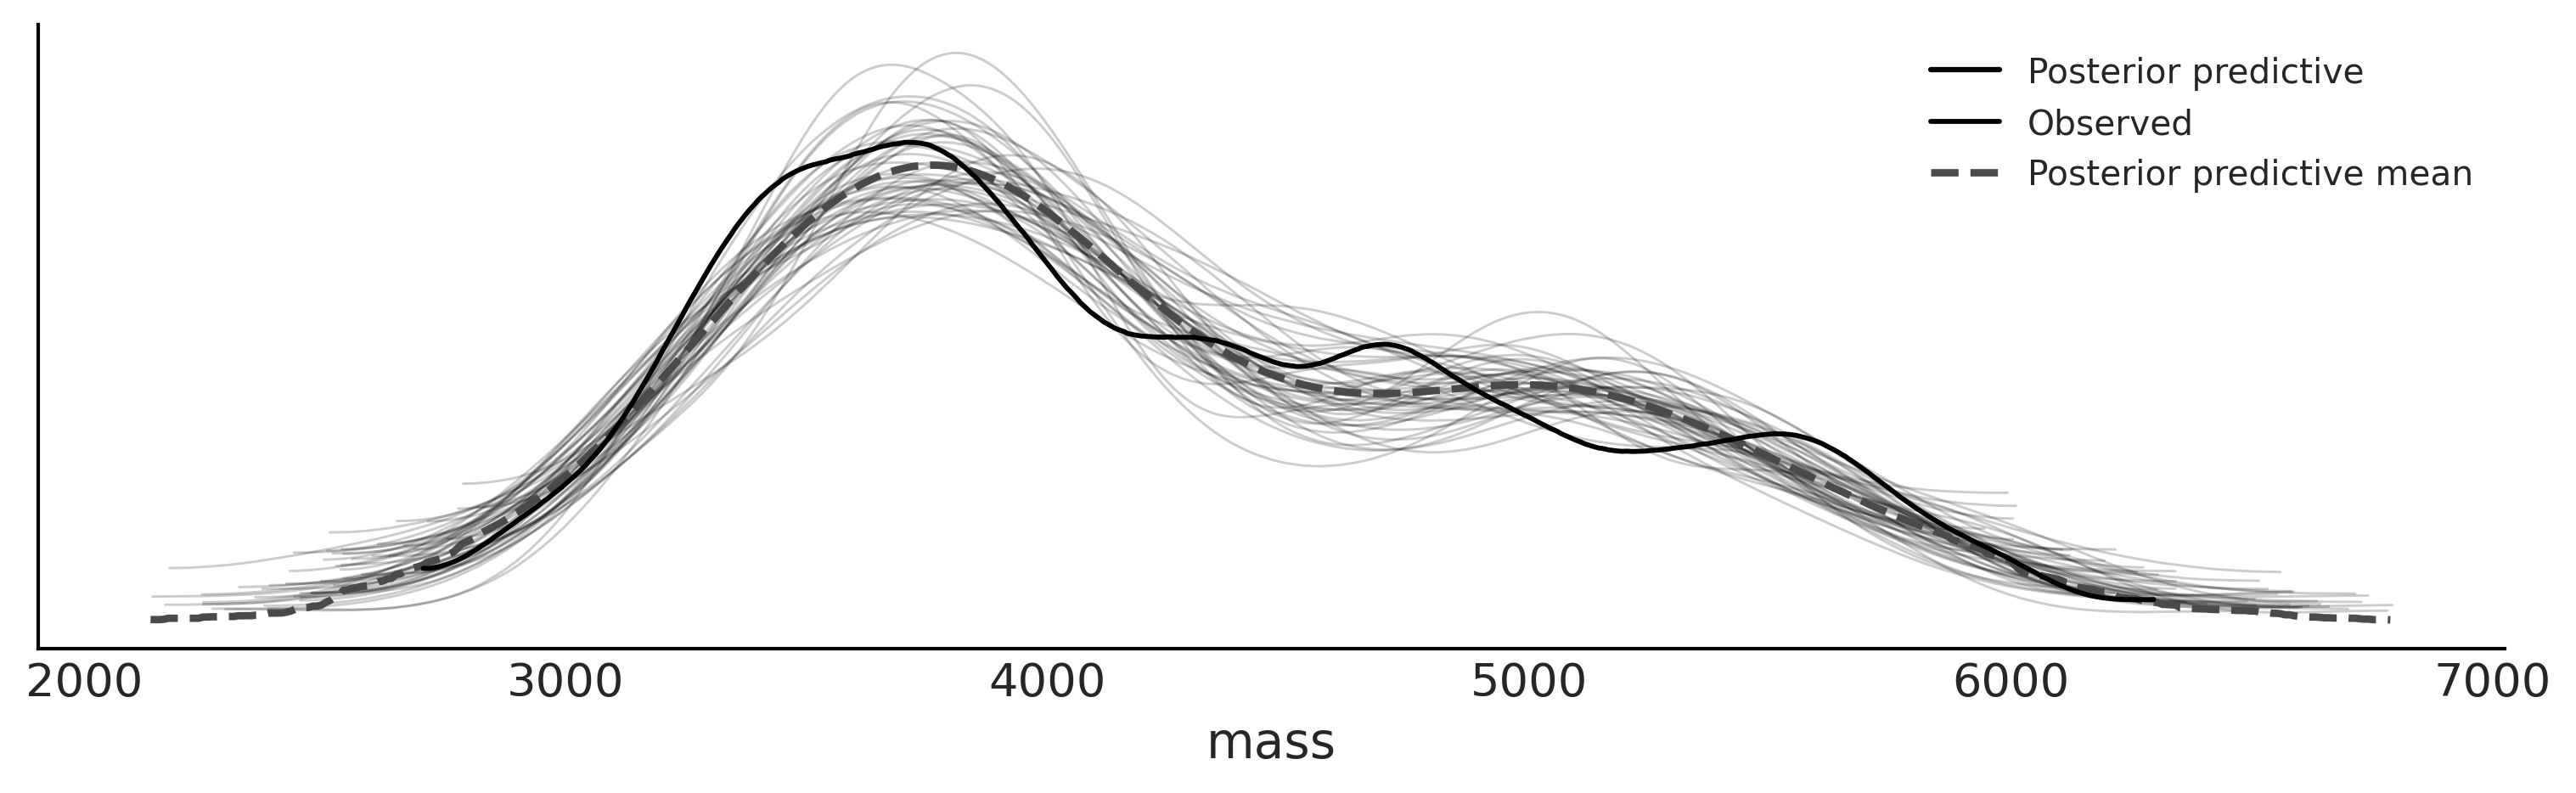

In [22]:
az.plot_ppc(idata_penguin_mass_all_species2, num_pp_samples=50, figsize=(10, 3));

In [23]:
az.loo(idata_penguin_mass_all_species2)

Computed from 4000 posterior samples and 333 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2516.29    11.63
p_loo        5.57        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      333  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

This concludes our whirlwind tour of TensorFlow Probability. Like any
language you likely will not gain fluency in your initial exposure. But
by comparing the two models you should now have a better sense of what
concepts are *Bayesian centric* and what concepts are *PPL centric*. For
the remainder of this chapter and the next we will switch between PyMC3
and TFP to continue helping you identify this difference and see more
worked examples. We include exercises to translate Code Block examples
from one to the other to aid your practice journey in becoming a PPL
polyglot.

(linear-regression)=

## 3.2 Linear Regression

In the previous section we modeled the distribution of penguin mass by
setting prior distributions over the mean and standard deviation of a
Gaussian distribution. Importantly we assumed that the mass did not vary
with other features in the data. However, we would expect that other
observed data points could provide information about expected penguins
mass. Intuitively if we see two penguins, one with long flippers and one
with short flippers, we would expect the larger penguin, the one with
long flippers, to have more mass even if we did not have a scale on hand
to measure their mass precisely. One of the simplest ways to estimate
this relationship of observed flipper length on estimated mass is to fit
a linear regression model, where the mean is *conditionally* modeled as
a linear combination of other variables

```{math}
:label: eq:expanded_regression

\begin{split}
    \mu =& \beta_0 + \beta_1 X_1 + \dots + \beta_m X_m \\
Y \sim& \mathcal{N}(\mu, \sigma)
\end{split}
```

where the coefficients, also referred as parameters, are represented with $\beta_i$.
For example, $\beta_0$ is the intercept of
the linear model. $X_i$ is referred to predictors or independent
variables, and $Y$ is usually referred to as target, output, response,
or dependent variable. It is important to notice that both
$\boldsymbol{X}$ and $Y$ are observed data and that they are paired
$\{y_j, x_j\}$. That is, if we change the order of $Y$ without changing
$X$ we will destroy some of the information in our data.

We call this a linear regression because the parameters (not the
covariates) enter the model in a linear fashion. Also for models with a
single covariate, we can think of this model as fitting a line to the
$(X, y)$ data, and for higher dimensions a plane or more generally a
hyperplane.

Alternatively we can express Equation {eq}`eq:expanded_regression` using
matrix notation:

```{math}
:label: eq:linear_model_matrix
\mu = \mathbf{X}\boldsymbol{\beta}

```

where we are taking the matrix-vector product between the coefficient
column vector $\beta$ and the matrix of covariates $\mathbf{X}$.

An alternative expression you might have seen in other (non-Bayesian)
occasions is to rewrite Equation {eq}`eq:expanded_regression` as noisy
observation of some linear prediction:

```{math}
:label: eq:linear_model_enginner

Y = \mathbf{X}\boldsymbol{\beta} + \epsilon,\; \epsilon \sim \mathcal{N}(0, \sigma)
```

The formulation in Equation {eq}`eq:linear_model_enginner` separates the
deterministic part (linear prediction) and the stochastic part (noise)
of linear regression. However, we prefer Equation
{eq}`eq:expanded_regression` as it shows the generative process more
clearly.

::: {admonition} Design Matrix

The matrix $\mathbf{X}$ in Equation
{eq}`eq:linear_model_matrix` is known as design matrix and is a matrix
of values of explanatory variables of a given set of objects, plus an
additional column of ones to represent the intercept. Each row
represents an unique observation (e.g., a penguin), with the successive
columns corresponding to the variables (like flipper length) and their
specific values for that object.

A design matrix is not limited to continuous covariates. For discrete
covariates that represent categorical predictors (i.e., there are only a
few categories), a common way to turn those into a design matrix is
called dummy coding or one-hot coding. For example, in our intercept per
penguin model (Code Block
[nocovariate_mass](nocovariate_mass)), instead of
`mu = μ[species.codes]` we can use `pandas.get_dummies` to parse the
categorical information into a design matrix, and then write
`mu = pd.get_dummies(penguins["species"]) @ μ`, where `@` is a Python
operator for performing matrix multiplication. There are also few other
functions to perform one hot encoding in Python, for example,
`sklearn.preprocessing.OneHotEncoder`, as this is a very common data
manipulation technique.

Alternatively, categorical predictors could be encoded such that the
resulting column and associated coefficient representing linear
contrast. For example, different design matrix encoding of two
categorical predictors are associated with Type I, II and III sums of
squares in null-hypothesis testing setting for ANOVA.
:::

If we plot Equation {eq}`eq:expanded_regression` in "three dimensions\"
we get {numref}`fig:3d_linear_regression`, which shows how the estimated
parameters of the likelihood distribution can change based on other
observed data $x$. While in this one illustration, and in this chapter,
we are using a linear relationship to model the relationship between $x$
and $Y$, and a Gaussian distribution as a likelihood, in other model
architectures, we may opt for different choices as we will see in
Chapter [4](chap3).

```{figure} figures/3d_linear_regression.png
:name: fig:3d_linear_regression
:width: 7.00in
A linear regression with the Gaussian likelihood function evaluated at 3
points. Note this plot only shows one possible Gaussian distribution at
each value of $x$, where after fitting a Bayesian model we will end up
with a distribution of Gaussian, whose parameters may follow a
distribution other than Gaussian.
```

/tmp/ipykernel_252935/2386653877.py:38: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig("img/chp03/3d_linear_regression.png", bbox_inches="tight", dpi=300)


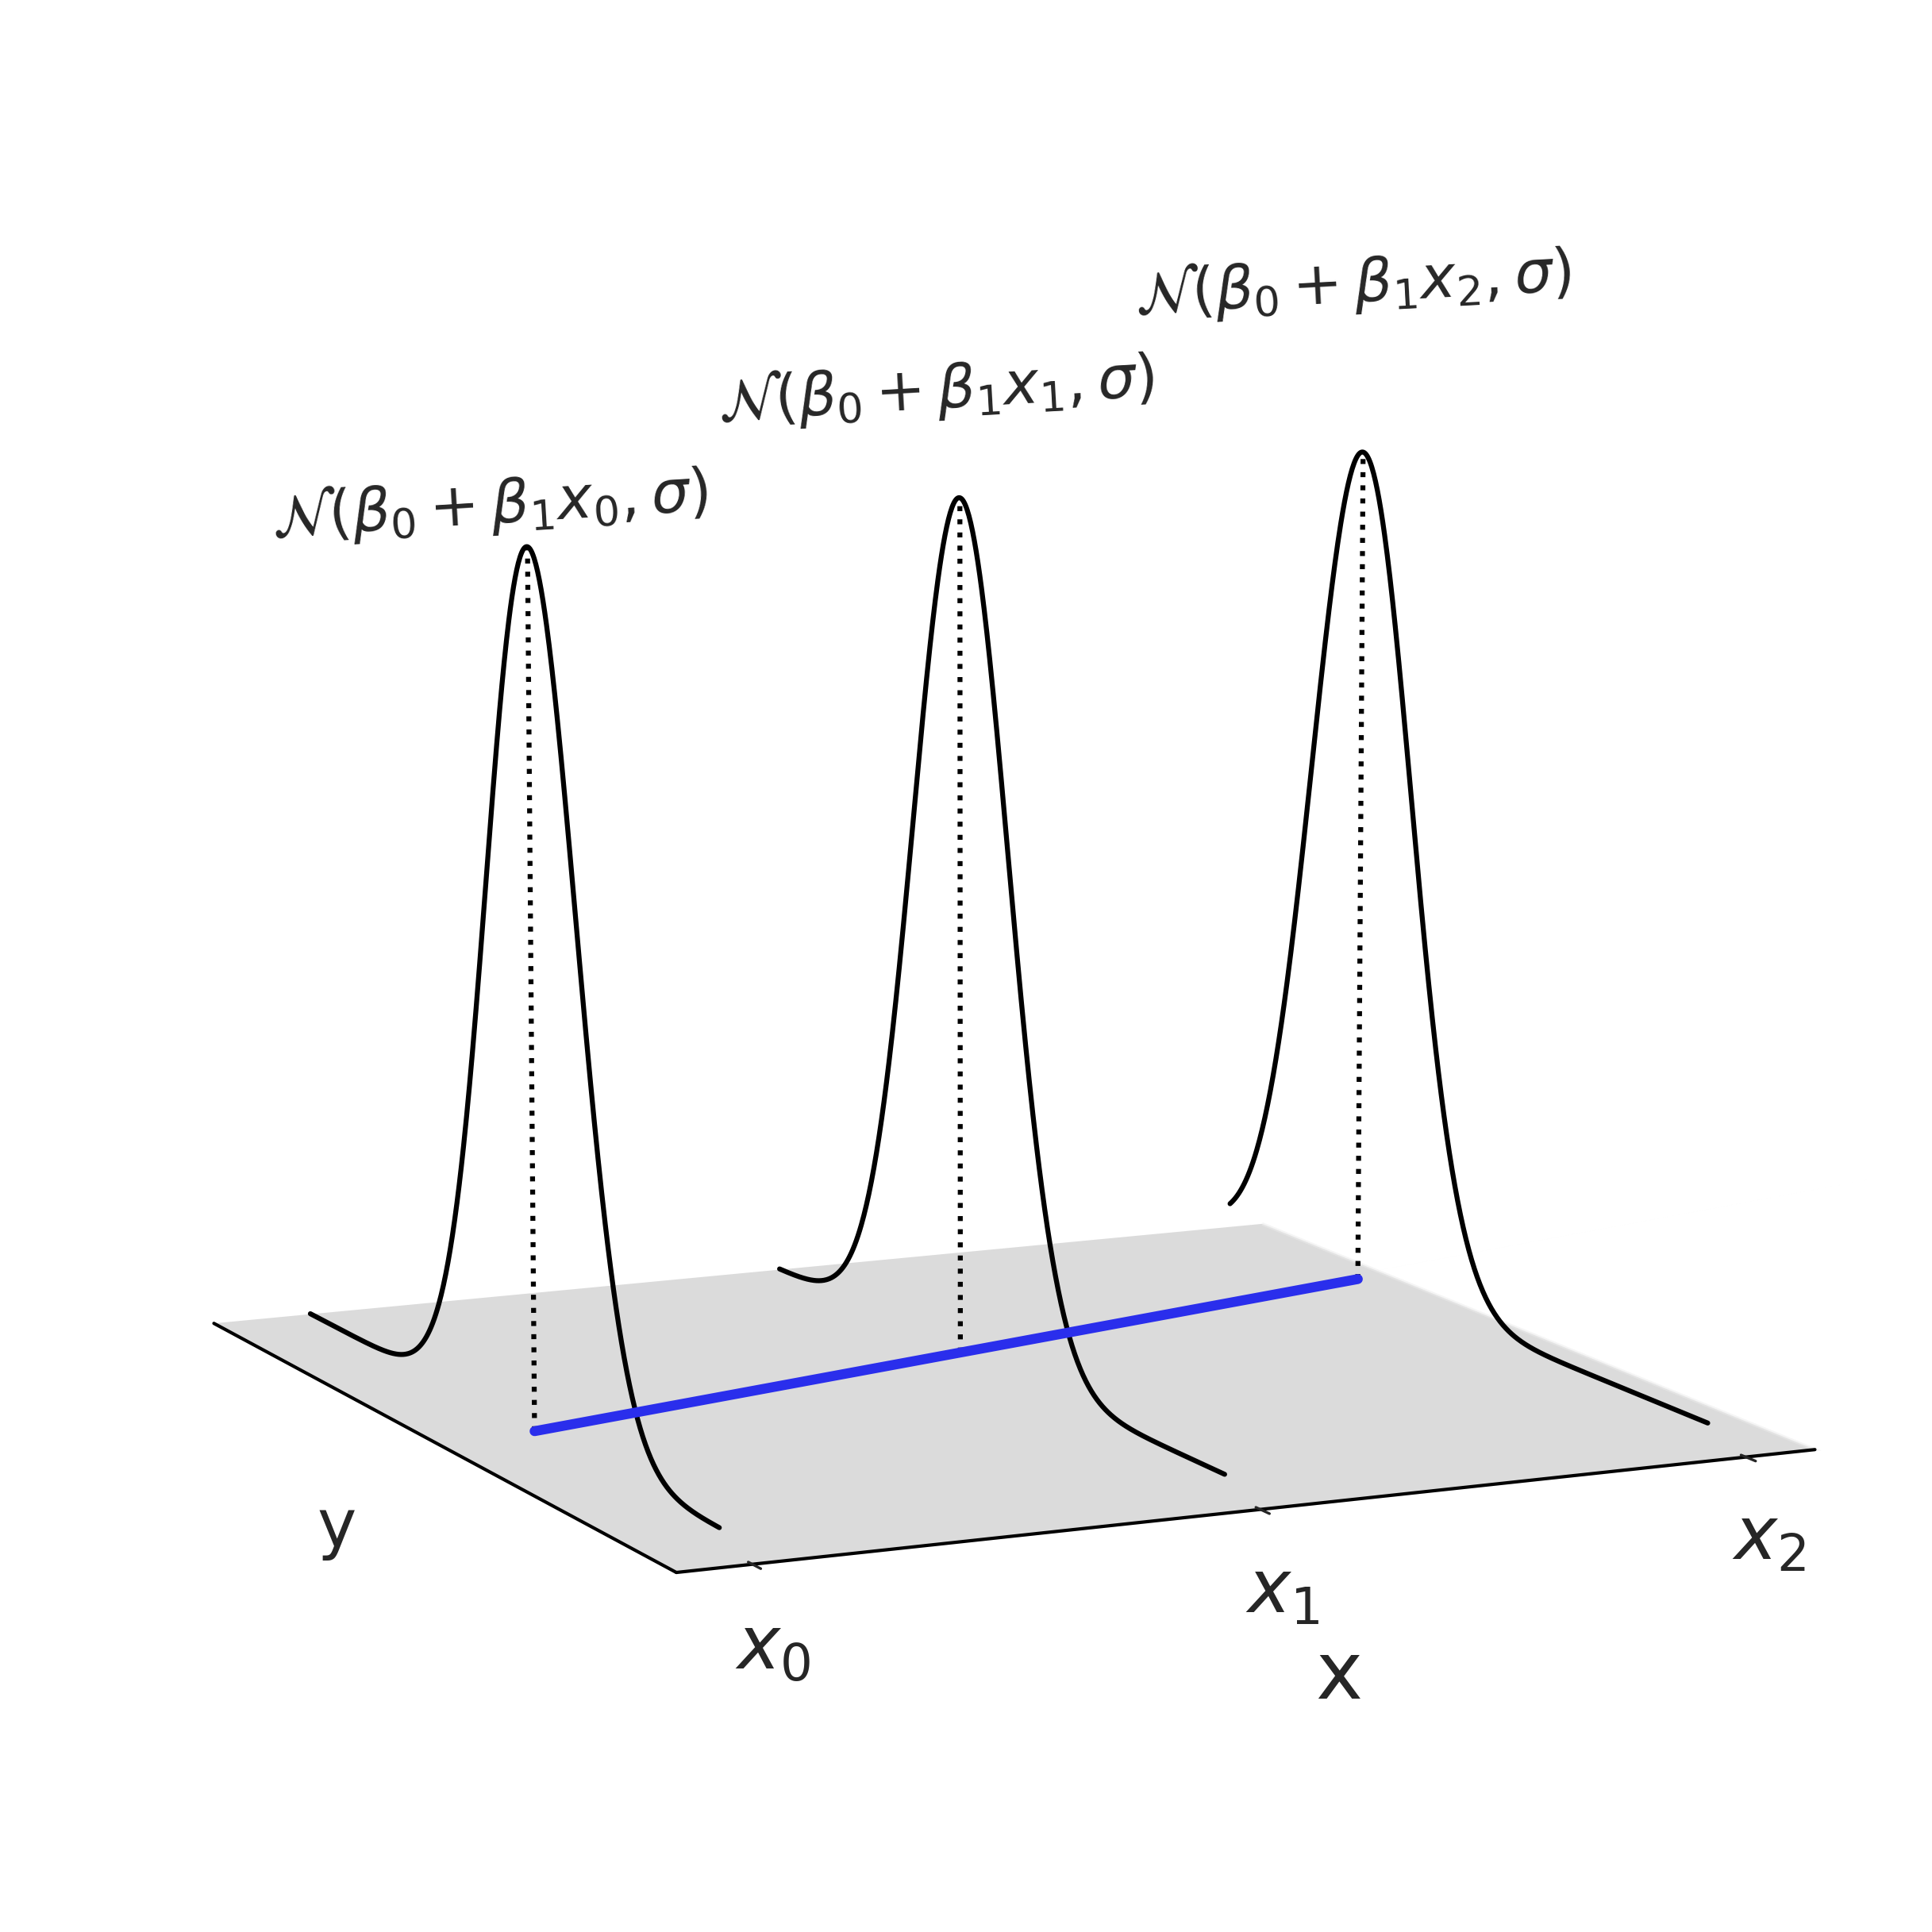

In [24]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')

x = np.linspace(-16, 12, 500)
z = np.array([0, 4, 8])

for i, zi in enumerate(z):
    dens = stats.norm(-zi, 3).pdf(x)
    ax.plot(x, dens, zs=zi + 1, zdir="y", c="k")
    ax.plot([-zi, -zi], [0, max(dens)], zs=zi + 1, c="k", ls=":", zdir="y")
    ax.text(
        -zi,
        zi - 1,
        max(dens) * 1.03 + i / 100,
        f"$\\mathcal{{N}}(\\beta_0 + \\beta_1 x_{i}, \\sigma)$",
        zdir="y",
        fontsize=18,
    )

ax.plot(-z, z + 1, "C4-", lw=3)


ax.set_xlabel("y", fontsize=20)
ax.set_ylabel("x", fontsize=24, labelpad=20)

ax.set_yticks([zi + 1 for zi in z])
ax.set_yticklabels([f"$x_{i}$" for i in range(len(z))], fontsize=22)
ax.grid(False)
ax.set_xticks([])
ax.set_zticks([])
ax.yaxis.pane.fill = False
ax.xaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor("None")
ax.yaxis.pane.set_edgecolor("None")
ax.zaxis.pane.set_facecolor("C3")
ax.zaxis.line.set_linewidth(0)
ax.view_init(elev=10, azim=-25)
plt.savefig("img/chp03/3d_linear_regression.png", bbox_inches="tight", dpi=300)

(linear_regression_intro)=

### 3.2.1 Linear Penguins

If we recall our penguins we were interested using additional data to
better estimate the mean mass of a group of penguins. Using linear
regression we write the model in Code Block
[non_centered_regression](non_centered_regression), which
includes two new parameters $\beta_0$ and $\beta_1$ typically called the
intercept and slope. For this example we set wide priors of
$\mathcal{N}(0, 4000)$ to focus on the model, which also is the same as
saying we assume no domain expertise. We subsequently run our sampler,
which has now estimated three parameters $\sigma$, $\beta_1$ and
$\beta_0$.

```{code-block} python
:name: non_centered_regression
:caption: non_centered_regression

adelie_flipper_length_obs = penguins.loc[adelie_mask, "flipper_length_mm"]

with pm.Model() as model_adelie_flipper_regression:
    # pm.Data allows us to change the underlying value in a later code block
    adelie_flipper_length = pm.Data("adelie_flipper_length",
                                    adelie_flipper_length_obs)
    σ = pm.HalfStudentT("σ", 100, 2000)
    β_0 = pm.Normal("β_0", 0, 4000)
    β_1 = pm.Normal("β_1", 0, 4000)
    μ = pm.Deterministic("μ", β_0 + β_1 * adelie_flipper_length)

    mass = pm.Normal("mass", mu=μ, sigma=σ, observed = adelie_mass_obs)

    inf_data_adelie_flipper_regression = pm.sample(return_inferencedata=True)
```

In [25]:
adelie_flipper_length_obs = penguins.loc[adelie_mask, "flipper_length_mm"]

with pm.Model() as model_adelie_flipper_regression:
    # pm.Data allows us to change the underlying value in a later code block
    adelie_flipper_length = pm.MutableData("adelie_flipper_length", adelie_flipper_length_obs)
    σ = pm.HalfStudentT("σ", 100, 2000)
    β_0 = pm.Normal("β_0", 0, 4000)
    β_1 = pm.Normal("β_1", 0, 4000)
    μ = pm.Deterministic("μ", β_0 + β_1 * adelie_flipper_length)

    mass = pm.Normal("mass", mu=μ, sigma=σ, observed=adelie_mass_obs)

    idata_adelie_flipper_regression = pm.sample()

/home/hwting/anaconda3/envs/rapids/lib/python3.11/site-packages/pymc/data.py:321: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β_0, β_1]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


To save space in the book we are not going to show the diagnostics each
time but you should neither trust us or your sampler blindly. Instead
you should run the diagnostics to verify you have a reliable posterior
approximation.

```{figure} figures/adelie_coefficient_posterior_plots.png
:name: fig:adelie_coefficient_posterior_plots
:width: 5in
Estimates of the parameter value distributions of our linear regression
coefficient from `model_adelie_flipper_regression`.
```

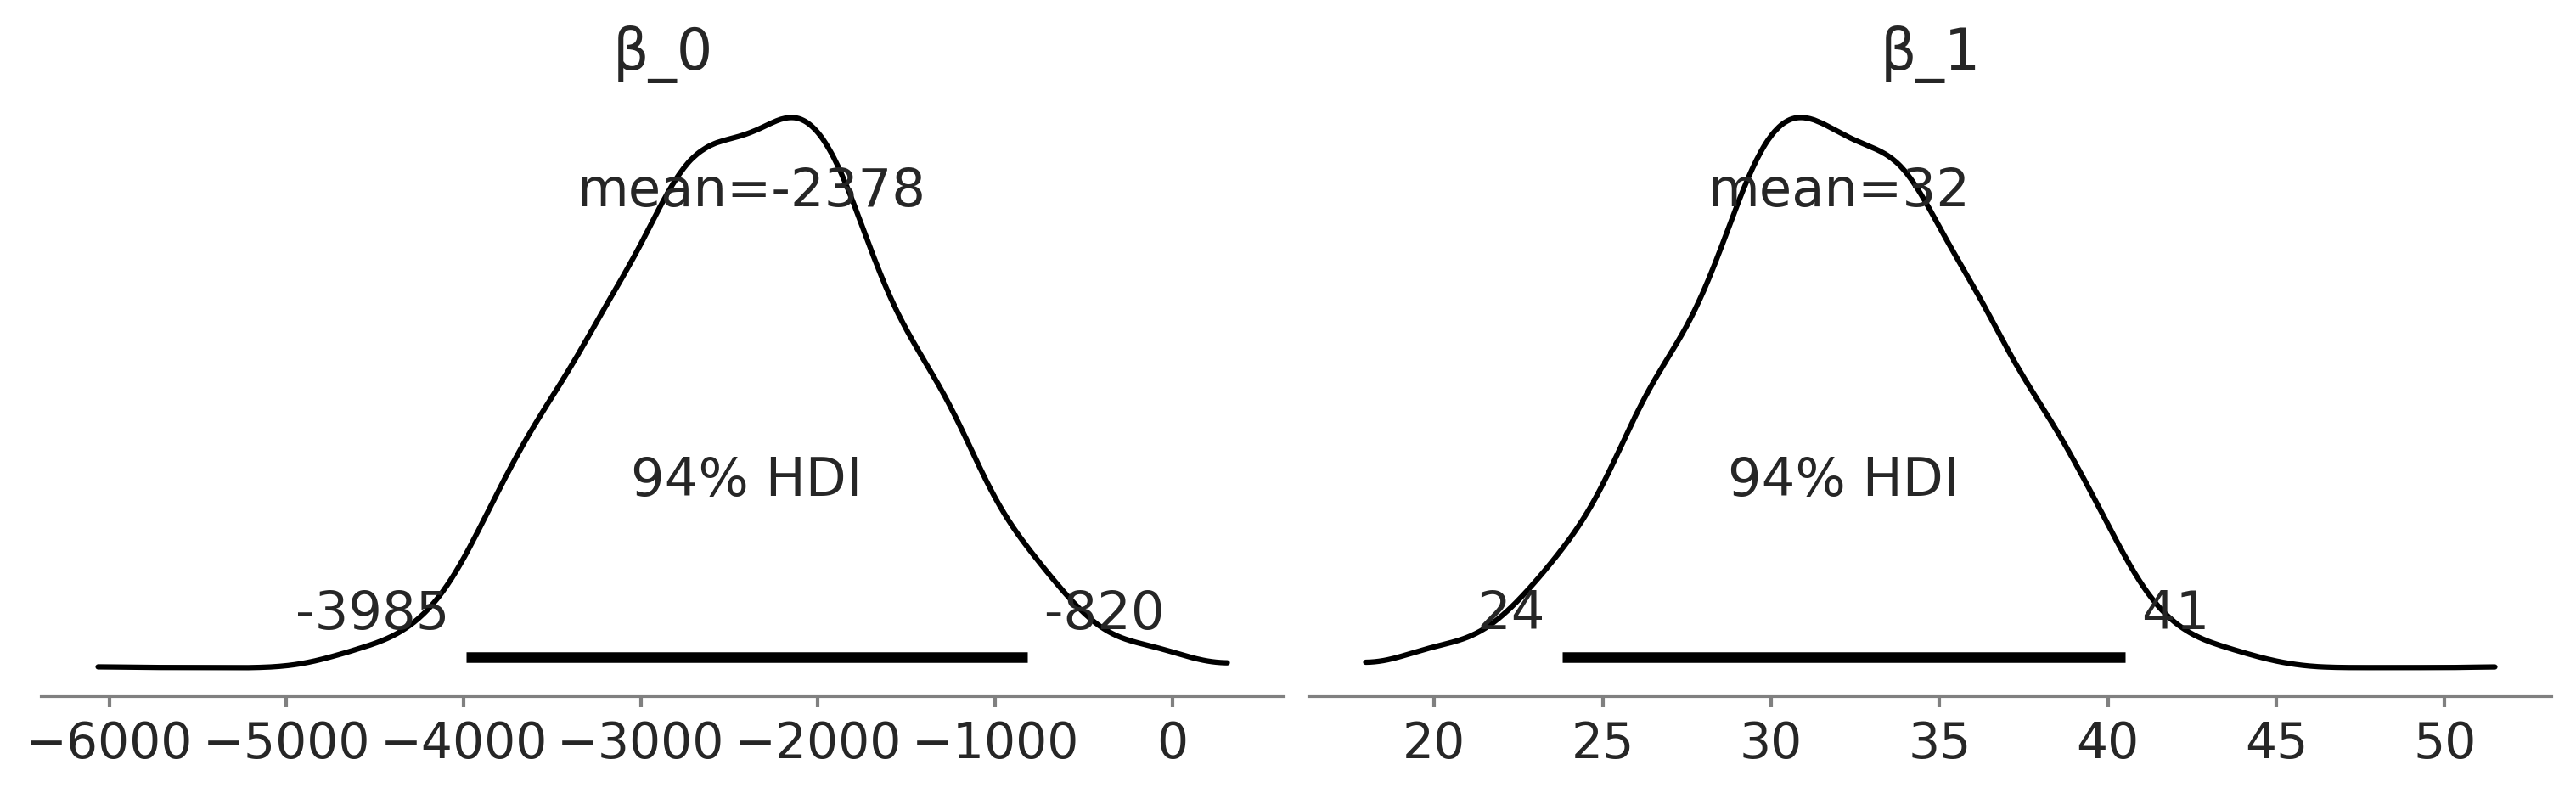

In [26]:
axes = az.plot_posterior(idata_adelie_flipper_regression, var_names = ["β_0", "β_1"], figsize=(10, 3));

plt.savefig("img/chp03/adelie_coefficient_posterior_plots")

After our sampler finishes running we can plot
{numref}`fig:adelie_coefficient_posterior_plots` which shows a full
posterior plot we can use to inspect $\beta_0$ and $\beta_1$. The
coefficient $\beta_1$ expresses that for every millimeter change of
Adelie flipper length we can nominally expect a change of 32 grams of
mass, although anywhere between 22 grams to 41 grams could reasonably
occur as well. Additionally, from
{numref}`fig:adelie_coefficient_posterior_plots` we can note how the 94%
highest density interval does not cross 0 grams. This supports our
assumption that there is a relationship between mass and flipper length.
This observation is quite useful for interpreting how flipper length and
mass correlate. However, we should be careful about not
over-interpreting the coefficients or thinking a linear model
necessarily implies a causal link. For example, if we perform a flipper
extension surgery to a penguin this will not necessarily translate into
a gain in mass, it could actually be the opposite due to stress or
impediments of this penguin to get food. The opposite relation is not
necessarily true either, providing more food to a penguin could help her
to have a larger flipper, but it could also make it just a fatter
penguin. Now focusing on $\beta_0$ however, what does it represent? From
our posterior estimate we can state that if we saw an Adelie penguin
with a 0 mm flipper length we would expect the mass of this impossible
penguin to be somewhere between -4151 and -510 grams. According to our
model this statement is true, but negative mass does not make sense.
This is not necessarily an issue, there is no rule that every parameter
in a model needs to be interpretable, nor that the model provide
reasonable prediction at every parameter value. At this point in our
journey the purpose of this particular model was to estimate the
relationship between flipper length and penguin mass and with our
posterior estimates, we have succeeded with that goal.

::: {admonition} Models: A balance between math and reality

In our penguin example it would not make sense if penguin mass was below 0 (or even close to it),
even though the model allowed it. Because we fit the model using values
for the masses that are far from 0, we should not be surprised that the
model fails if we want to extrapolate conclusions for values close to 0
or below it. A model does not necessarily have to provide sensible
predictions for all possible values, it just needs to provide sensible
predictions for the purposes that we are building it for.
:::

We started on this section surmising that incorporating a covariate
would lead to better predictions of penguin mass. We can verify this is
the case by comparing the posterior estimates of $\sigma$ from our fixed
mean model and with our linearly varying mean model in
{numref}`fig:SingleSpecies_SingleRegression_Forest_Sigma_Comparison`,
our estimate of the likelihood's standard deviation has dropped from a
mean of around $\approx 460$ grams to $\approx 380$ grams.

```{figure} figures/SingleSpecies_SingleRegression_Forest_Sigma_Comparison.png
:name: fig:SingleSpecies_SingleRegression_Forest_Sigma_Comparison
:width: 7.00in
By using the covariate of flipper length when estimating penguin mass
the magnitude of the estimated error is reduced from a mean of slightly
over 460 grams to around 380 grams. This intuitively makes sense as if
we are given information about a quantity we are estimating, we can
leverage that information to make better estimates.
```

```{figure} figures/Flipper_length_mass_regression.png
:name: fig:Flipper_length_mass_regression
:width: 7.00in
Observed Adelie data of flipper length vs mass as scatter plot, and mean
estimate of the likelihood as black line, and 94% HDI of the mean as
gray interval. Note how our mean estimate varies as flipper varies.
```          

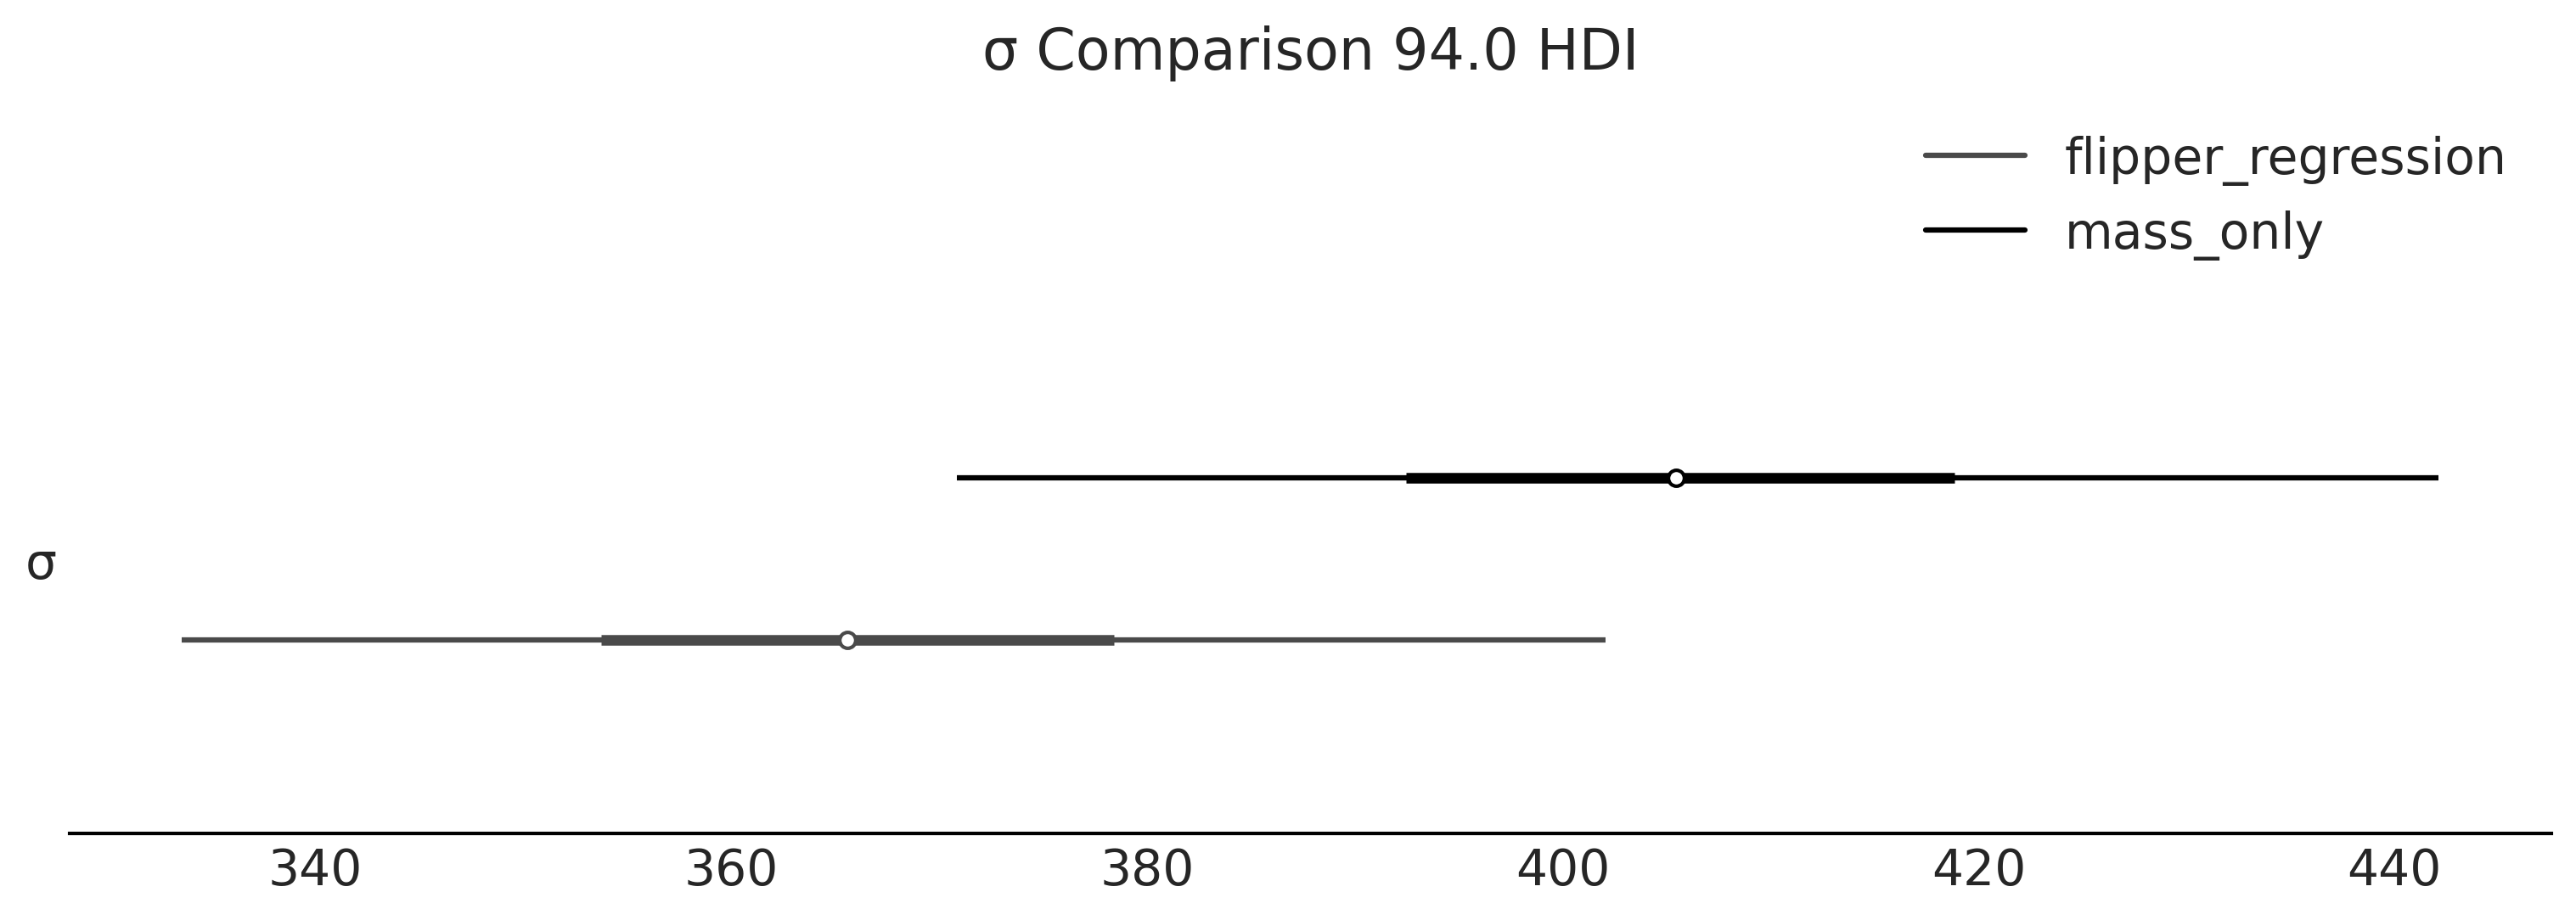

In [27]:
axes = az.plot_forest(
    [idata_adelie_mass, idata_adelie_flipper_regression],
    model_names=["mass_only", "flipper_regression"],
    var_names=["σ"], combined=True, figsize=(10, 3.5))

axes[0].set_title("σ Comparison 94.0 HDI")
plt.savefig("img/chp03/SingleSpecies_SingleRegression_Forest_Sigma_Comparison.png")

In [28]:
idata_adelie_flipper_regression.posterior["β_0"].mean().item()

-2377.984938847824

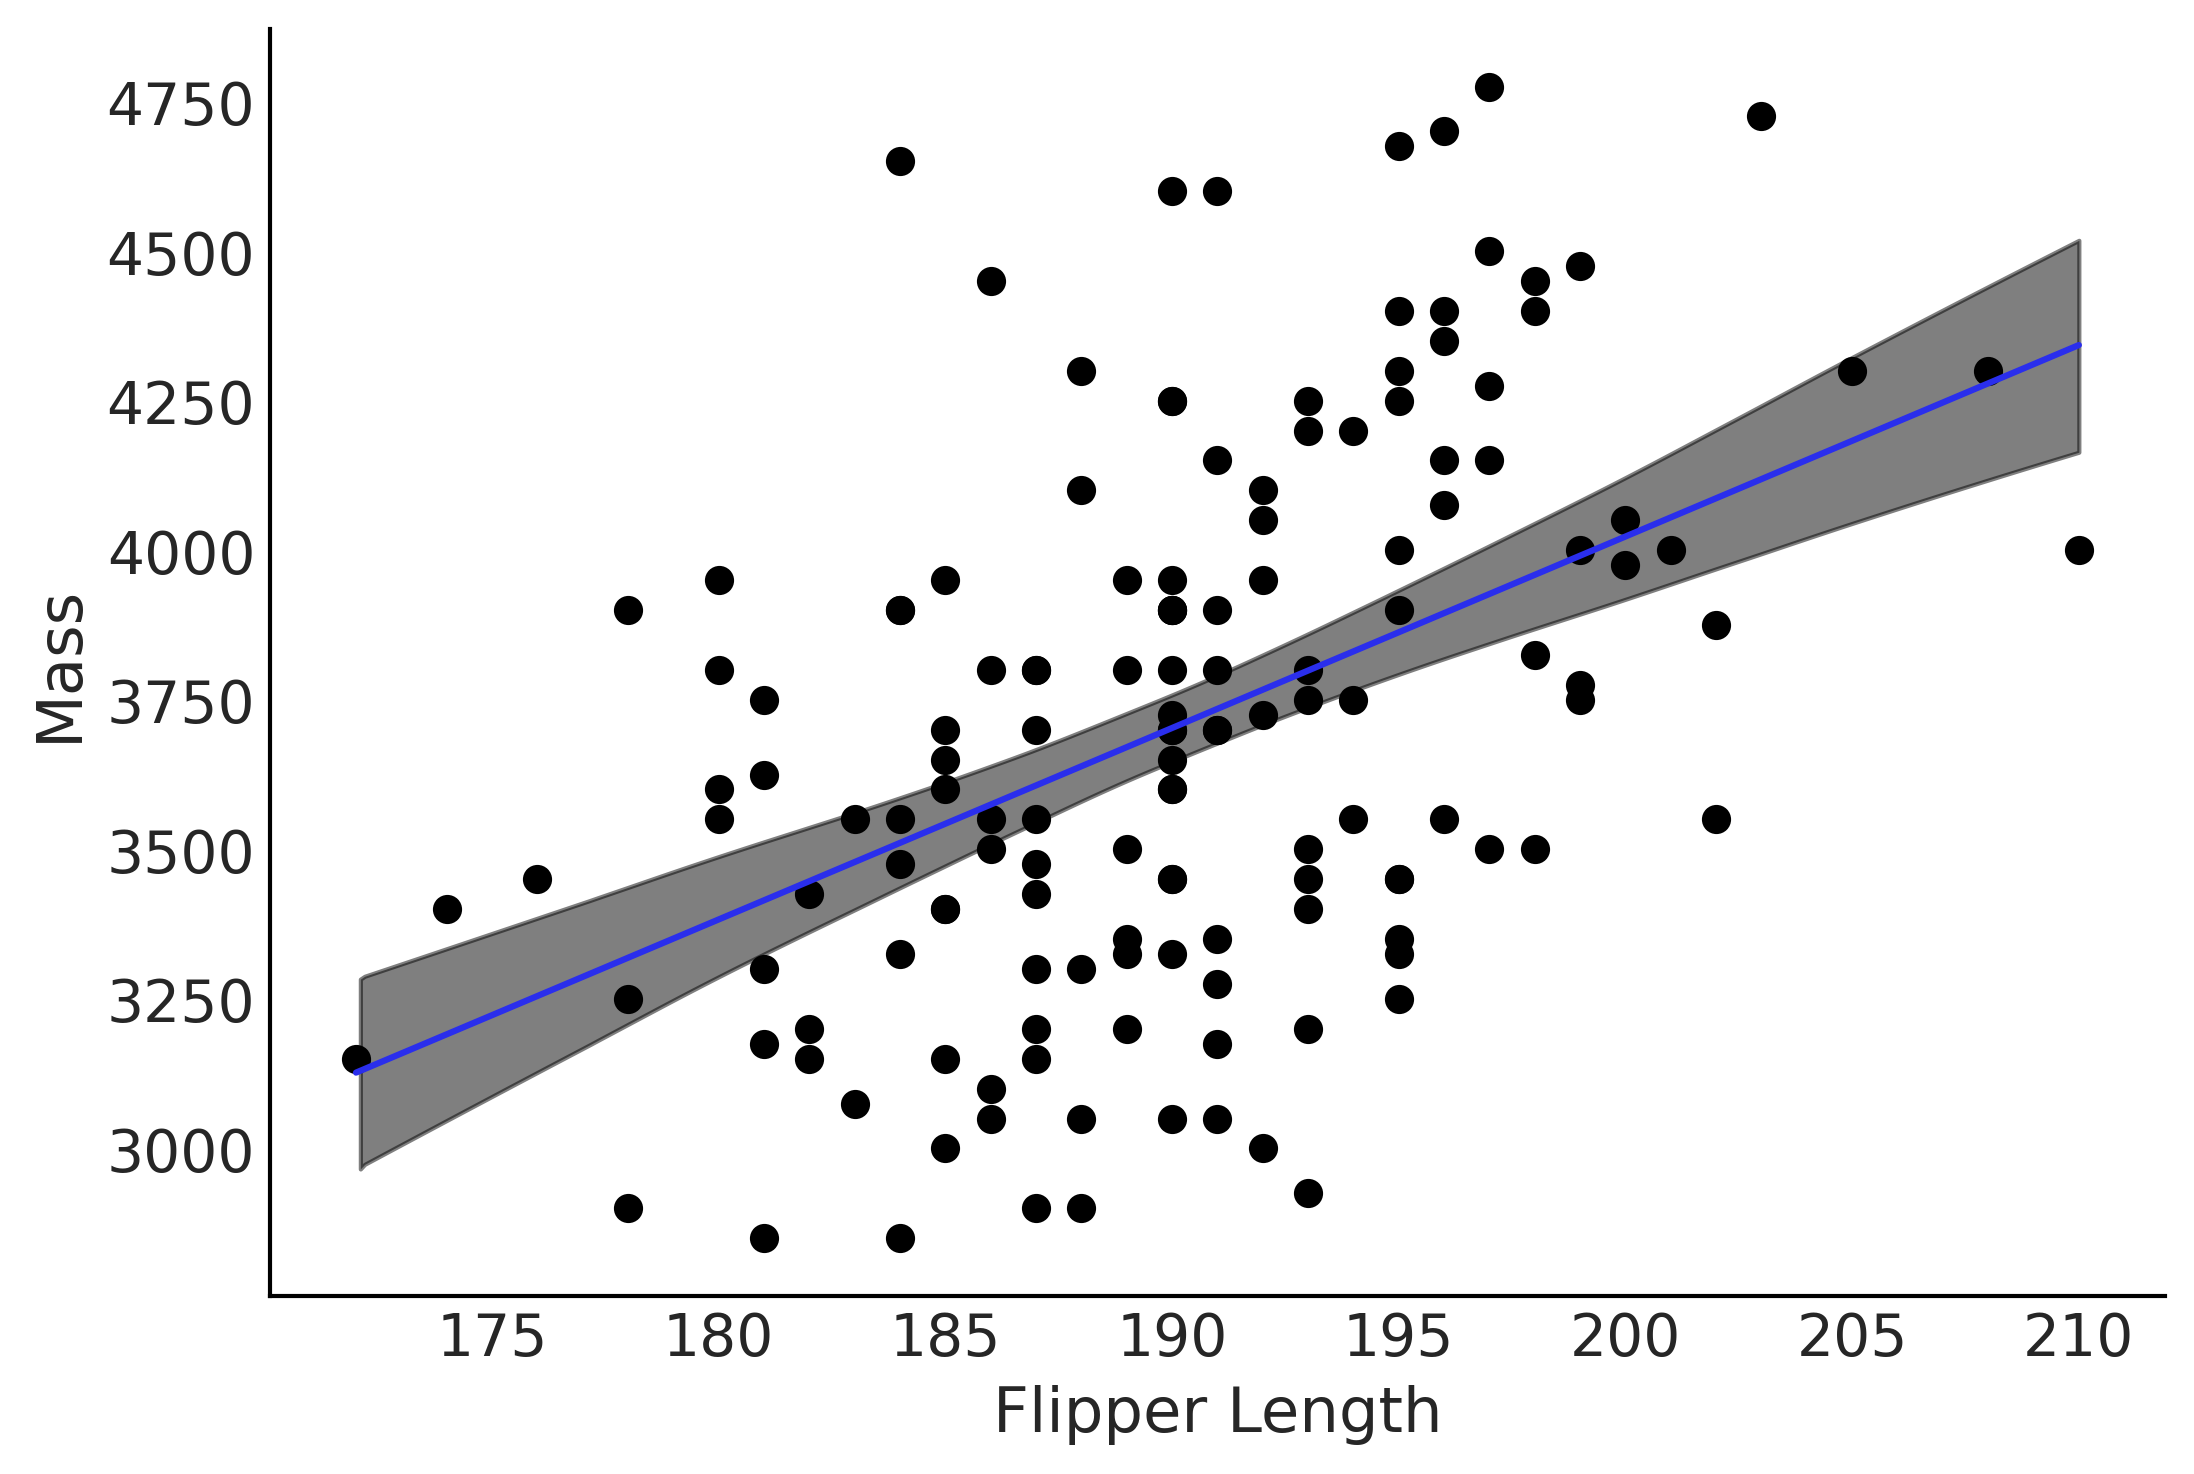

In [29]:
fig, ax = plt.subplots()
alpha_m = idata_adelie_flipper_regression.posterior["β_0"].mean().item()
beta_m = idata_adelie_flipper_regression.posterior["β_1"].mean().item()

flipper_length = np.linspace(adelie_flipper_length_obs.min(), adelie_flipper_length_obs.max(), 100)

flipper_length_mean = alpha_m + beta_m * flipper_length
ax.plot(flipper_length, flipper_length_mean, c='C4',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

ax.scatter(adelie_flipper_length_obs, adelie_mass_obs)

# Figure out how to do this from inference data
az.plot_hdi(adelie_flipper_length_obs, idata_adelie_flipper_regression.posterior['μ'], hdi_prob=0.94, color='k', ax=ax)

ax.set_xlabel('Flipper Length')
ax.set_ylabel('Mass');
plt.savefig('img/chp03/flipper_length_mass_regression.png', dpi=300)

(chp2_predictions)=

### 3.2.2 Predictions

In the {ref}`linear_regression_intro` we estimated a linear relationship
between flipper length and mass. Another use of regression is to
leverage that relationship in order to make predictions. In our case
given the flipper length of a penguin, can we predict its mass? In fact
we can. We will use our results from `model_adelie_flipper_regression`
to do so. Because in Bayesian statistics we are dealing with
distributions we do not end up with a single predicted value but instead
a distribution of possible values. That is the posterior predictive
distribution as defined in Equation
[eq:post_pred_dist](eq:post_pred_dist). In practice, more often than
not, we will not compute our predictions analytically but we will use a
PPL to estimate them using our posterior samples. For example, if we had
a penguin of average flipper length and wanted to predict the likely
mass using `PyMC3` we would write Code Block
[penguins_ppd](penguins_ppd):

```{code-block} python
:name: penguins_ppd
:caption: penguins_ppd

with model_adelie_flipper_regression:
    # Change the underlying value to the mean observed flipper length
    # for our posterior predictive samples
    pm.set_data({"adelie_flipper_length": [adelie_flipper_length_obs.mean()]})
    posterior_predictions = pm.sample_posterior_predictive(
        inf_data_adelie_flipper_regression.posterior, var_names=["mass", "μ"])
```

In [30]:
with model_adelie_flipper_regression:
    # Change the underlying value to the mean observed flipper length
    # for our posterior predictive samples
    pm.set_data({"adelie_flipper_length": [adelie_flipper_length_obs.mean()]})
    posterior_predictions = pm.sample_posterior_predictive(
        idata_adelie_flipper_regression.posterior, var_names=["mass", "μ"])

Sampling: [mass]


Output()

In the first line of Code Block
[penguins_ppd](penguins_ppd) we fix the value of our
flipper length to the average observed flipper length. Then using the
regression model `model_adelie_flipper_regression`, we can generate
posterior predictive samples of the mass at that fixed value. In
{numref}`fig:Flipper_length_mass_posterior_predictive` we plot the
posterior predictive distribution of the mass for penguins of average
flipper length, along the posterior of the mean.

```{figure} figures/Flipper_length_mass_posterior_predictive.png
:name: fig:Flipper_length_mass_posterior_predictive
:width: 7.00in
The posterior distribution of the mean, $\mu$, evaluated at the mean
flipper length in blue and the posterior predictive distribution
evaluated at the mean flipper length in black. The black curve is wider
as it describes the distribution of the predicted data (for a given
flipper length), while the blue curve represents the distribution of
just the mean of the predicted data.
```

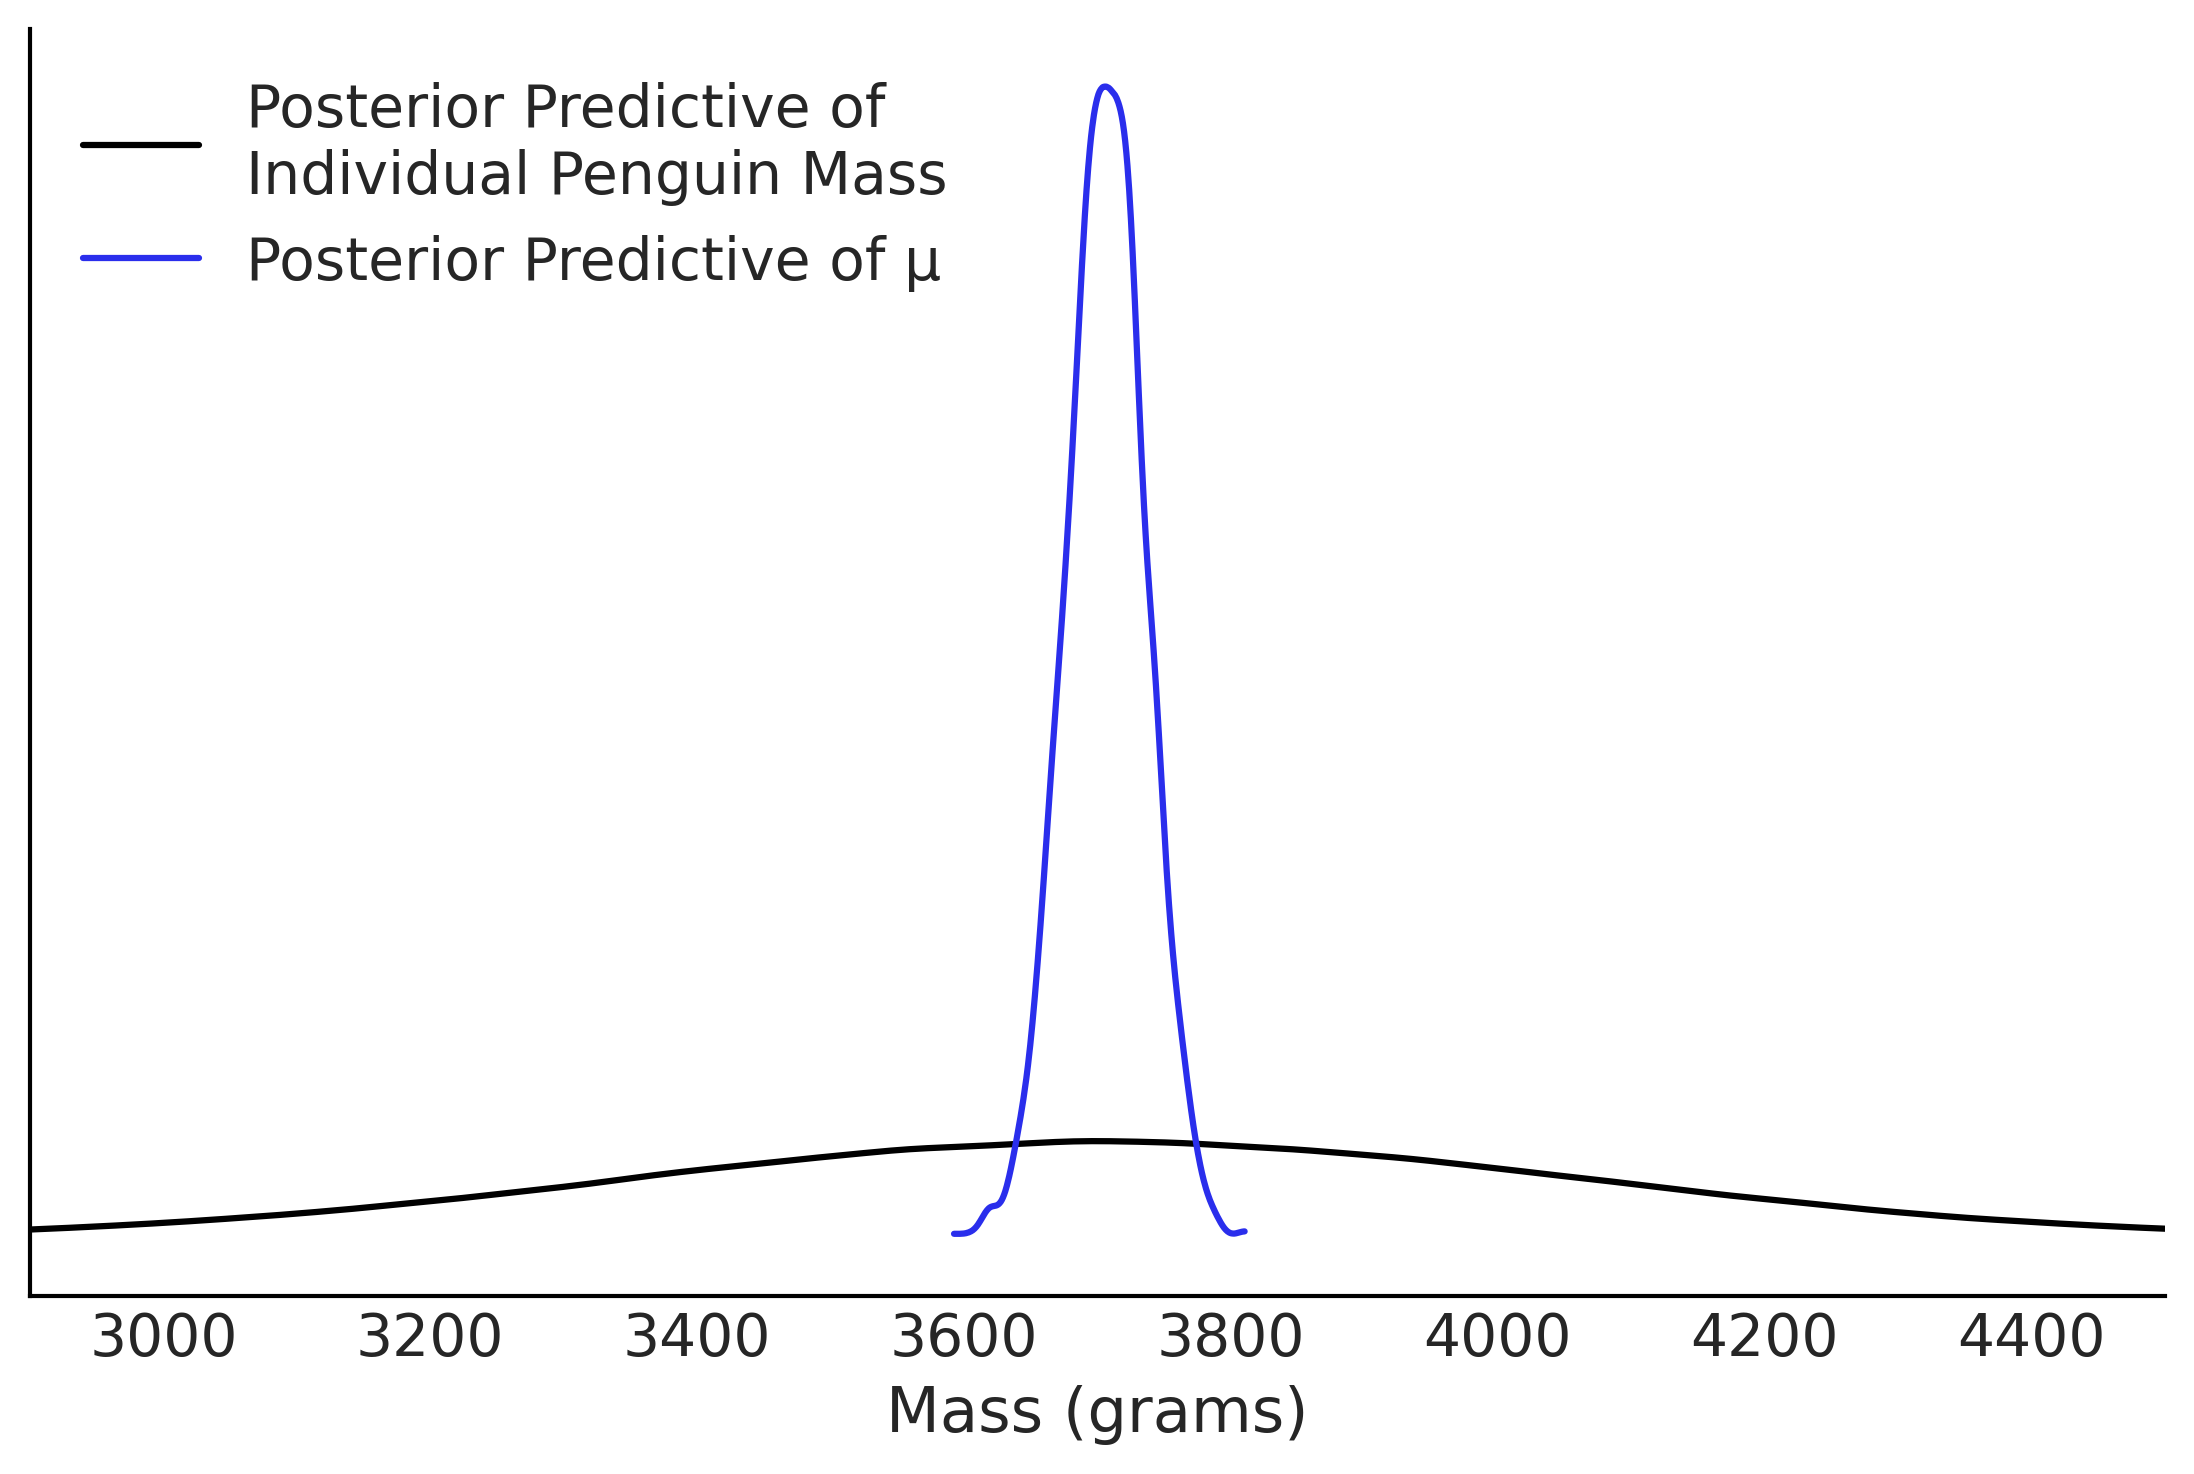

In [31]:
fig, ax = plt.subplots()
az.plot_dist(posterior_predictions.posterior_predictive["mass"],
             label="Posterior Predictive of \nIndividual Penguin Mass", ax=ax)
az.plot_dist(posterior_predictions.posterior_predictive["μ"], label="Posterior Predictive of μ", color="C4", ax=ax)
ax.set_xlim(2900, 4500);
ax.legend(loc=2)
ax.set_xlabel("Mass (grams)")
ax.set_yticks([])
plt.savefig('img/chp03/flipper_length_mass_posterior_predictive.png', dpi=300)

In short not only can we use our model in Code Block
[non_centered_regression](non_centered_regression) to
estimate the relationship between flipper length and mass, we also can
obtain an estimate of the penguin mass at any arbitrary flipper length.
In other words we can use the estimated $\beta_1$ and $\beta_0$
coefficients to make predictions of the mass of unseen penguins of any
flipper length using posterior predictive distributions.

As such, the posterior predictive distribution is an especially powerful
tool in a Bayesian context as it let us predict not just the most likely
value, but a distribution of plausible values incorporating the
uncertainty about our estimates, as seen from Equation
[eq:post_pred_dist](eq:post_pred_dist).

(centering)=

### 3.2.3 Centering

In [32]:
adelie_flipper_length_obs = penguins.loc[adelie_mask, "flipper_length_mm"].values
adelie_flipper_length_c = adelie_flipper_length_obs - adelie_flipper_length_obs.mean()

#### PyMC Centered Model

In [33]:
with pm.Model() as model_adelie_flipper_regression:
    σ = pm.HalfStudentT("σ", 100, 2000)
    β_1 = pm.Normal("β_1", 0, 4000)
    β_0 = pm.Normal("β_0", 0, 4000)
    μ = pm.Deterministic("μ", β_0 + β_1*adelie_flipper_length_c)

    mass = pm.Normal("mass", mu=μ, sigma=σ, observed = adelie_mass_obs)

    # Need to remove this one I find bug
    inf_data_adelie_flipper_length_c = pm.sample(random_seed=0)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β_1, β_0]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


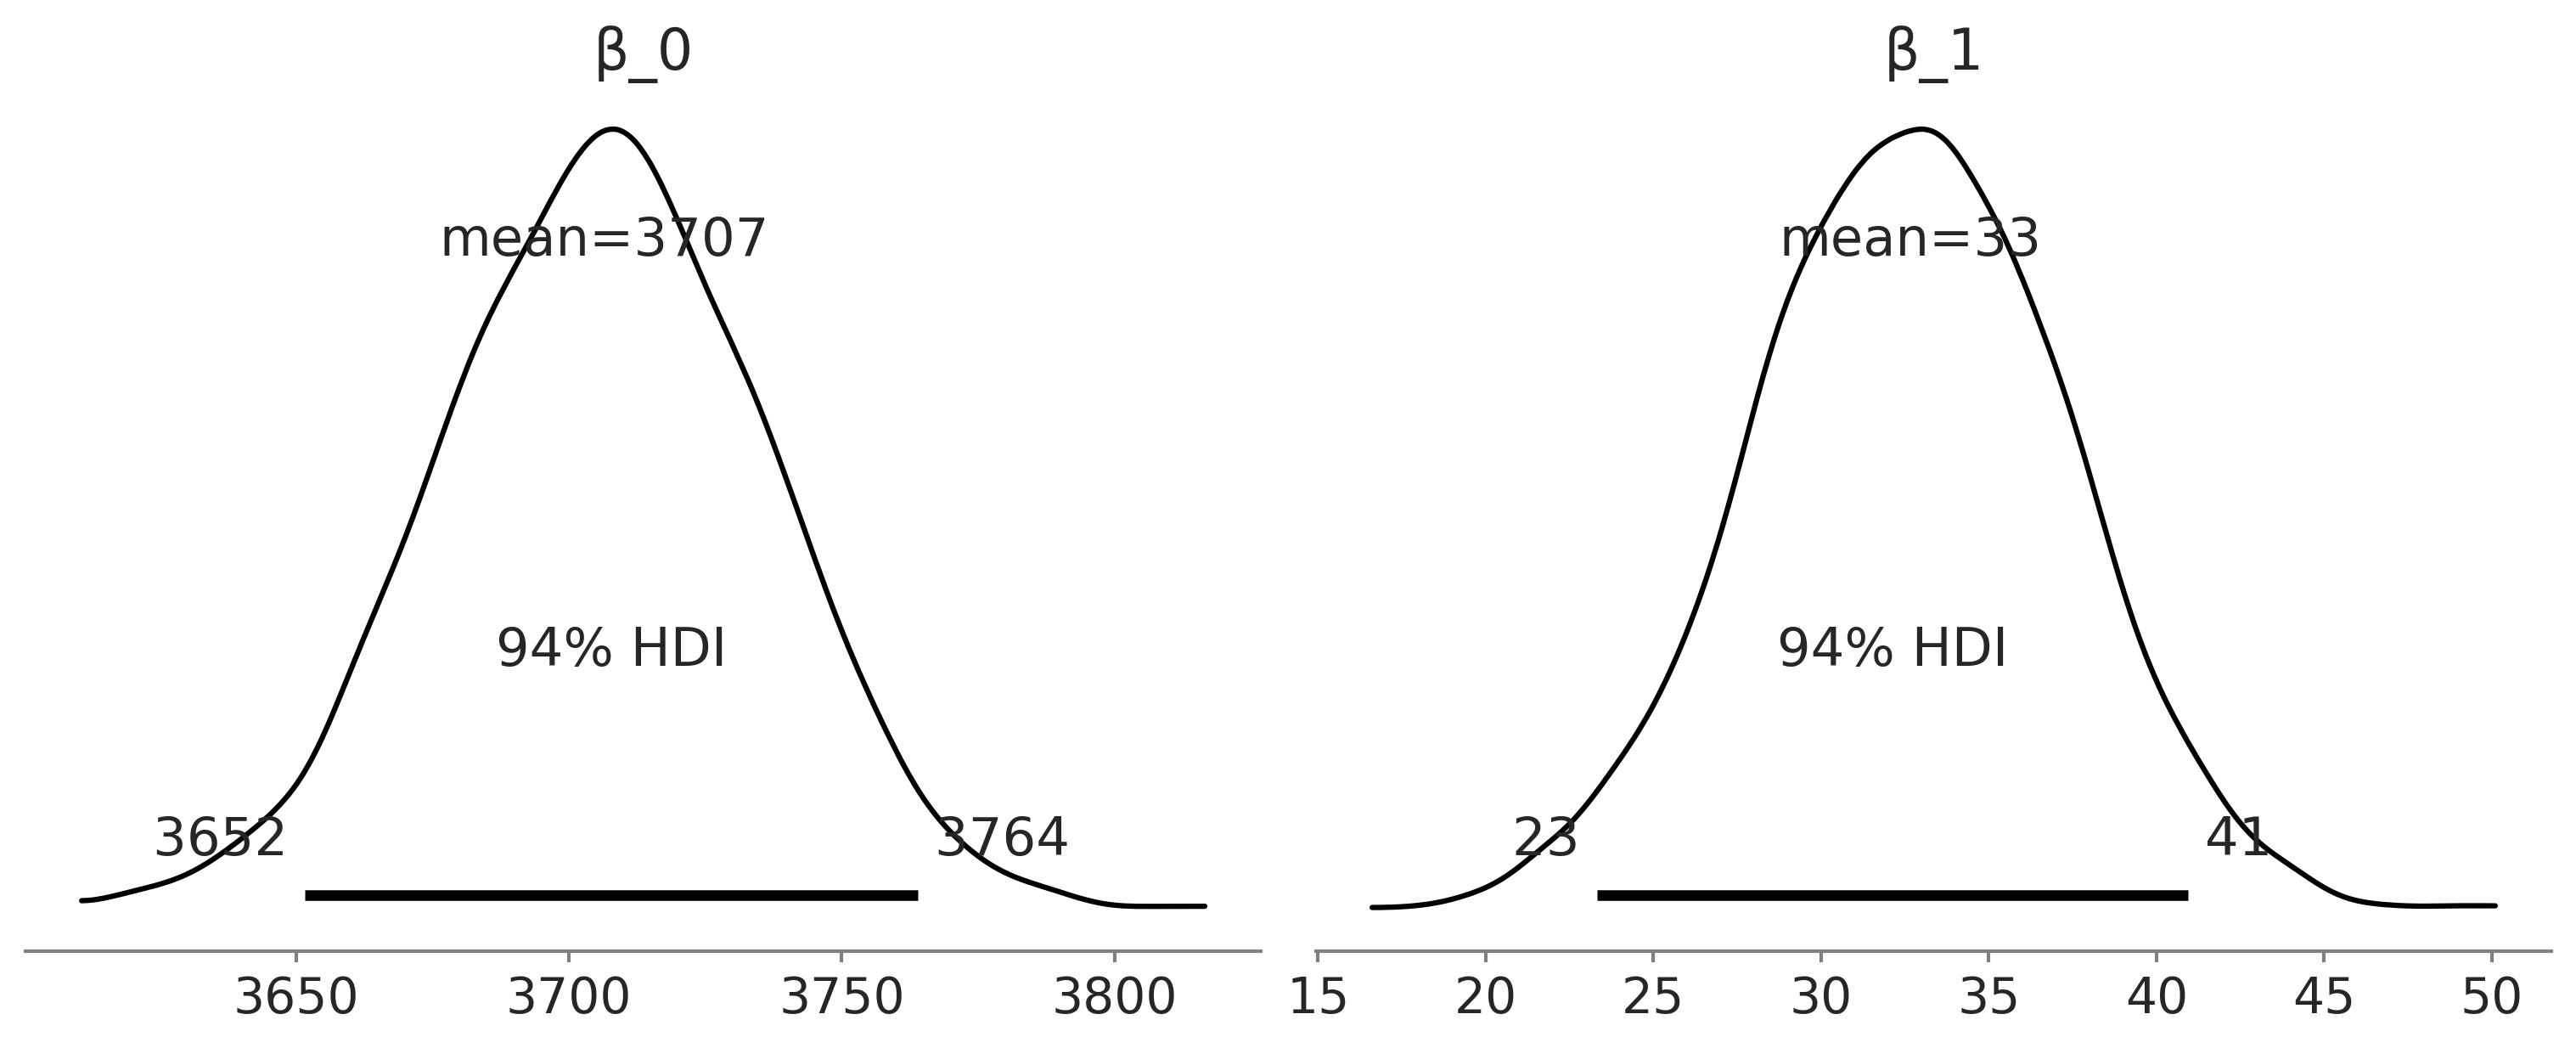

In [34]:
az.plot_posterior(inf_data_adelie_flipper_length_c, var_names = ["β_0", "β_1"], figsize=(10, 4));
plt.savefig("img/chp03/singlespecies_multipleregression_centered.png")

Our model in Code Block
[non_centered_regression](non_centered_regression) worked
well for estimating the correlation between flipper length and penguin
mass, and in predicting the mass of penguins at a given flipper length.
Unfortunately with the data and the model provided our estimate of
$\beta_0$ was not particularly useful. However, we can use a
transformation to make $\beta_0$ more interpretable. In this case we
will opt for a centering transformation, which takes a set of values and
centers its mean value at zero as shown in Code Block
[flipper_centering](flipper_centering).

```{code-block} python
:name: flipper_centering
:caption: flipper_centering

adelie_flipper_length_c = (adelie_flipper_length_obs -
                           adelie_flipper_length_obs.mean())
```

In [35]:
adelie_flipper_length_c = adelie_flipper_length_obs - adelie_flipper_length_obs.mean()

With our now centered covariate let us fit our model again, this time
using TFP.

```{code-block} python
:name: tfp_penguins_centered_predictor
:caption: tfp_penguins_centered_predictor

def gen_adelie_flipper_model(adelie_flipper_length):
    adelie_flipper_length = tf.constant(adelie_flipper_length, tf.float32)

    @tfd.JointDistributionCoroutine
    def jd_adelie_flipper_regression():
        σ = yield root(
            tfd.HalfStudentT(df=100, loc=0, scale=2000, name="sigma"))
        β_1 = yield root(tfd.Normal(loc=0, scale=4000, name="beta_1"))
        β_0 = yield root(tfd.Normal(loc=0, scale=4000, name="beta_0"))
        μ = β_0[..., None] + β_1[..., None] * adelie_flipper_length
        mass = yield tfd.Independent(
            tfd.Normal(loc=μ, scale=σ[..., None]),
            reinterpreted_batch_ndims=1,
            name="mass")

    return jd_adelie_flipper_regression

# If use non-centered predictor, this will give the same model as
# model_adelie_flipper_regression
jd_adelie_flipper_regression = gen_adelie_flipper_model(
    adelie_flipper_length_c)

mcmc_samples, sampler_stats = run_mcmc(
    1000, jd_adelie_flipper_regression, n_chains=4, num_adaptation_steps=1000,
    mass=tf.constant(adelie_mass_obs, tf.float32))

inf_data_adelie_flipper_length_c = az.from_dict(
    posterior={
        k:np.swapaxes(v, 1, 0)
        for k, v in mcmc_samples._asdict().items()},
    sample_stats={
        k:np.swapaxes(sampler_stats[k], 1, 0)
        for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]}
)
```

```{figure} figures/SingleSpecies_MultipleRegression_Centered.png
:name: fig:SingleSpecies_multipleRegression_Centered
:width: 7.00in
Estimates of coefficients from Code Block
[tfp_penguins_centered_predictor](tfp_penguins_centered_predictor).
Notice that the distribution of $beta\_1$ is the same as in
{numref}`fig:adelie_coefficient_posterior_plots`, but the distribution
of $beta\_0$ has shifted. Because we centered the observations around
the mean of flipper length $beta\_0$ now represents the mass
distribution of the average flipper penguin.
```

In [36]:
def gen_adelie_flipper_model(adelie_flipper_length):
    adelie_flipper_length = tf.constant(adelie_flipper_length, tf.float32)

    @tfd.JointDistributionCoroutine
    def jd_adelie_flipper_regression():
        σ = yield root(tfd.HalfStudentT(df=100, loc=0, scale=2000, name='sigma'))
        β_1 = yield root(tfd.Normal(loc=0, scale=4000, name='beta_1'))
        β_0 = yield root(tfd.Normal(loc=0, scale=4000, name='beta_0'))
        μ = β_0[..., None] + β_1[..., None] * adelie_flipper_length
        mass = yield tfd.Independent(
            tfd.Normal(loc=μ, scale=σ[..., None]),
            reinterpreted_batch_ndims=1,
            name='mass')

    return jd_adelie_flipper_regression


# Use non-centered predictor, this gives the same model as
# model_adelie_flipper_regression
jd_adelie_flipper_regression = gen_adelie_flipper_model(
    adelie_flipper_length_obs)

# Use centered predictor
jd_adelie_flipper_regression = gen_adelie_flipper_model(
    adelie_flipper_length_c)

mcmc_samples, sampler_stats = run_mcmc(
    1000, jd_adelie_flipper_regression, n_chains=4, num_adaptation_steps=1000,
    mass=tf.constant(adelie_mass_obs, tf.float32))

inf_data_adelie_flipper_length_c = az.from_dict(
    posterior={
        k:np.swapaxes(v, 1, 0)
        for k, v in mcmc_samples._asdict().items()},
    sample_stats={
        k:np.swapaxes(sampler_stats[k], 1, 0)
        for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]
    }
)

2025-01-24 23:45:56.738856: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert


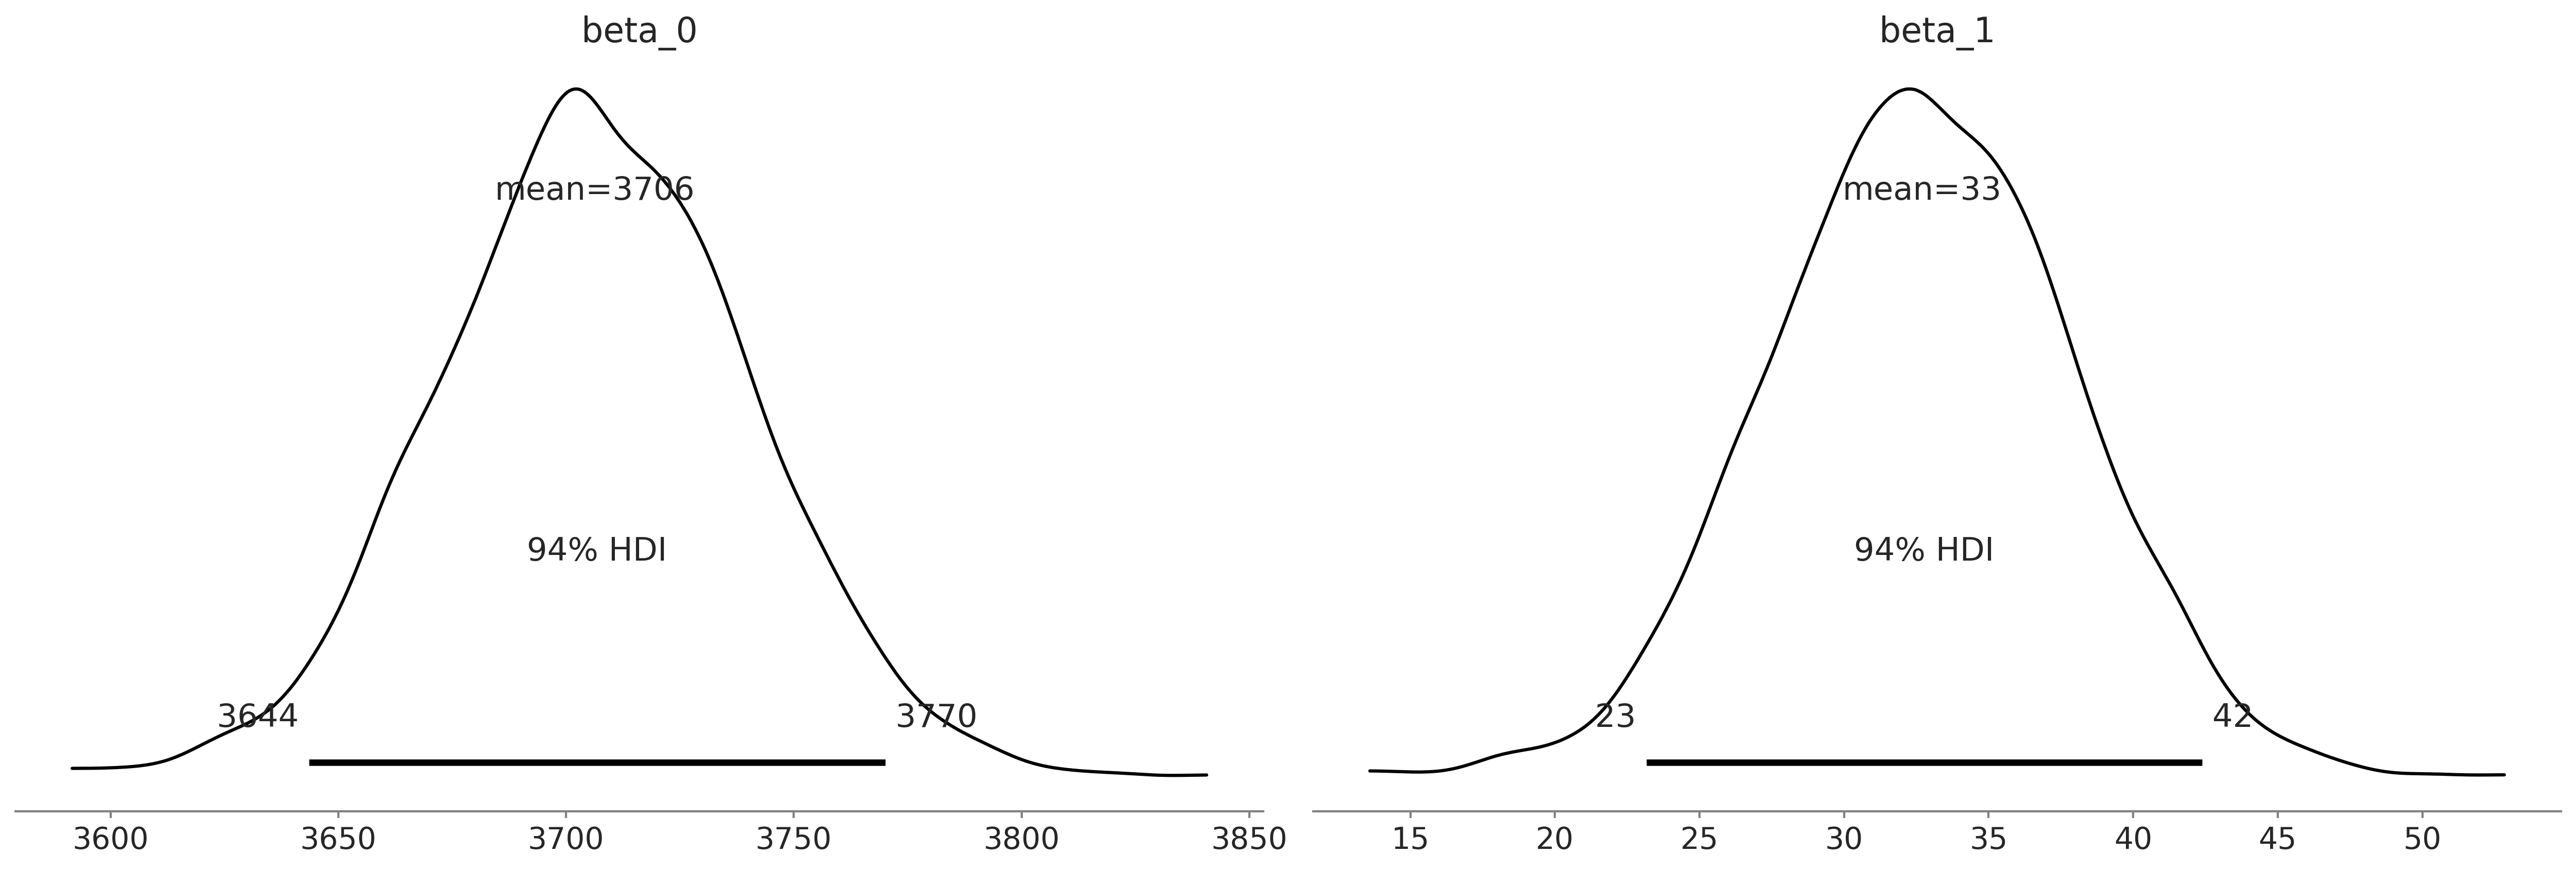

In [37]:
az.plot_posterior(inf_data_adelie_flipper_length_c, var_names = ["beta_0", "beta_1"]);

The mathematical model we defined in Code Block
[tfp_penguins_centered_predictor](tfp_penguins_centered_predictor)
is identical to the PyMC3 model `model_adelie_flipper_regression` from
Code Block
[non_centered_regression](non_centered_regression), with
sole difference being the centering of the predictor. PPL wise however,
the structure of TFP necessitates the addition of `tensor_x[..., None]`
in various lines to extend a batch of scalars so that they are
broadcastable with a batch of vectors. Specifically `None` appends a new
axis, which could also be done using `np.newaxis` or `tf.newaxis`. We
also wrap the model in a function so we can easily condition on
different predictors. In this case we use the centered flipper length,
but could also use the non-centered predictor which will yield similar
results to our previous model.

When we plot our coefficients again, $\beta_1$ is the same as our PyMC3
model but the distribution of $\beta_0$ has changed. Since we have
centered our input data on its mean, the distribution of $\beta_0$ is
the same as our prediction for the group mean with the non-centered
dataset. By centering the data we now can directly interpret $\beta_0$
as the distribution of mean masses for Adelie penguins with a mean
flipper length. The idea of transforming the input variables can also be
performed at arbitrary values of choice. For example, we could subtract
out the minimum flipper length and fit our model. In this transformation
this would change the interpretation $\beta_0$ to the distribution of
means for the smallest observed flipper length. For a greater discussion
of transformations in linear regression we recommend Applied Regression
Analysis and Generalized Linear Models {cite:p}`fox_fox_2016`.

(multiple-linear-regression)=

## 3.3 Multiple Linear Regression

In many species there is a dimorphism, or difference, between different
sexes. The study of sexual dimorphism in penguins actually was the
motivating factor for collecting the Palmer Penguin dataset
{cite:p}`gorman_williams_fraser_2014`. To study penguin dimorphism more closely
let us add a second covariate, this time sex, encoding it as a
categorical variable and seeing if we can estimate a penguins mass more
precisely.

```{code-block} python
:name: penguin_mass_multi
:caption: penguin_mass_multi

# Binary encoding of the categorical predictor
sex_obs = penguins.loc[adelie_mask ,"sex"].replace({"male":0, "female":1})

with pm.Model() as model_penguin_mass_categorical:
    σ = pm.HalfStudentT("σ", 100, 2000)
    β_0 = pm.Normal("β_0", 0, 3000)
    β_1 = pm.Normal("β_1", 0, 3000)
    β_2 = pm.Normal("β_2", 0, 3000)

    μ = pm.Deterministic(
        "μ", β_0 + β_1 * adelie_flipper_length_obs + β_2 * sex_obs)

    mass = pm.Normal("mass", mu=μ, sigma=σ, observed=adelie_mass_obs)

    inf_data_penguin_mass_categorical = pm.sample(
        target_accept=.9, return_inferencedata=True)
```

In [38]:
# Binary encoding of the categorical predictor
sex_obs = penguins.loc[adelie_mask ,"sex"].replace({"male":0, "female":1})

with pm.Model() as model_penguin_mass_categorical:
    σ = pm.HalfStudentT("σ", 100, 2000)
    β_0 = pm.Normal("β_0", 0, 3000)
    β_1 = pm.Normal("β_1", 0, 3000)
    β_2 = pm.Normal("β_2", 0, 3000)

    μ = pm.Deterministic(
        "μ", β_0 + β_1 * adelie_flipper_length_obs + β_2 * sex_obs)

    mass = pm.Normal("mass", mu=μ, sigma=σ, observed=adelie_mass_obs)

    inf_data_penguin_mass_categorical = pm.sample(target_accept=.9)

/tmp/ipykernel_252935/3861136726.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sex_obs = penguins.loc[adelie_mask ,"sex"].replace({"male":0, "female":1})
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β_0, β_1, β_2]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


You will notice a new parameter, $\beta_{2}$ contributing to the value
of $\mu$. As sex is a categorical predictor (in this example just female
or male), we encode it as 1 and 0, respectively. For the model this
means that the value of $\mu$, for females, is a sum over 3 terms while
for males is a sum of two terms (as the $\beta_2$ term will zero out).

```{figure} figures/adelie_sex_coefficient_posterior.png
:name: fig:adelie_sex_coefficient_posterior
:width: 7.00in
Estimate of coefficient for sex covariate, $\beta_{2}$ in model. As male
is encoded as 0, and female is encoded as 1, this indicates the
additional mass we would expect between a male and female Adelie penguin
with the same flipper length.
```

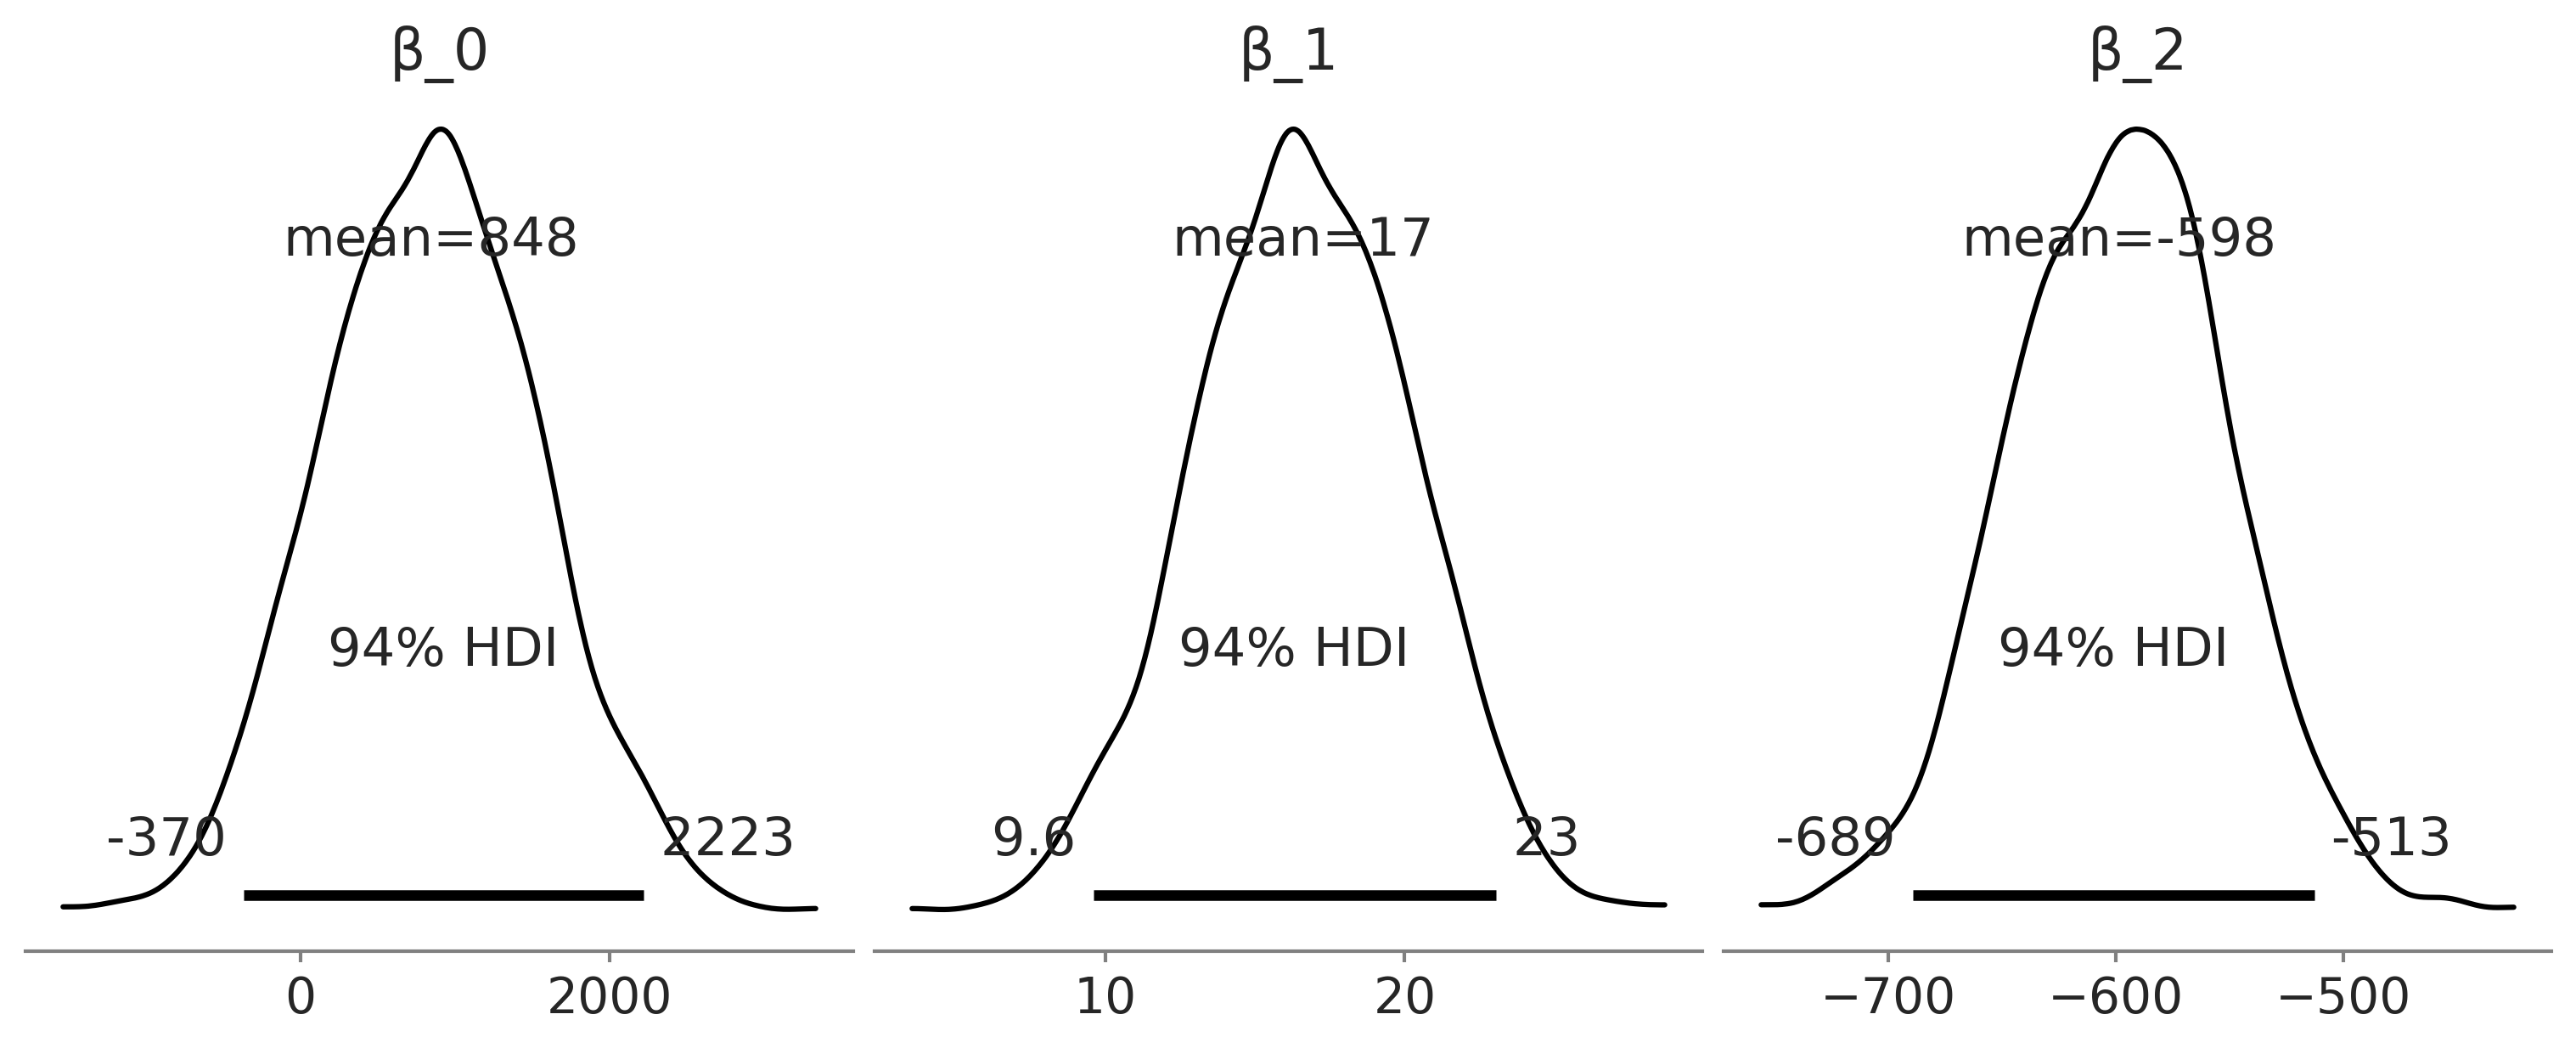

In [39]:
az.plot_posterior(inf_data_penguin_mass_categorical, var_names =["β_0", "β_1", "β_2"], figsize=(10, 4))
plt.savefig("img/chp03/adelie_sex_coefficient_posterior.png")

In [40]:
az.summary(inf_data_penguin_mass_categorical, var_names=["β_0","β_1","β_2", "σ"])

mean       sd   hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
β_0  848.183  691.187 -369.597  2223.167     19.467   13.769    1260.0   
β_1   16.605    3.588    9.590    23.041      0.101    0.072    1273.0   
β_2 -598.322   47.199 -689.078  -512.774      1.093    0.774    1868.0   
σ    274.064   14.617  246.547   300.872      0.297    0.210    2401.0   

     ess_tail  r_hat  
β_0    1854.0    1.0  
β_1    1819.0    1.0  
β_2    2027.0    1.0  
σ      2262.0    1.0

::: {admonition} Syntactic Linear Sugar

Linear models are so widely used that specialized
syntax, methods, and libraries have been written just for regression.
One such library is Bambi (BAyesian Model-Building
Interface{cite:p}`capretto2020`). Bambi is a Python package for fitting
generalized linear hierarchical models using a formula-based syntax,
similar to what one might find in R packages, like lme4 {cite:p}`lme4`, nlme
{cite:p}`nlme`, rstanarm {cite:p}`gabry_goodrich_2020` or brms {cite:p}`brms`). Bambi uses
PyMC3 underneath and provides a higher level API. To write the same
model, if disregarding the priors[^4] as the one in Code Block
[penguin_mass_multi](penguin_mass_multi) in Bambi we would
write:

```{code-block} python
:name: bambi_categorical
:caption: bambi_categorical

import bambi as bmb
model = bmb.Model("body_mass_g ~ flipper_length_mm + sex",
                  penguins[adelie_mask])
trace = model.fit()
```

The priors are automatically assigned if not provided, as is the case in
the code example above. Internally, Bambi stores virtually all objects
generated by PyMC3, making it easy for users to retrieve, inspect, and
modify those objects. Additionally Bambi returns an `az.InferenceData`
object which can be directly used with ArviZ.
:::

Since we have encoded male as 0 this posterior from
`model_penguin_mass_categorical` estimates the difference in mass
compared to a female Adelie penguin *with the same flipper length*. This
last part is quite important, by adding a second covariate we now have a
multiple linear regression and we must use more caution when
interpreting the coefficients. In this case, the coefficients provides
the relationship of a covariate into the response variable, **if** all
other covariates are held constant [^5].

```{figure} figures/Single_Species_Categorical_Regression.png
:name: fig:Single_Species_Categorical_Regression
:width: 7.00in
Multiple regression for flipper length versus mass with male and female
Adelie penguins coded as a categorical covariate. Note how the
difference mass between male and female penguins is constant at every
flipper length. This difference is equivalent to the magnitude of the
$\beta_2$ coefficient.
```

[^4]: If wanted exactly the same model we could specify the priors in
    Bambi, not shown here. For our purposes however, the models are
    "close enough\".

[^5]: You can also parse the design matrix differently so that
    covariates represents the contrast between 2 categories within a
    column.

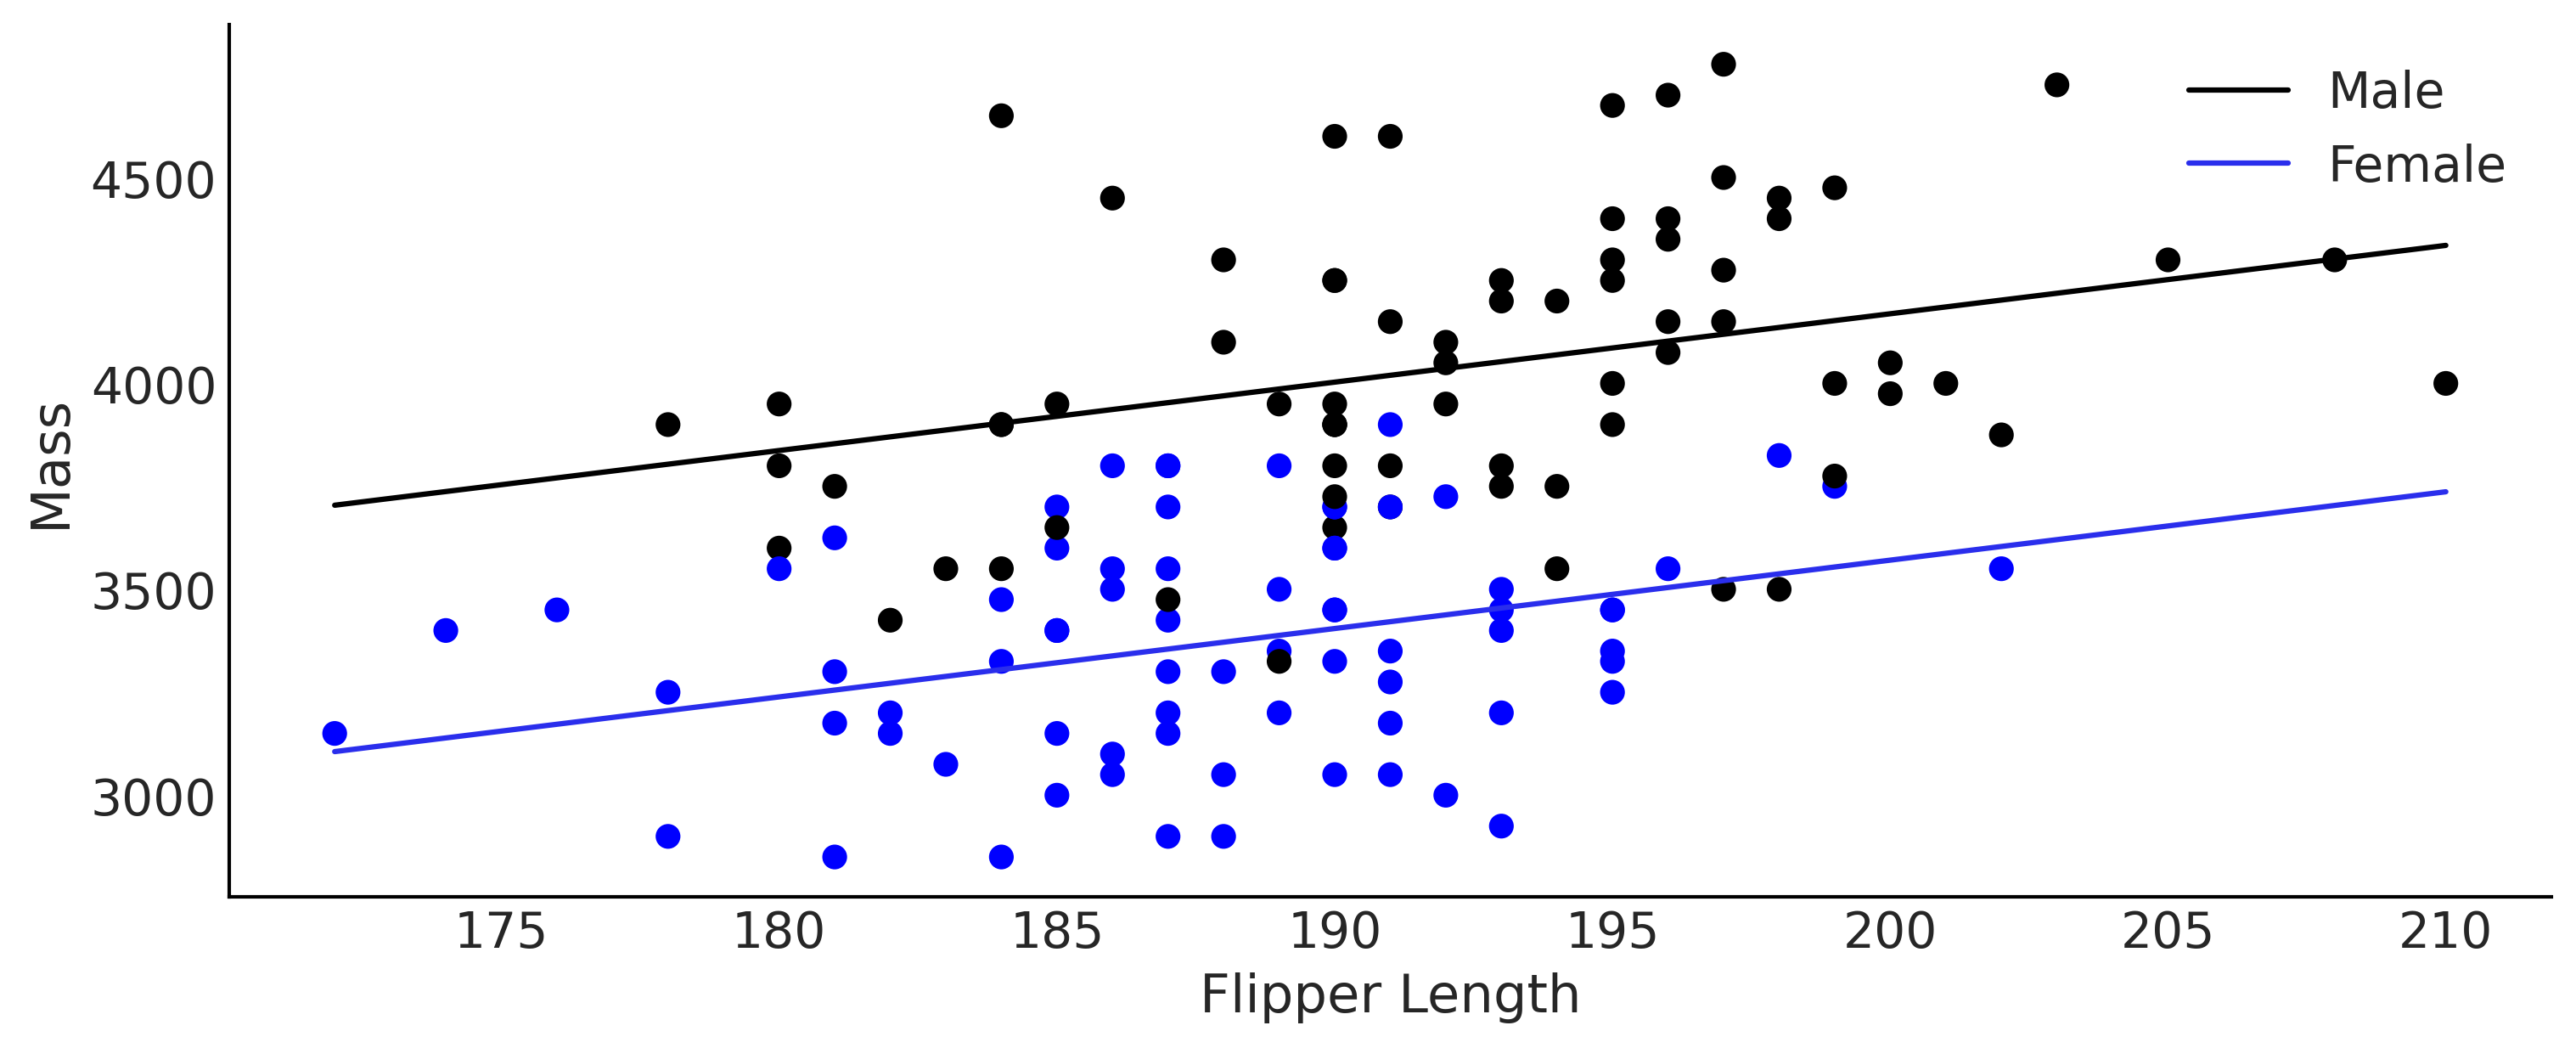

In [41]:
# Fix colors
fig, ax = plt.subplots(figsize=(10, 4))
alpha_1 = inf_data_penguin_mass_categorical.posterior["β_0"].mean().item()
beta_1 = inf_data_penguin_mass_categorical.posterior["β_1"].mean().item()
beta_2 = inf_data_penguin_mass_categorical.posterior["β_2"].mean().item()


flipper_length = np.linspace(adelie_flipper_length_obs.min(), adelie_flipper_length_obs.max(), 100)

mass_mean_male = alpha_1 + beta_1 * flipper_length
mass_mean_female = alpha_1 + beta_1 * flipper_length + beta_2

ax.plot(flipper_length, mass_mean_male,
         label="Male")

ax.plot(flipper_length, mass_mean_female, c='C4',
         label="Female")

ax.scatter(adelie_flipper_length_obs, adelie_mass_obs, c=[{0:"k", 1:"b"}[code] for code in sex_obs.values])

# Figure out how to do this from inference data
#az.plot_hpd(adelie_flipper_length, trace.get_values(varname="μ"), credible_interval=0.94, color='k', ax=ax)

ax.set_xlabel('Flipper Length')
ax.set_ylabel('Mass');
ax.legend()
plt.savefig("img/chp03/single_species_categorical_regression.png")

We again can compare the standard deviations across our three models in
{numref}`fig:SingleSpecies_multipleRegression_Forest_Sigma_Comparison`
to see if we have reduced uncertainty in our estimate and once again the
additional information has helped to improve the estimate. In this case
our estimate of $\sigma$ has dropped a mean of 462 grams in our no
covariate model defined in Code Block
[penguin_mass](penguin_mass) to a mean value 298 grams
from the linear model defined in Code Block
[penguin_mass_multi](penguin_mass_multi) that includes
flipper length and sex as a covariates. This reduction in uncertainty
suggests that sex does indeed provide information for estimating a
penguin's mass.

```{code-block} python
:name: forest_multiple_models
:caption: forest_multiple_models

az.plot_forest([inf_data_adelie_penguin_mass,
        inf_data_adelie_flipper_regression,
        inf_data_penguin_mass_categorical],
        var_names=["σ"], combined=True)
```

```{figure} figures/SingleSpecies_MultipleRegression_Forest_Sigma_Comparison.png
:name: fig:SingleSpecies_multipleRegression_Forest_Sigma_Comparison
:width: 7.00in
By incorporating sex as a covariate in `model_penguin_mass_categorical`
the estimated distribution of $\sigma$ from this model is centered
around 300 grams, which is a lower value than the estimated by our fixed mean
model and our single covariate model. This figure is generated from Code
Block [forest_multiple_models](forest_multiple_models).
```

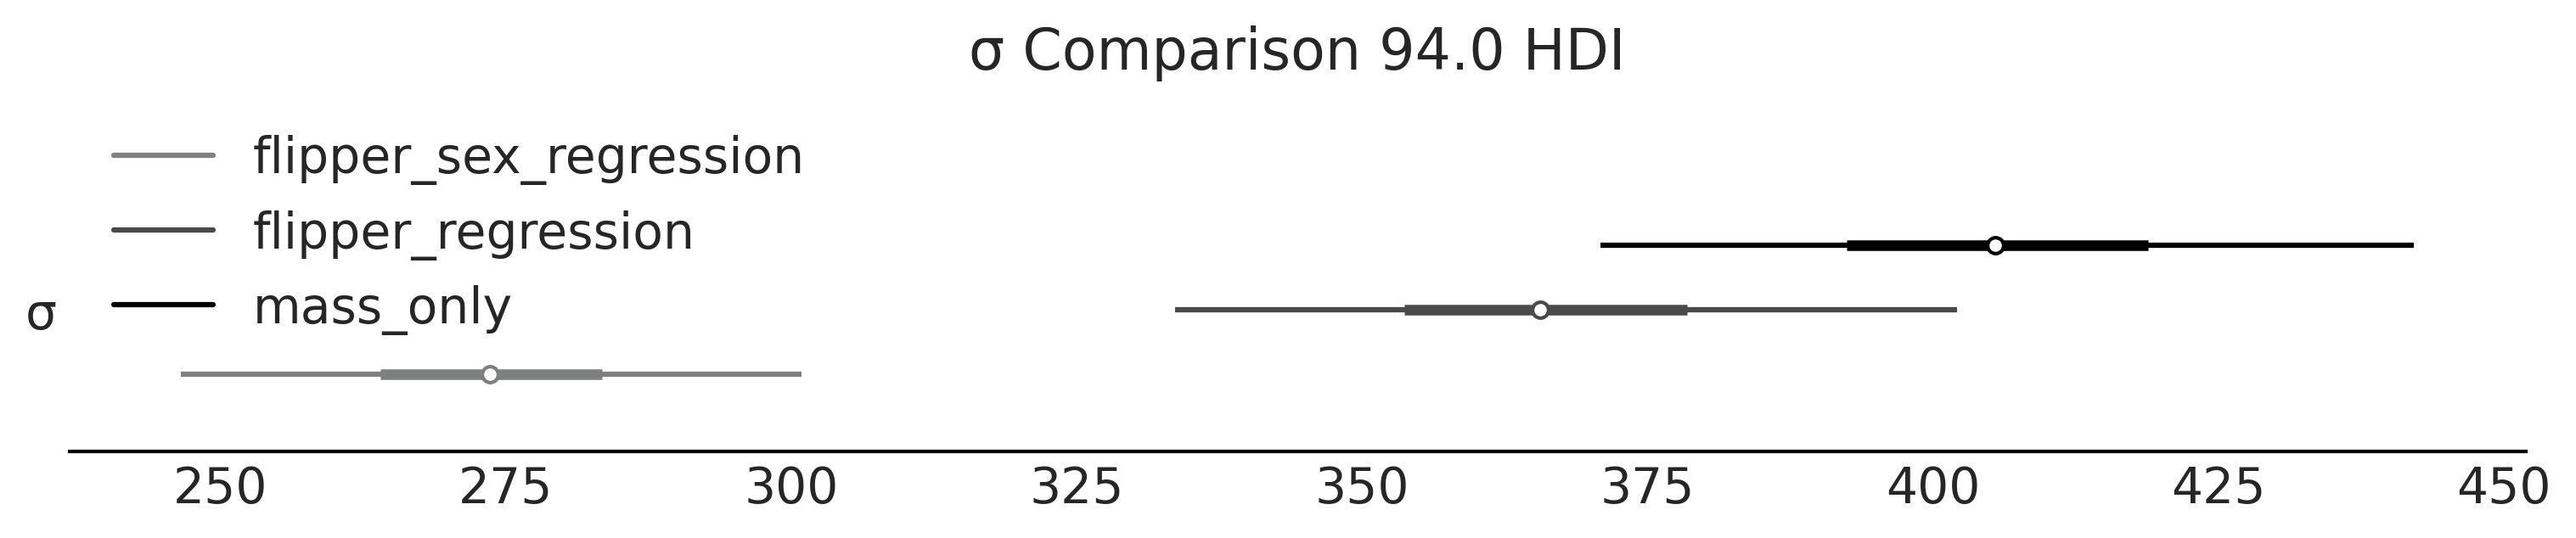

In [42]:
axes = az.plot_forest(
    [idata_adelie_mass, idata_adelie_flipper_regression, inf_data_penguin_mass_categorical],
    model_names=["mass_only", "flipper_regression", "flipper_sex_regression"],
    var_names=["σ"], combined=True, figsize=(10, 2))

axes[0].set_title("σ Comparison 94.0 HDI")
plt.savefig("img/chp03/singlespecies_multipleregression_forest_sigma_comparison.png")

::: {admonition} More covariates is not always better

All model fitting algorithms will find a signal, even if it is random noise. This phenomenon is called
overfitting and it describes a condition where the algorithm can quite
handily map covariates to outcomes in seen cases, but fails to
generalize to new observations. In linear regressions we can show this
by generating 100 random covariates, and fitting them to a random
simulated dataset {cite:p}`mcelreath_2020`. Even though there is no relation,
we would be led to believe our linear model is doing quite well.
:::

(linear_counter_factuals)=

### 3.3.1 Counterfactuals

In Code Block [penguins_ppd](penguins_ppd) we made a
prediction using parameters fitted in a model with a single covariate
and our target, and changing that covariate, flipper length, to get an
estimate of mass at that fixed flipper length. In multiple regression,
we can do something similar, where we take our regression, hold all
covariates constant except one, and see how that change to that one
covariate changes our expected outcome. This analysis is called a
counterfactual analysis. Let us extend the multiple regression from the
previous section (Code Block
[penguin_mass_multi](penguin_mass_multi)), this time
including bill length, and run a counterfactual analysis in TFP. The
model building and inference is shown in Code Block
[tfp_flipper_bill_sex](tfp_flipper_bill_sex).

```{code-block} python
:name: tfp_flipper_bill_sex
:caption: tfp_flipper_bill_sex

def gen_jd_flipper_bill_sex(flipper_length, sex, bill_length, dtype=tf.float32):
    flipper_length, sex, bill_length = tf.nest.map_structure(
        lambda x: tf.constant(x, dtype),
        (flipper_length, sex, bill_length)
    )

    @tfd.JointDistributionCoroutine
    def jd_flipper_bill_sex():
        σ = yield root(
            tfd.HalfStudentT(df=100, loc=0, scale=2000, name="sigma"))
        β_0 = yield root(tfd.Normal(loc=0, scale=3000, name="beta_0"))
        β_1 = yield root(tfd.Normal(loc=0, scale=3000, name="beta_1"))
        β_2 = yield root(tfd.Normal(loc=0, scale=3000, name="beta_2"))
        β_3 = yield root(tfd.Normal(loc=0, scale=3000, name="beta_3"))
        μ = (β_0[..., None]
             + β_1[..., None] * flipper_length
             + β_2[..., None] * sex
             + β_3[..., None] * bill_length
            )
        mass = yield tfd.Independent(
            tfd.Normal(loc=μ, scale=σ[..., None]),
            reinterpreted_batch_ndims=1,
            name="mass")

    return jd_flipper_bill_sex

bill_length_obs = penguins.loc[adelie_mask, "bill_length_mm"]
jd_flipper_bill_sex = gen_jd_flipper_bill_sex(
    adelie_flipper_length_obs, sex_obs, bill_length_obs)

mcmc_samples, sampler_stats = run_mcmc(
    1000, jd_flipper_bill_sex, n_chains=4, num_adaptation_steps=1000,
    mass=tf.constant(adelie_mass_obs, tf.float32))
```

In [43]:
def gen_jd_flipper_bill_sex(flipper_length, sex, bill_length, dtype=tf.float32):
    flipper_length, sex, bill_length = tf.nest.map_structure(
        lambda x: tf.constant(x, dtype),
        (flipper_length, sex, bill_length)
    )

    @tfd.JointDistributionCoroutine
    def jd_flipper_bill_sex():
        σ = yield root(
            tfd.HalfStudentT(df=100, loc=0, scale=2000, name="sigma"))
        β_0 = yield root(tfd.Normal(loc=0, scale=3000, name="beta_0"))
        β_1 = yield root(tfd.Normal(loc=0, scale=3000, name="beta_1"))
        β_2 = yield root(tfd.Normal(loc=0, scale=3000, name="beta_2"))
        β_3 = yield root(tfd.Normal(loc=0, scale=3000, name="beta_3"))
        μ = (β_0[..., None]
             + β_1[..., None] * flipper_length
             + β_2[..., None] * sex
             + β_3[..., None] * bill_length
            )
        mass = yield tfd.Independent(
            tfd.Normal(loc=μ, scale=σ[..., None]),
            reinterpreted_batch_ndims=1,
            name="mass")

    return jd_flipper_bill_sex

bill_length_obs = penguins.loc[adelie_mask, "bill_length_mm"]
jd_flipper_bill_sex = gen_jd_flipper_bill_sex(
    adelie_flipper_length_obs, sex_obs, bill_length_obs)

mcmc_samples, sampler_stats = run_mcmc(
    1000, jd_flipper_bill_sex, n_chains=4, num_adaptation_steps=1000,
    mass=tf.constant(adelie_mass_obs, tf.float32))

2025-01-24 23:46:57.304103: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert


In [44]:
idata_model_penguin_flipper_bill_sex = az.from_dict(
    posterior={
        k:np.swapaxes(v, 1, 0)
        for k, v in mcmc_samples._asdict().items()},
    sample_stats={
        k:np.swapaxes(sampler_stats[k], 1, 0)
        for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]}
)

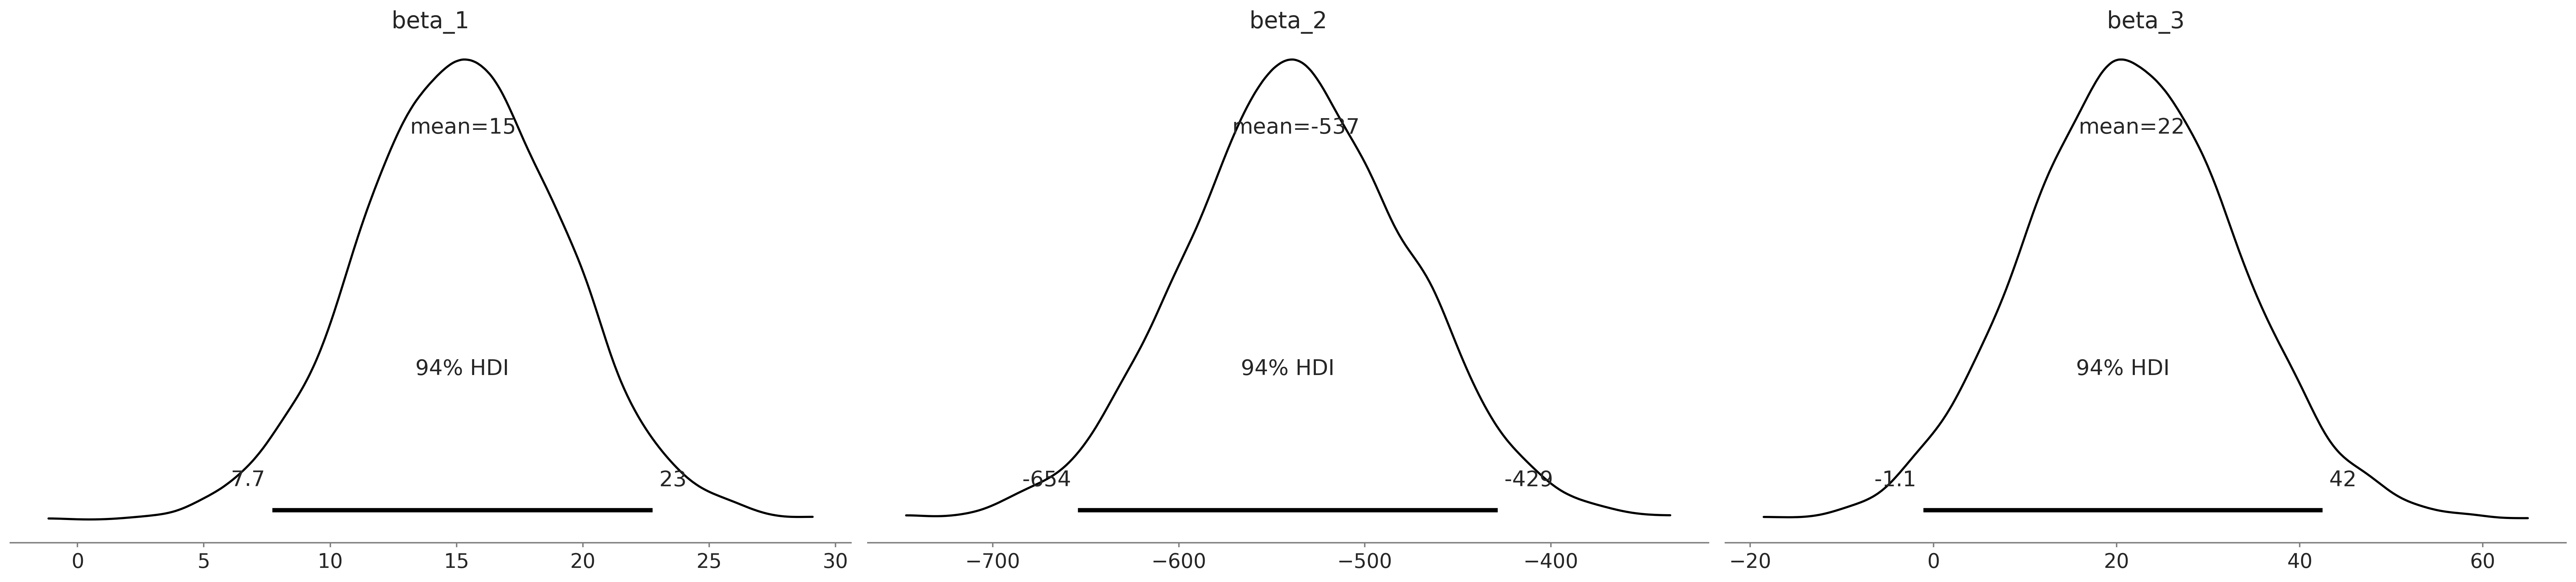

In [45]:
az.plot_posterior(idata_model_penguin_flipper_bill_sex, var_names=["beta_1", "beta_2", "beta_3"]);

In [46]:
az.summary(idata_model_penguin_flipper_bill_sex, var_names=["beta_1", "beta_2", "beta_3", "sigma"])

mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_1   15.254   4.012    7.699   22.759      0.095    0.069    1787.0   
beta_2 -536.999  60.456 -654.260 -428.643      1.345    0.955    2021.0   
beta_3   21.634  11.591   -1.129   42.482      0.257    0.185    2036.0   
sigma   294.627  18.096  260.484  327.715      0.351    0.249    2647.0   

        ess_tail  r_hat  
beta_1    1886.0    1.0  
beta_2    2400.0    1.0  
beta_3    1969.0    1.0  
sigma     2510.0    1.0

In this model you will note the addition of another coefficient `beta_3`
to correspond to the addition of bill length as a covariate. After
inference, we can simulate the mass of penguins with different fictional
flipper lengths, while holding the sex constant at male, and the bill
length at the observed mean of the dataset. This is done in Code Block
[tfp_flipper_bill_sex_counterfactuals](tfp_flipper_bill_sex_counterfactuals)
with the result shown in {numref}`fig:LinearCounterfactual`. Again since
we wrap the model generation in a Python function (a functional
programming style approach), it is easy to condition on new predictors,
which is useful for counterfactual analyses.

```{code-block} python
:name: tfp_flipper_bill_sex_counterfactuals
:caption: tfp_flipper_bill_sex_counterfactuals

mean_flipper_length = penguins.loc[adelie_mask, "flipper_length_mm"].mean()
# Counterfactual dimensions is set to 21 to allow us to get the mean exactly
counterfactual_flipper_lengths = np.linspace(
    mean_flipper_length-20, mean_flipper_length+20, 21)
sex_male_indicator = np.zeros_like(counterfactual_flipper_lengths)
mean_bill_length = np.ones_like(
    counterfactual_flipper_lengths) * bill_length_obs.mean()

jd_flipper_bill_sex_counterfactual = gen_jd_flipper_bill_sex(
    counterfactual_flipper_lengths, sex_male_indicator, mean_bill_length)
ppc_samples = jd_flipper_bill_sex_counterfactual.sample(value=mcmc_samples)
estimated_mass = ppc_samples[-1].numpy().reshape(-1, 21)
```

```{figure} figures/Linear_CounterFactual.png
:name: fig:LinearCounterfactual
:width: 7.00in
Estimated counterfactual mass values for Adelie penguins from Code Block
[tfp_flipper_bill_sex_counterfactuals](tfp_flipper_bill_sex_counterfactuals)
where flipper length is varied holding all other covariates constant.
```

In [47]:
mean_flipper_length = penguins.loc[adelie_mask, "flipper_length_mm"].mean()
# Counterfactual dimensions is set to 21 to allow us to get the mean exactly
counterfactual_flipper_lengths = np.linspace(
    mean_flipper_length-20, mean_flipper_length+20, 21)
sex_male_indicator = np.zeros_like(counterfactual_flipper_lengths)
mean_bill_length = np.ones_like(
    counterfactual_flipper_lengths) * bill_length_obs.mean()

jd_flipper_bill_sex_counterfactual = gen_jd_flipper_bill_sex(
    counterfactual_flipper_lengths, sex_male_indicator, mean_bill_length)
ppc_samples = jd_flipper_bill_sex_counterfactual.sample(value=mcmc_samples)
estimated_mass = ppc_samples[-1].numpy().reshape(-1, 21)

/home/hwting/anaconda3/envs/rapids/lib/python3.11/site-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


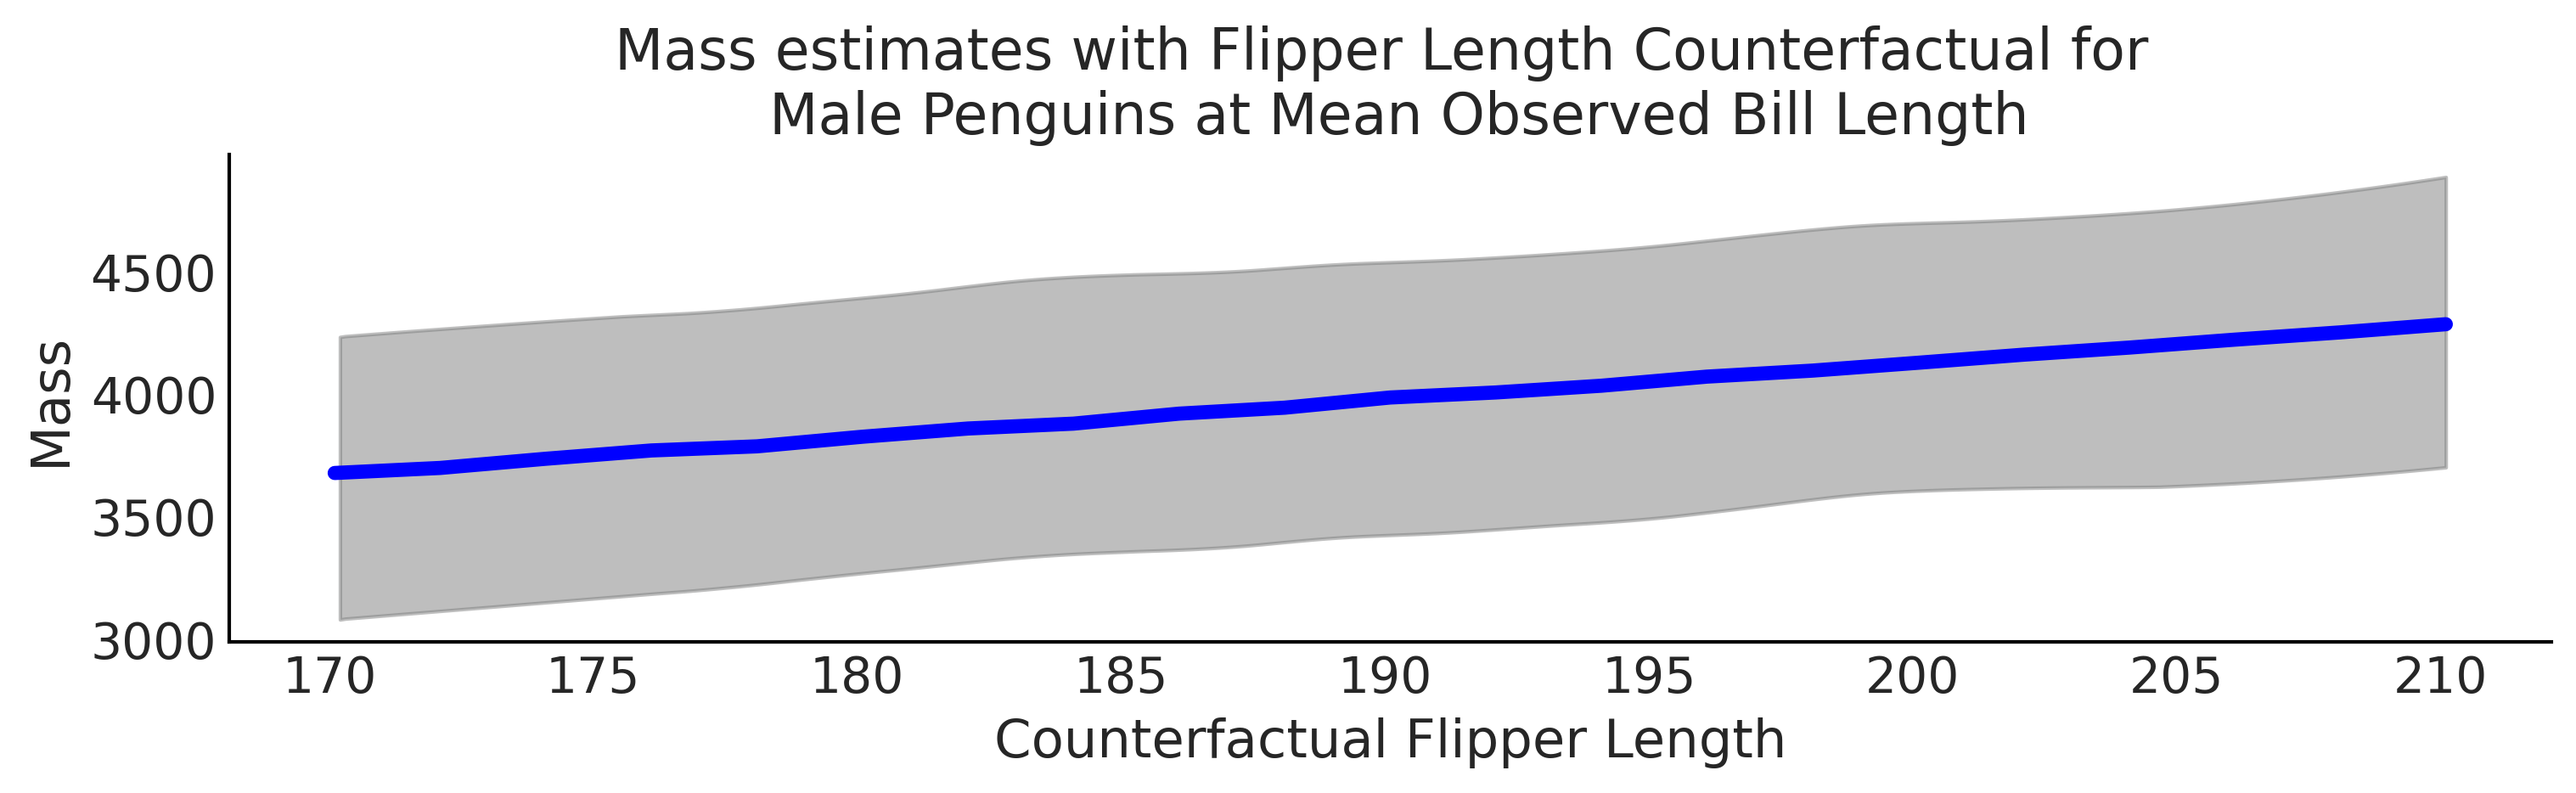

In [48]:
_, ax = plt.subplots(figsize=(10, 3))
az.plot_hdi(counterfactual_flipper_lengths, estimated_mass, color="C2", plot_kwargs={"ls": "--"}, ax=ax)
ax.plot(counterfactual_flipper_lengths, estimated_mass.mean(axis=0), lw=4, c="blue")
ax.set_title("Mass estimates with Flipper Length Counterfactual for \n Male Penguins at Mean Observed Bill Length")
ax.set_xlabel("Counterfactual Flipper Length")
ax.set_ylabel("Mass")
plt.savefig("img/chp03/linear_counter_factual.png")

Following McElreath{cite:p}`mcelreath_2020` {numref}`fig:LinearCounterfactual`
is called a counterfactual plot. As the word counterfactual implies, we
are evaluating a situation counter to the observed data, or facts. In
other words, we are evaluating situations that have not happened. The
simplest use of a counterfactual plot is to adjust a covariate and
explore the result, exactly like we just did. This is great, as it
enables us to explore *what-if* scenarios, that could be beyond our
reach otherwise [^6]. However, we must be cautious when interpreting
this trickery. The first trap is that counterfactual values may be
impossible, for example, no penguin may ever exist with a flipper length
larger than 1500mm but the model will happily give us estimates for this
fictional penguin. The second is more insidious, we assumed that we
could vary each covariate independently, but in reality this may not be
possible. For example, as a penguin's flipper length increases, its bill
length may as well. Counterfactuals are powerful in that they allow us
to explore outcomes that have not happened, or that we at least did not
observe happen. But they can easily generate estimates for situations
that will *never* happen. It is the model that will not discern between
the two, so you as a modeler must.

::: {admonition} Correlation vs Causality

When interpreting linear regressions it is tempting to say "An increase
in $X$ **causes** and increase in $Y$\". This is not necessarily the
case, in fact causal statements can not be made from a (linear)
regression alone. Mathematically a linear model links two (or more
variables) together but this link does not need to be causal. For
example, increasing the amount of water we provide to a plant can
certainly (and causally) increase the plant's growth (at least within
some range), but nothing prevents us from inverting this relationship in
a model and use the growth of plants to estimate the amount of rain,
even when plant growth do not cause rain [^7]. The statistical sub-field
of Causal Inference is concerned with the tools and procedures necessary
to make causal statements either in the context of randomized
experiments or observational studies (see Chapter [7](chap6) for
a brief discussion)
:::

[^6]: Maybe because collecting more data is expensive or difficult or
    even impossible

[^7]: Unless we are talking about large systems like rain forests, where
    the presence of plants actually have an impact in the weather.
    Nature can be hard to grasp with simple statements.

(generalized-linear-models)=

## 3.4 Generalized Linear Models

All linear models discussed so far assumed the distribution of
observations are conditionally Gaussian which works well in many
scenarios. However, we may want to use other distributions. For example,
to model things that are restricted to some interval, a number in the
interval $[0, 1]$ like probabilities, or natural numbers
$\{1, 2, 3, \dots \}$ like counting events. To do this we will take our
linear function, $\mathbf{X} \mathit{\beta}$, and modify it using an
inverse link function [^8] $\phi$ as shown in Equation
{eq}`eq:generalized_linear_model`.

```{math}
:label: eq:generalized_linear_model
\begin{split}
\mu =& \phi(\mathbf{X} \beta) \\
Y \sim& \Psi (\mu, \theta)

\end{split}
```

where $\Psi$ is some distribution parameterized by $\mu$ and $\theta$
indicating the data likelihood.

The specific purpose of the inverse link function is to map outputs from
the range of real numbers $(-\infty, \infty)$ to a parameter range of
the restricted interval. In other words the inverse link function is the
specific "trick\" we need to take our linear models and generalize them
to many more model architectures. We are still dealing with a linear model
here in the sense that the expectation of the distribution that
generates the observation still follows a linear function of the
parameter and the covariates but now we can generalize the use and
application of these models to many more scenarios [^9].

[^8]: Traditionally people apply functions like $\phi$ to the left side
    of Equation {eq}`eq:generalized_linear_model`, and call them link
    functions. We instead prefer to apply them to the right-hand side
    and then to avoid confusion we use term inverse link function.

[^9]: Usually in the traditional Generalized Linear Models Literature,
    the likelihood of the observation need to be from the Exponential
    family, but being Bayesian we are actually not restricted by that
    and can use any likelihood that can be parameterized by the expected
    value.

### 3.4.1 Logistic Regression

One of the most common generalized linear model is the logistic
regression. It is particularly useful in modeling data where there are
only two possible outcomes, we observed either one thing or another
thing. The probability of a head or tails outcome in a coin flip is the
usual textbook example. More "real world\" examples includes the chance
of a defect in manufacturing, a negative or positive cancer test, or the
failure of a rocket launch {cite:p}`davidson-pilon_2015`. In a logistic
regression the inverse link function is called, unsurprisingly, the
logistic function, which maps $(-\infty, \infty)$ to the $(0,1)$
interval. This is handy because now we can map linear functions to the
range we would expect for a parameter that estimates probability values,
that must be in the range 0 and 1 by definition.

```{math}
:label: eq:logistic
p = \frac{1}{1+e^{-\mathbf{X}\beta}}

```

```{figure} figures/Logistic.png
:name: fig:Logistic
:width: 7.00in
A plot of a sample logistic function. Note the response has been
"squished\" into the interval (0,1).
```

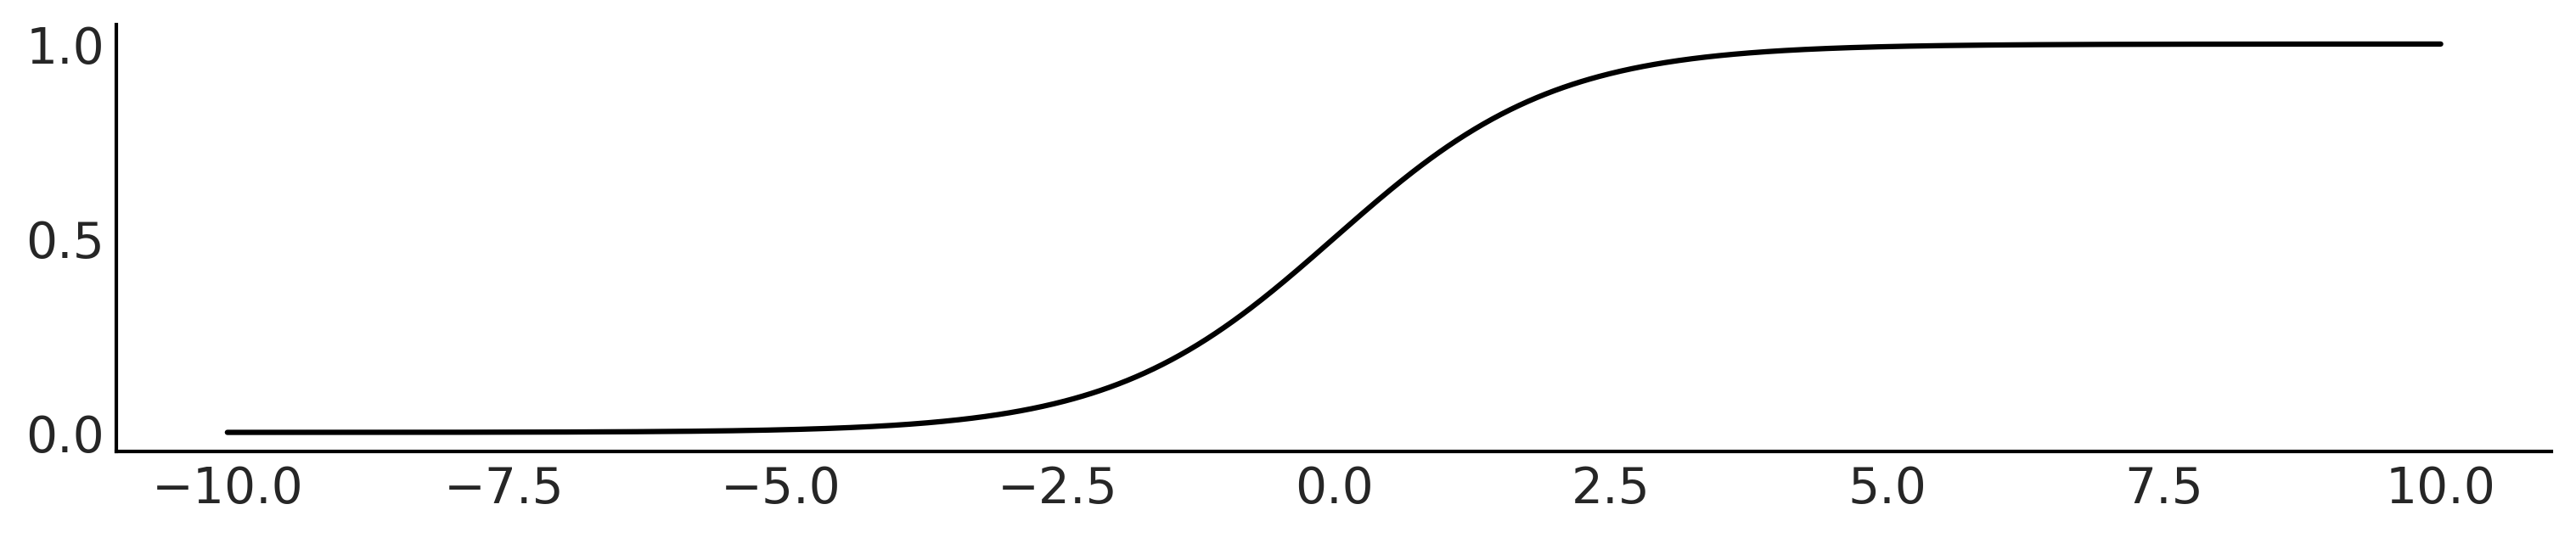

In [49]:
x = np.linspace(-10, 10, 1000)
y = special.expit(x)

plt.figure(figsize=(10, 2))
plt.plot(x,y)
plt.savefig("img/chp03/logistic.png")

With logistic regression we are able to use linear models to estimate
probabilities of an event. Sometimes, instead we want to classify, or to
predict, a specific class given some data. In order to do so we want to
turn the continuous prediction in the interval $(-\infty, \infty)$ to
one between 0 and 1. We can do this with a decision boundary to make a
prediction in the set ${0,1}$. Let us assume we want our decision
boundary set at a probability of 0.5. For a model with an intercept and
one covariate we have:

```{math}
:label: decision_boundary
\begin{split}
0.5 &= logistic(\beta_{0} + \beta_{1}*x) \\
logit(0.5) &= \beta_{0} + \beta_{1}*x \\
0 &= \beta_{0} + \beta_{1}*x \\
x &= -\frac{\beta_{0}}{\beta_{1}} \\
\end{split}
```

Note that $logit$ is the inverse of $logistic$. That is, once a logistic
model is fitted we can use the coefficients $\beta_0$ and $\beta_1$ to
easily compute the value of $x$ for which the probability of the class
is greater than 0.5.

(classifying_penguins)=

### 3.4.2 Classifying Penguins

In the previous sections we used the sex, and bill length of a penguin
to estimate the mass of a penguin. Lets now alter the question, if we
were given the mass, sex, and bill length of a penguin can we predict
the species? Let us use two species Adelie and Chinstrap to make this a
binary task. Like last time we use a simple model first with just one
covariate, bill length. We write this logistic model in Code Block
[model_logistic_penguins_bill_length](model_logistic_penguins_bill_length)

```{code-block} python
:name: model_logistic_penguins_bill_length
:caption: model_logistic_penguins_bill_length

species_filter = penguins["species"].isin(["Adelie", "Chinstrap"])
bill_length_obs = penguins.loc[species_filter, "bill_length_mm"].values
species = pd.Categorical(penguins.loc[species_filter, "species"])

with pm.Model() as model_logistic_penguins_bill_length:
    β_0 = pm.Normal("β_0", mu=0, sigma=10)
    β_1 = pm.Normal("β_1", mu=0, sigma=10)

    μ = β_0 + pm.math.dot(bill_length_obs, β_1)

    # Application of our sigmoid  link function
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))

    # Useful for plotting the decision boundary later
    bd = pm.Deterministic("bd", -β_0/β_1)

    # Note the change in likelihood
    yl = pm.Bernoulli("yl", p=θ, observed=species.codes)

    prior_predictive_logistic_penguins_bill_length = pm.sample_prior_predictive()
    trace_logistic_penguins_bill_length = pm.sample(5000, chains=2)
    inf_data_logistic_penguins_bill_length = az.from_pymc3(
        prior=prior_predictive_logistic_penguins_bill_length,
        trace=trace_logistic_penguins_bill_length)
```

In [50]:
species_filter = penguins["species"].isin(["Adelie", "Chinstrap"])
bill_length_obs = penguins.loc[species_filter, "bill_length_mm"].values
species = pd.Categorical(penguins.loc[species_filter, "species"])

with pm.Model() as model_logistic_penguins_bill_length:
    β_0 = pm.Normal("β_0", mu=0, sigma=10)
    β_1 = pm.Normal("β_1", mu=0, sigma=10)

    μ = β_0 + pm.math.dot(bill_length_obs, β_1)

    # Application of our sigmoid  link function
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))

    # Useful for plotting the decision boundary later
    bd = pm.Deterministic("bd", -β_0/β_1)

    # Note the change in likelihood
    yl = pm.Bernoulli("yl", p=θ, observed=species.codes)

    idata_logistic_penguins_bill_length = pm.sample(5000, chains=2, random_seed=0,
                                                    idata_kwargs={"log_likelihood":True})
    idata_logistic_penguins_bill_length.extend(pm.sample_prior_predictive(samples=10000))
    idata_logistic_penguins_bill_length.extend(pm.sample_posterior_predictive(idata_logistic_penguins_bill_length))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β_0, β_1]


Output()

Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 8 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [yl, β_0, β_1]
Sampling: [yl]


Output()

In generalized linear models, the mapping from parameter prior to
response can sometimes be more challenging to understand. We can utilize
prior predictive samples to help us visualize the expected observations.
In our classifying penguins example we find it reasonable to equally
expect a Chinstrap penguin, as we would an Adelie penguin, at all bill
lengths, prior to seeing any data. We can double-check our modeling
intention has been represented correctly by our priors and model using
the prior predictive distribution. The classes are roughly even in
{numref}`fig:Prior_Predictive_Logistic` prior to seeing data which is
what we would expect.

```{figure} figures/Prior_Predictive_Logistic.png
:name: fig:Prior_Predictive_Logistic
:width: 7.00in
5000 prior predictive samples of class prediction from the
`model_logistic_penguins_bill_length`. This likelihood is discrete, more
specifically binary, as opposed to the continuous distribution of mass
that was being estimated in earlier models.
```

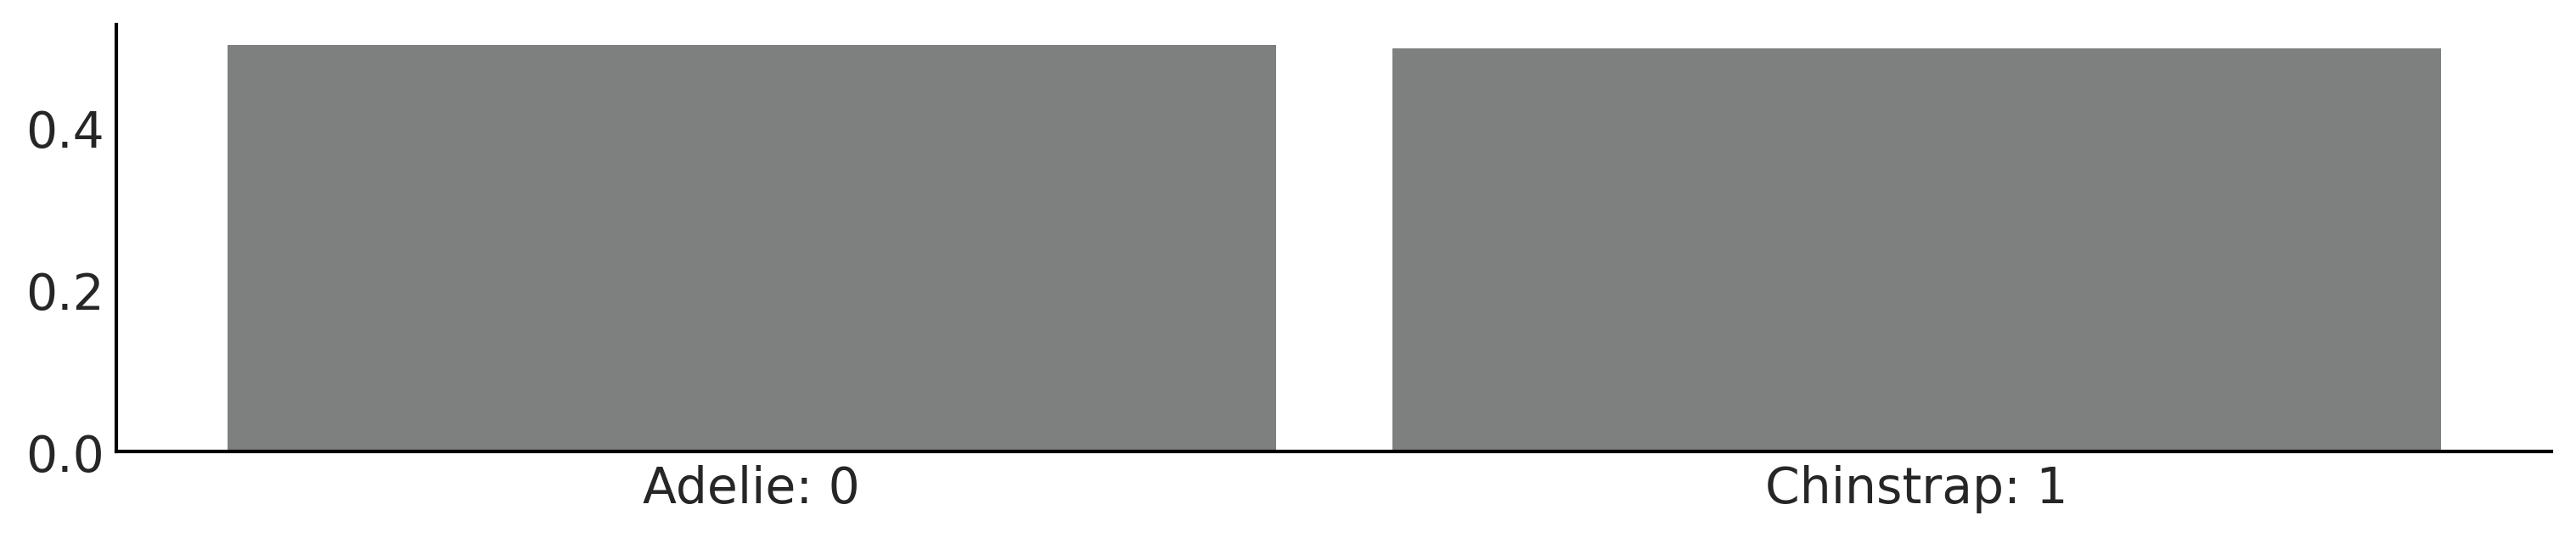

In [51]:
_, ax = plt.subplots(figsize=(10, 2))
az.plot_dist(idata_logistic_penguins_bill_length.prior_predictive["yl"], color="C2", ax=ax)
ax.set_xticklabels(["Adelie: 0", "Chinstrap: 1"] )
plt.savefig("img/chp03/prior_predictive_logistic.png")

After fitting the parameters in our model we can inspect the
coefficients using `az.summary(.)` function (see {numref}`table:logistic_penguins_bill_length`). 
While we can read the
coefficients they are not as directly interpretable as in a linear
regression. We can tell there is some relationship with bill length and
species given the positive $\beta_1$ coefficient whose HDI does not
cross zero. We can interpret the decision boundary fairly directly
seeing that around 44 mm in bill length is the nominal cutoff for one
species to another. Plotting the regression output in
{numref}`fig:Logistic_bill_length` is much more intuitive. Here we see
the now familiar logistic curve move from 0 on the left to 1 on the
right as the classes change, and a decision boundary where one would
expect it given the data.

```{figure} figures/Logistic_bill_length.png
:name: fig:Logistic_bill_length
:width: 7.00in
Fitted logistic regression, showing probability curve, observed data
points and decision boundary for `model_logistic_penguins_bill_length`.
Looking at just the observed data it seems there is a separation around
45mm bill length for both species, and our model similarly discerned the
separation around that value.
```

```{list-table} Logistic regression coefficients for model_logistic_penguins_bill_length.
:name: table:logistic_penguins_bill_length
* -
  - **mean**
  - **sd**
  - **hdi_3%**
  - **hdi_97%**
* - $\beta_0$
  - -46.052
  -   7.073
  - -58.932
  - -34.123
* - $\beta_1$
  - 1.045
  - 0.162
  - 0.776
  - 1.347
```

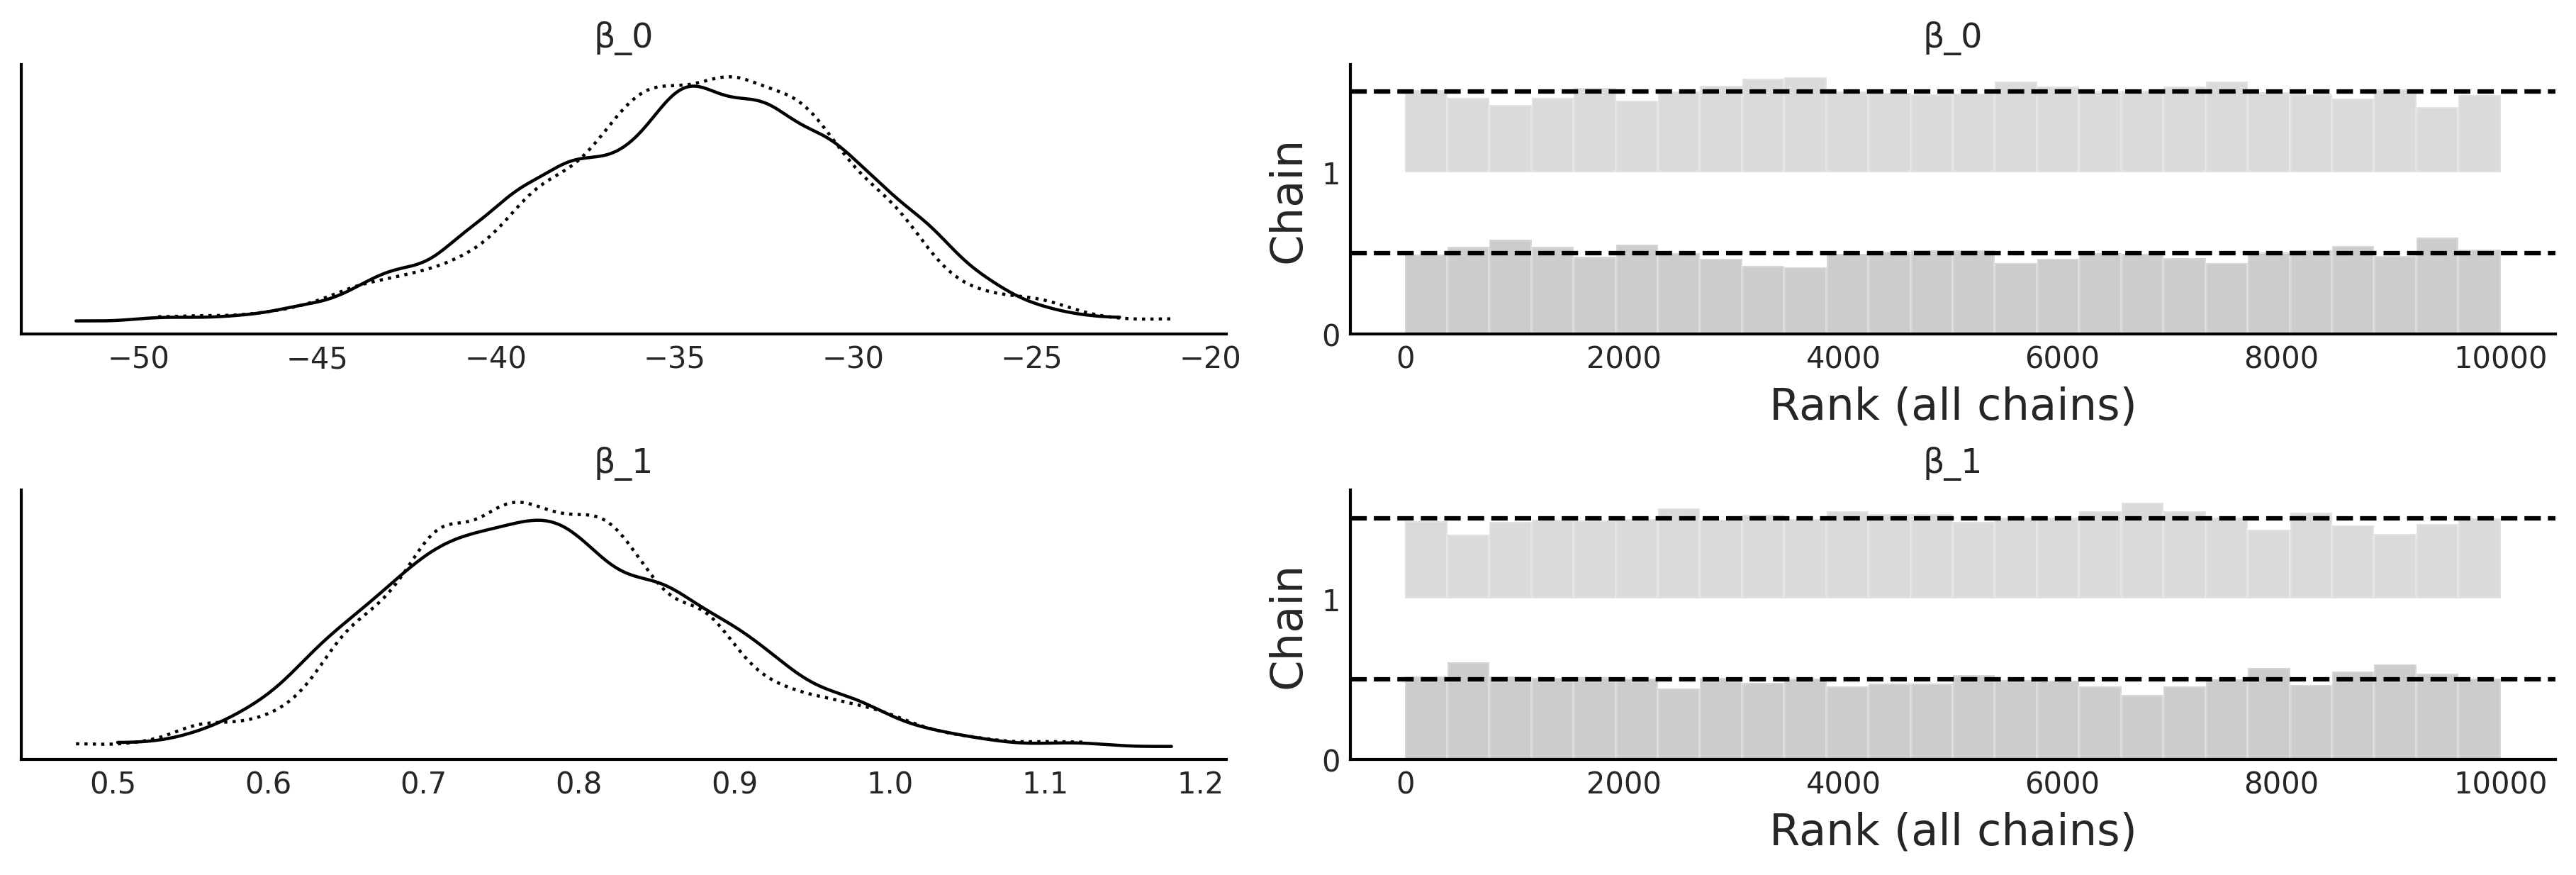

In [52]:
az.plot_trace(idata_logistic_penguins_bill_length, var_names=["β_0", "β_1"], kind="rank_bars");

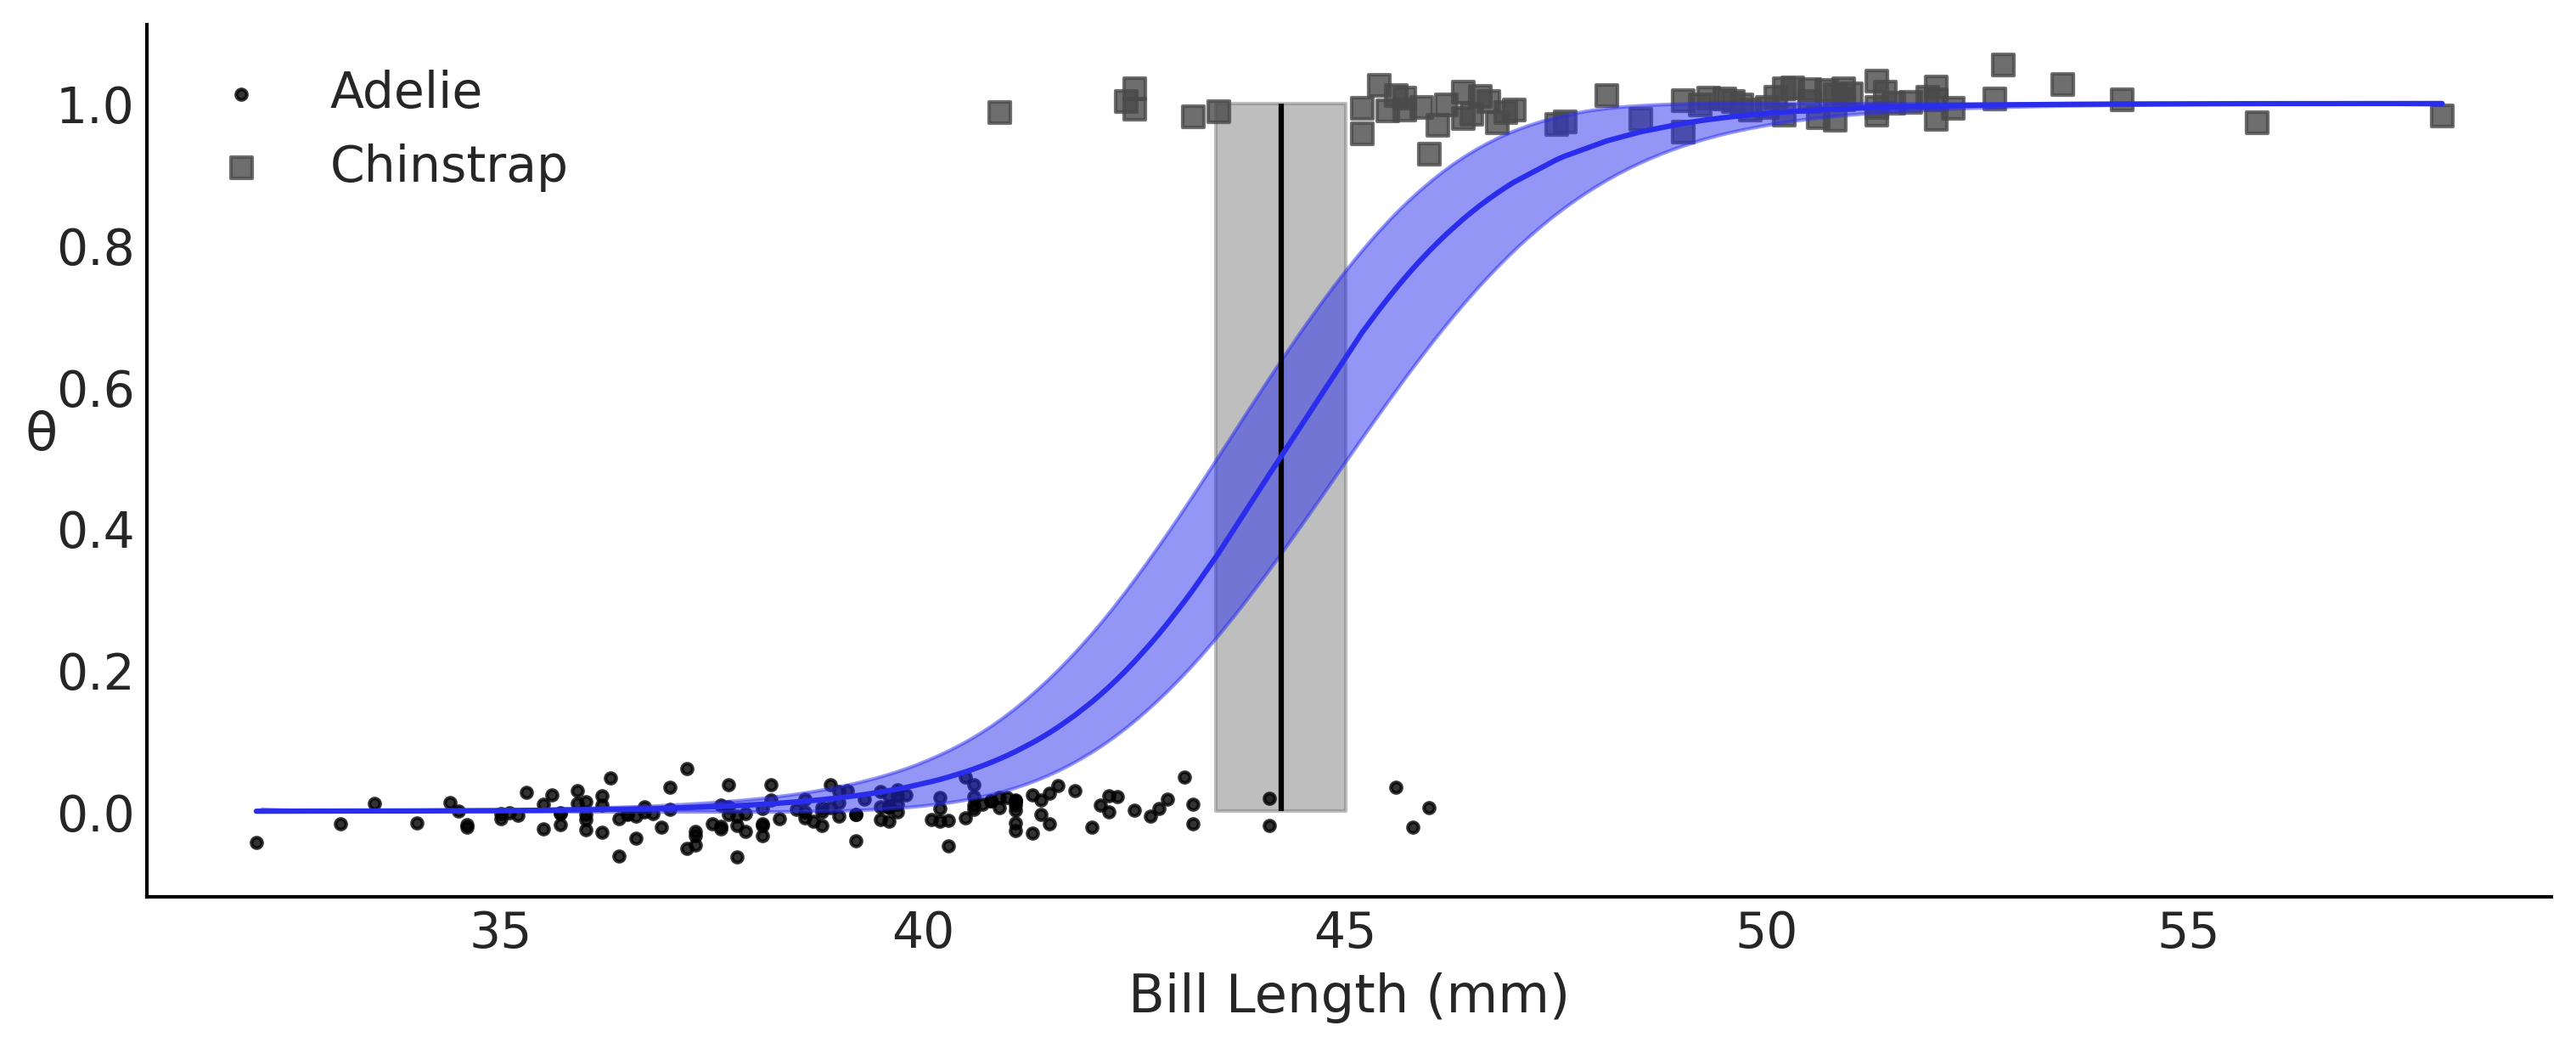

In [53]:
fig, ax = plt.subplots(figsize=(10, 4))

theta = idata_logistic_penguins_bill_length.posterior["θ"].mean(("chain", "draw"))


idx = np.argsort(bill_length_obs)

# Decision Boundary
ax.vlines(idata_logistic_penguins_bill_length.posterior["bd"].values.mean(), 0, 1, color='k')
bd_hpd = az.hdi(idata_logistic_penguins_bill_length.posterior["bd"].values.flatten(), ax=ax)
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='C2', alpha=0.5)


for i, (label, marker) in enumerate(zip(species.categories, (".", "s"))):
    _filter = (species.codes == i)
    x = bill_length_obs[_filter]
    y = np.random.normal(i, 0.02, size=_filter.sum())
    ax.scatter(bill_length_obs[_filter], y, marker=marker, label=label, alpha=.8)

az.plot_hdi(bill_length_obs, idata_logistic_penguins_bill_length.posterior["θ"].values, color='C4', ax=ax, plot_kwargs={"zorder":10})
ax.plot(bill_length_obs[idx], theta[idx], color='C4', zorder=10)

ax.set_xlabel("Bill Length (mm)")
ax.set_ylabel('θ', rotation=0)
plt.legend()
plt.savefig("img/chp03/logistic_bill_length.png")

In [54]:
az.summary(idata_logistic_penguins_bill_length, var_names=["β_0", "β_1"], kind="stats")

mean     sd  hdi_3%  hdi_97%
β_0 -34.516  4.471 -43.267  -26.415
β_1   0.780  0.103   0.608    0.993

Let us try something different, we still want to classify penguins but
this time using mass as a covariate. Code Block
[model_logistic_penguins_mass](model_logistic_penguins_mass)
shows a model for that purpose.

```{code-block} python
:name: model_logistic_penguins_mass
:caption: model_logistic_penguins_mass

mass_obs = penguins.loc[species_filter, "body_mass_g"].values

with pm.Model() as model_logistic_penguins_mass:
    β_0 = pm.Normal("β_0", mu=0, sigma=10)
    β_1 = pm.Normal("β_1", mu=0, sigma=10)

    μ = β_0 + pm.math.dot(mass_obs, β_1)
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))
    bd = pm.Deterministic("bd", -β_0/β_1)

    yl = pm.Bernoulli("yl", p=θ, observed=species.codes)

    inf_data_logistic_penguins_mass = pm.sample(
        5000, target_accept=.9, return_inferencedata=True)
```

```{list-table} Logistic regression coefficients for model_logistic_penguins_mass.
:name: table:logistic_penguins_mass
* -
  - **mean**
  - **sd**
  - **hdi_3%**
  - **hdi_97%**
* - $\beta_0$
  - -1.131
  -  1.317
  - -3.654
  -  1.268
* - $\beta_1$
  - 0.000
  - 0.000
  - 0.000
  - 0.001
```

In [55]:
mass_obs = penguins.loc[species_filter, "body_mass_g"].values

with pm.Model() as model_logistic_penguins_mass:
    β_0 = pm.Normal("β_0", mu=0, sigma=10)
    β_1 = pm.Normal("β_1", mu=0, sigma=10)

    μ = β_0 + pm.math.dot(mass_obs, β_1)
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))
    bd = pm.Deterministic("bd", -β_0/β_1)

    yl = pm.Bernoulli("yl", p=θ, observed=species.codes)


    idata_logistic_penguins_mass = pm.sample(5000, chains=2, 
                                             target_accept=.9, random_seed=0, 
                                             idata_kwargs={"log_likelihood":True})
    idata_logistic_penguins_mass.extend(pm.sample_posterior_predictive(idata_logistic_penguins_mass))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β_0, β_1]


Output()

Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [yl]


Output()

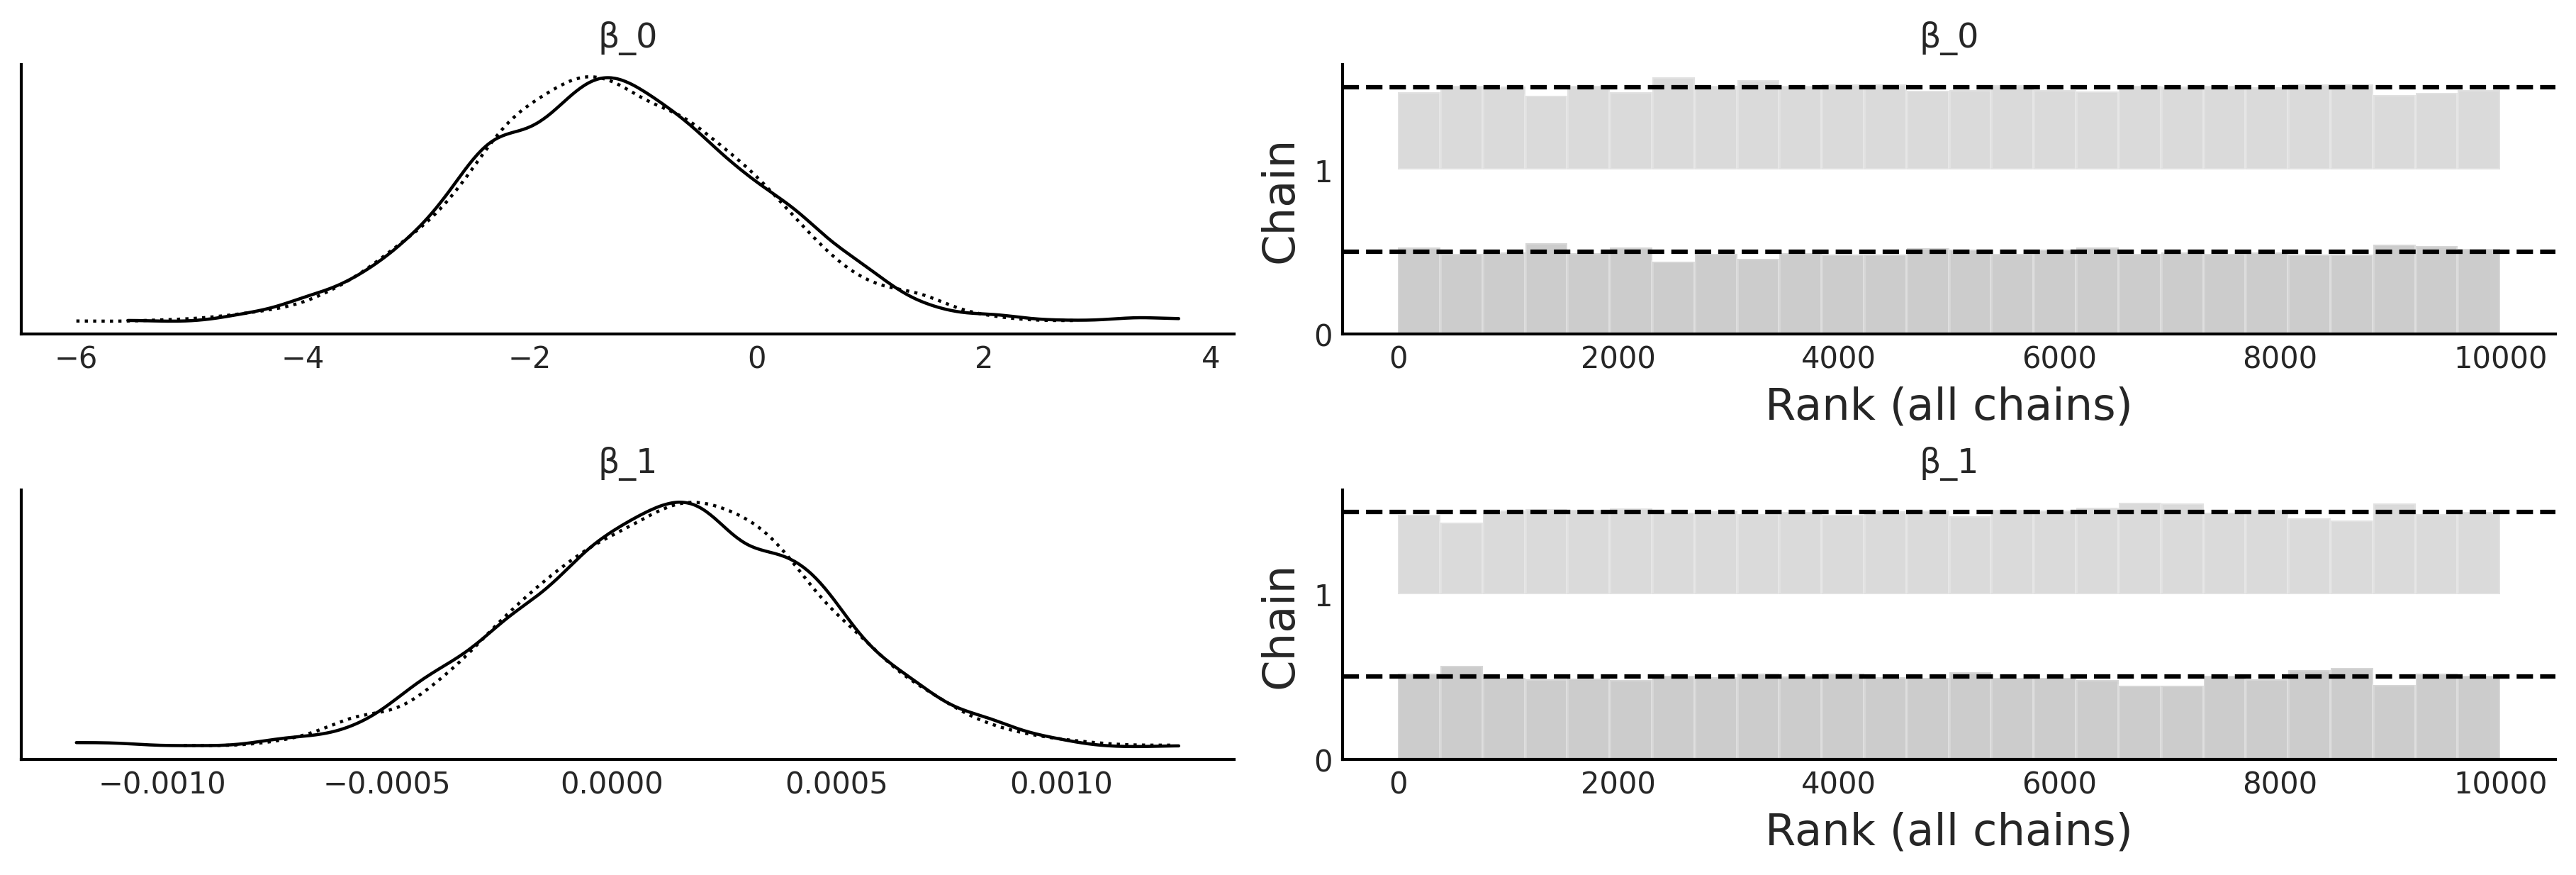

In [56]:
az.plot_trace(idata_logistic_penguins_mass, var_names=["β_0", "β_1"], kind="rank_bars");

In [57]:
az.summary(idata_logistic_penguins_mass, var_names=["β_0", "β_1", "bd"], kind="stats")

mean          sd     hdi_3%    hdi_97%
β_0     -1.278       1.235     -3.524      1.089
β_1      0.000       0.000     -0.000      0.001
bd   15654.555  923493.484 -22591.208  32185.075

Our tabular summary in {numref}`table:logistic_penguins_mass` shows
that $\beta_1$ is estimated to be 0 indicating there is not enough
information in the mass covariate to separate the two classes. This is
not necessarily a bad thing, just the model indicating to us that it
does not find discernible difference in mass between these two species.
This becomes quite evident once we plot the data and logistic regression
fit in {numref}`fig:Logistic_mass`.

```{figure} figures/Logistic_mass.png
:name: fig:Logistic_mass
:width: 7.00in
Plot of the observed data and logistic regression for
`model_logistic_penguins_mass`. Unlike
{numref}`fig:Logistic_bill_length` the data does not look very separable
and our model did discern one as well.
```

In [58]:
species.codes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int8)

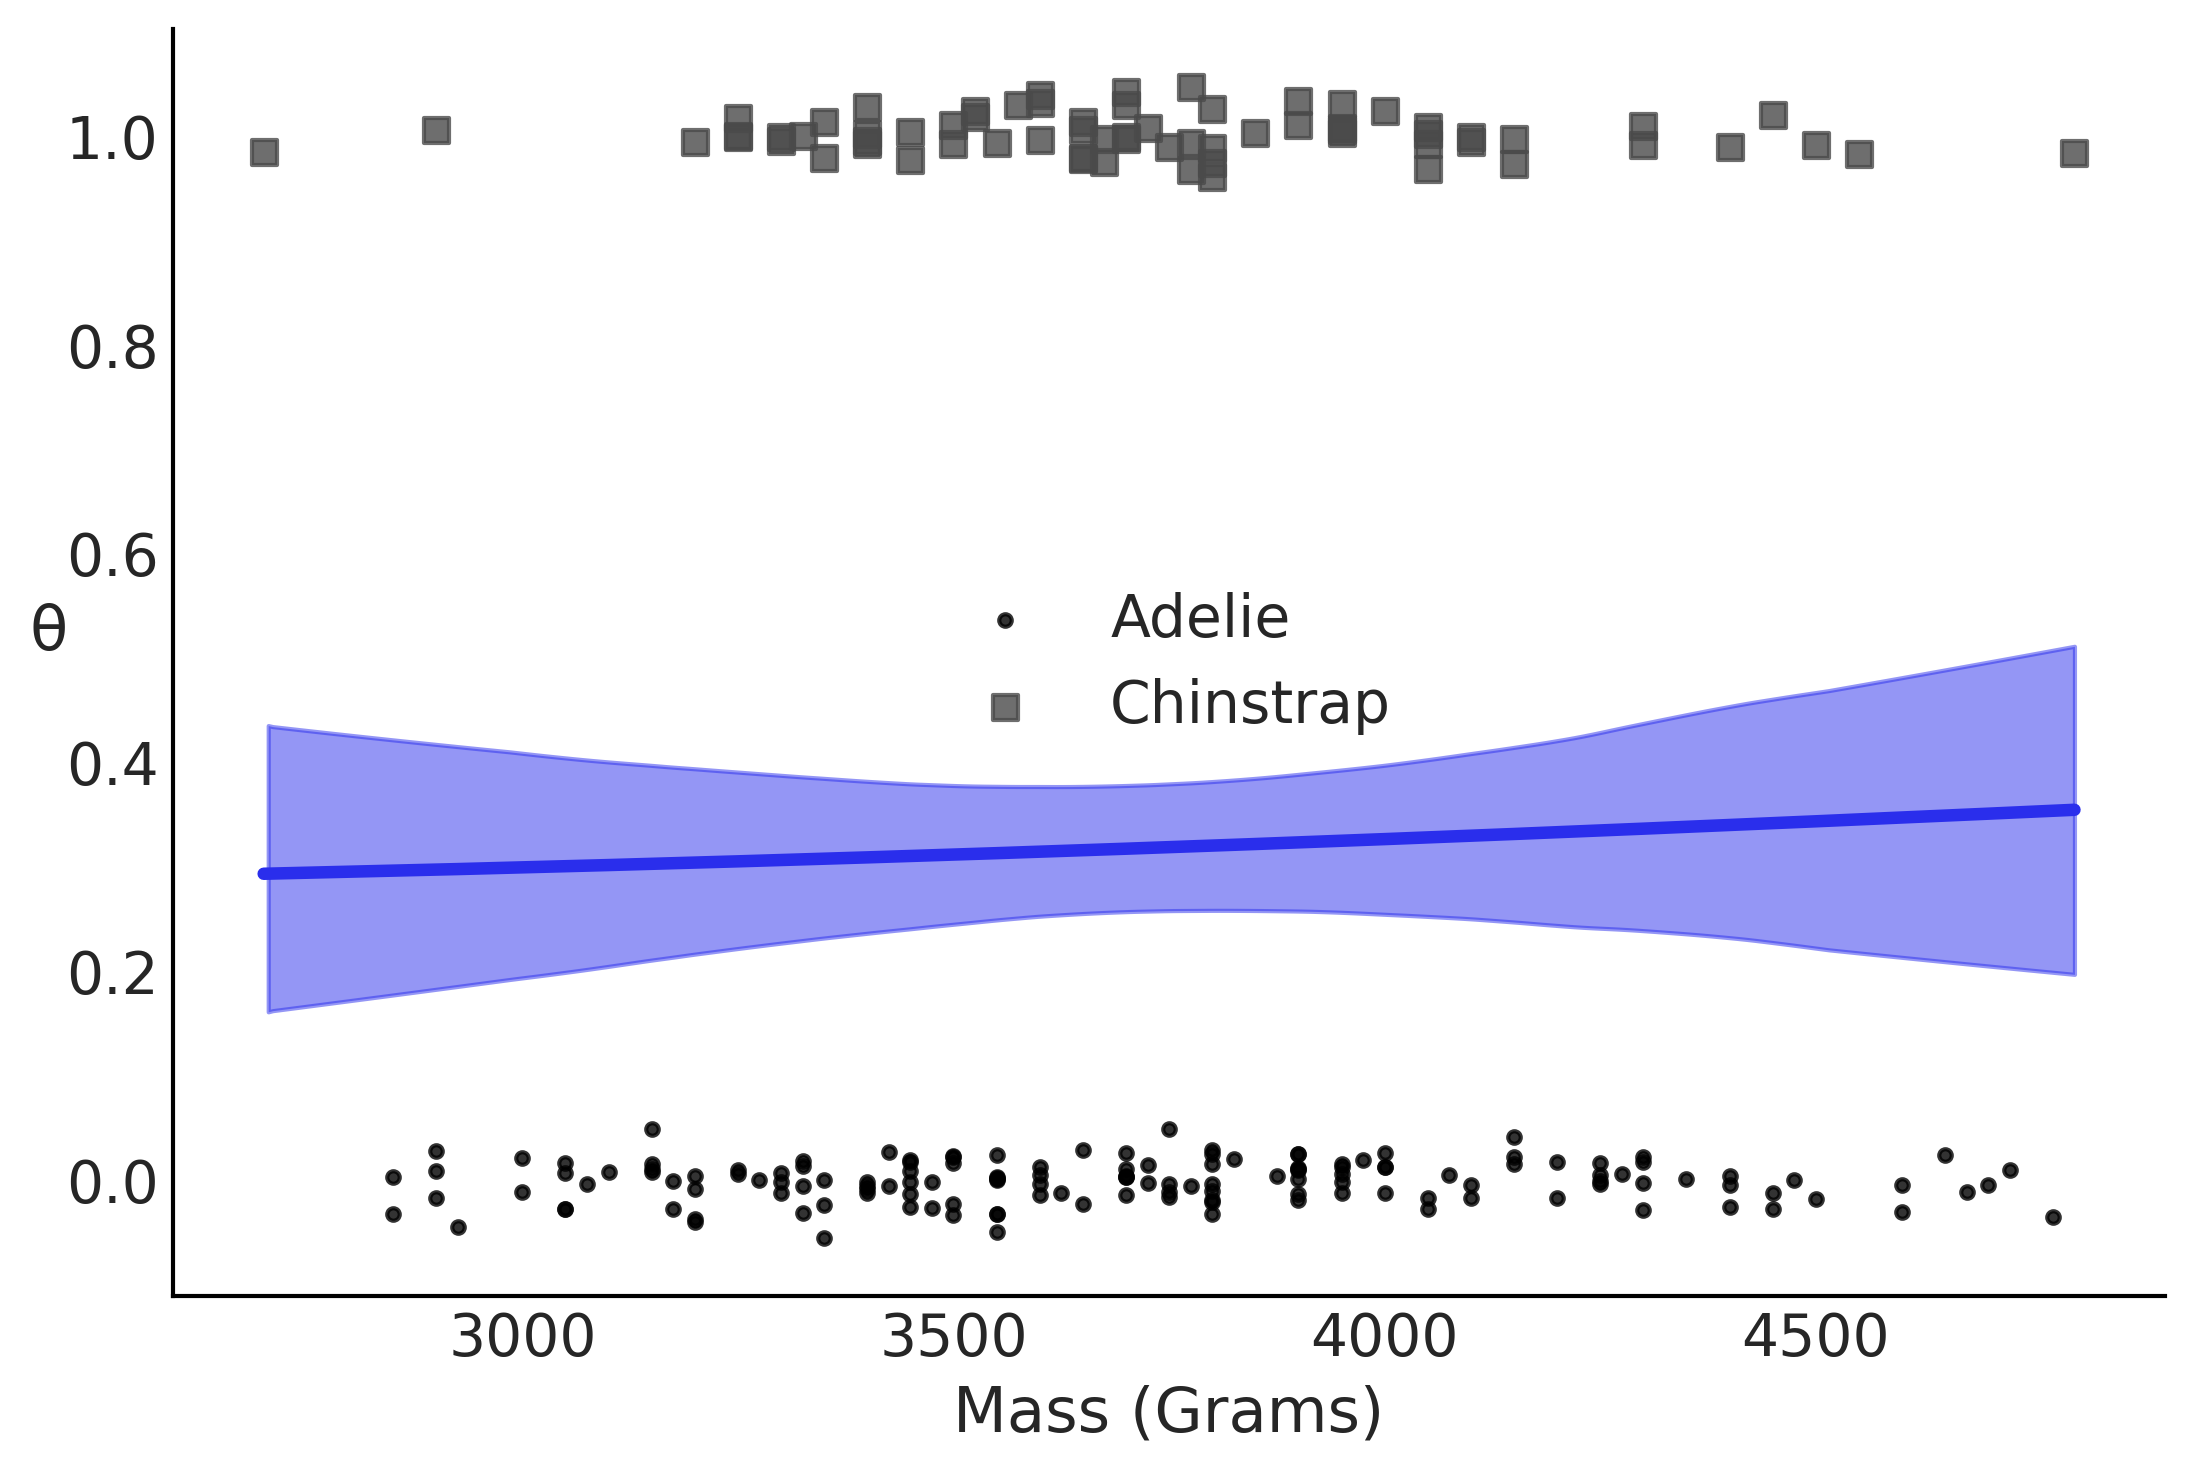

In [59]:
theta = idata_logistic_penguins_mass.posterior['θ'].mean(("chain", "draw"))
bd = idata_logistic_penguins_mass.posterior['bd']

fig, ax = plt.subplots()
idx = np.argsort(mass_obs)

ax.plot(mass_obs[idx], theta[idx], color='C4', lw=3)
for i, (label, marker) in enumerate(zip(species.categories, (".", "s"))):
    _filter = (species.codes == i)
    x = mass_obs[_filter]
    y = np.random.normal(i, 0.02, size=_filter.sum())
    ax.scatter(mass_obs[_filter], y, marker=marker, label=label, alpha=.8)



az.plot_hdi(mass_obs, idata_logistic_penguins_mass.posterior['θ'], color='C4', ax=ax)

ax.set_xlabel("Mass (Grams)")
ax.set_ylabel('θ', rotation=0)
plt.legend()

plt.savefig("img/chp03/logistic_mass.png")

We should not let this lack of relationship discourage us, effective
modeling includes a dose of trial an error. This does not mean try
random things and hope they work, it instead means that it is ok to use
the computational tools to provide you clues to the next step.

Let us now try using both bill length and mass to create a multiple
logistic regression in Code Block
[model_logistic_penguins_bill_length_mass](model_logistic_penguins_bill_length_mass)
and plot the decision boundary again in
{numref}`fig:Decision_Boundary_Logistic_mass_bill_length`. This time the
axes of the figure are a little bit different. Instead of the
probability of class on the Y-axis, we instead have mass. This way we
can see the decision boundary between the dependent variables. All these
visual checks have been helpful but subjective. We can quantify our fits
numerically as well using diagnostics.

```{code-block} python
:name: model_logistic_penguins_bill_length_mass
:caption: model_logistic_penguins_bill_length_mass

X = penguins.loc[species_filter, ["bill_length_mm", "body_mass_g"]]

# Add a column of 1s for the intercept
X.insert(0,"Intercept", value=1)
X = X.values

with pm.Model() as model_logistic_penguins_bill_length_mass:
    β = pm.Normal("β", mu=0, sigma=20, shape=3)

    μ = pm.math.dot(X, β)

    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))
    bd = pm.Deterministic("bd", -β[0]/β[2] - β[1]/β[2] * X[:,1])

    yl = pm.Bernoulli("yl", p=θ, observed=species.codes)

    inf_data_logistic_penguins_bill_length_mass = pm.sample(
        1000,
        return_inferencedata=True)
```

```{figure} figures/Decision_Boundary_Logistic_mass_bill_length.png
:name: fig:Decision_Boundary_Logistic_mass_bill_length
:width: 7.00in
Decision boundary of species class plotted against bill length and mass.
We can see that most of the species separability comes from bill length
although mass now adds some extra information in regards to class
separability as indicated by the slope of the line.
```

In [60]:
X = penguins.loc[species_filter, ["bill_length_mm", "body_mass_g"]]

# Add a column of 1s for the intercept
X.insert(0,"Intercept", value=1)
X = X.values

with pm.Model() as model_logistic_penguins_bill_length_mass:
    β = pm.Normal("β", mu=0, sigma=20, shape=3)

    μ = pm.math.dot(X, β)

    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))
    bd = pm.Deterministic("bd", -β[0]/β[2] - β[1]/β[2] * X[:,1])

    yl = pm.Bernoulli("yl", p=θ, observed=species.codes)

    idata_logistic_penguins_bill_length_mass = pm.sample(5000, chains=2,
                                                         random_seed=0, 
                                                         target_accept=.9,
                                                         idata_kwargs={"log_likelihood":True})
    idata_logistic_penguins_bill_length_mass.extend(pm.sample_posterior_predictive(idata_logistic_penguins_bill_length_mass))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β]


Output()

Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 19 seconds.
There were 1342 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [yl]


Output()

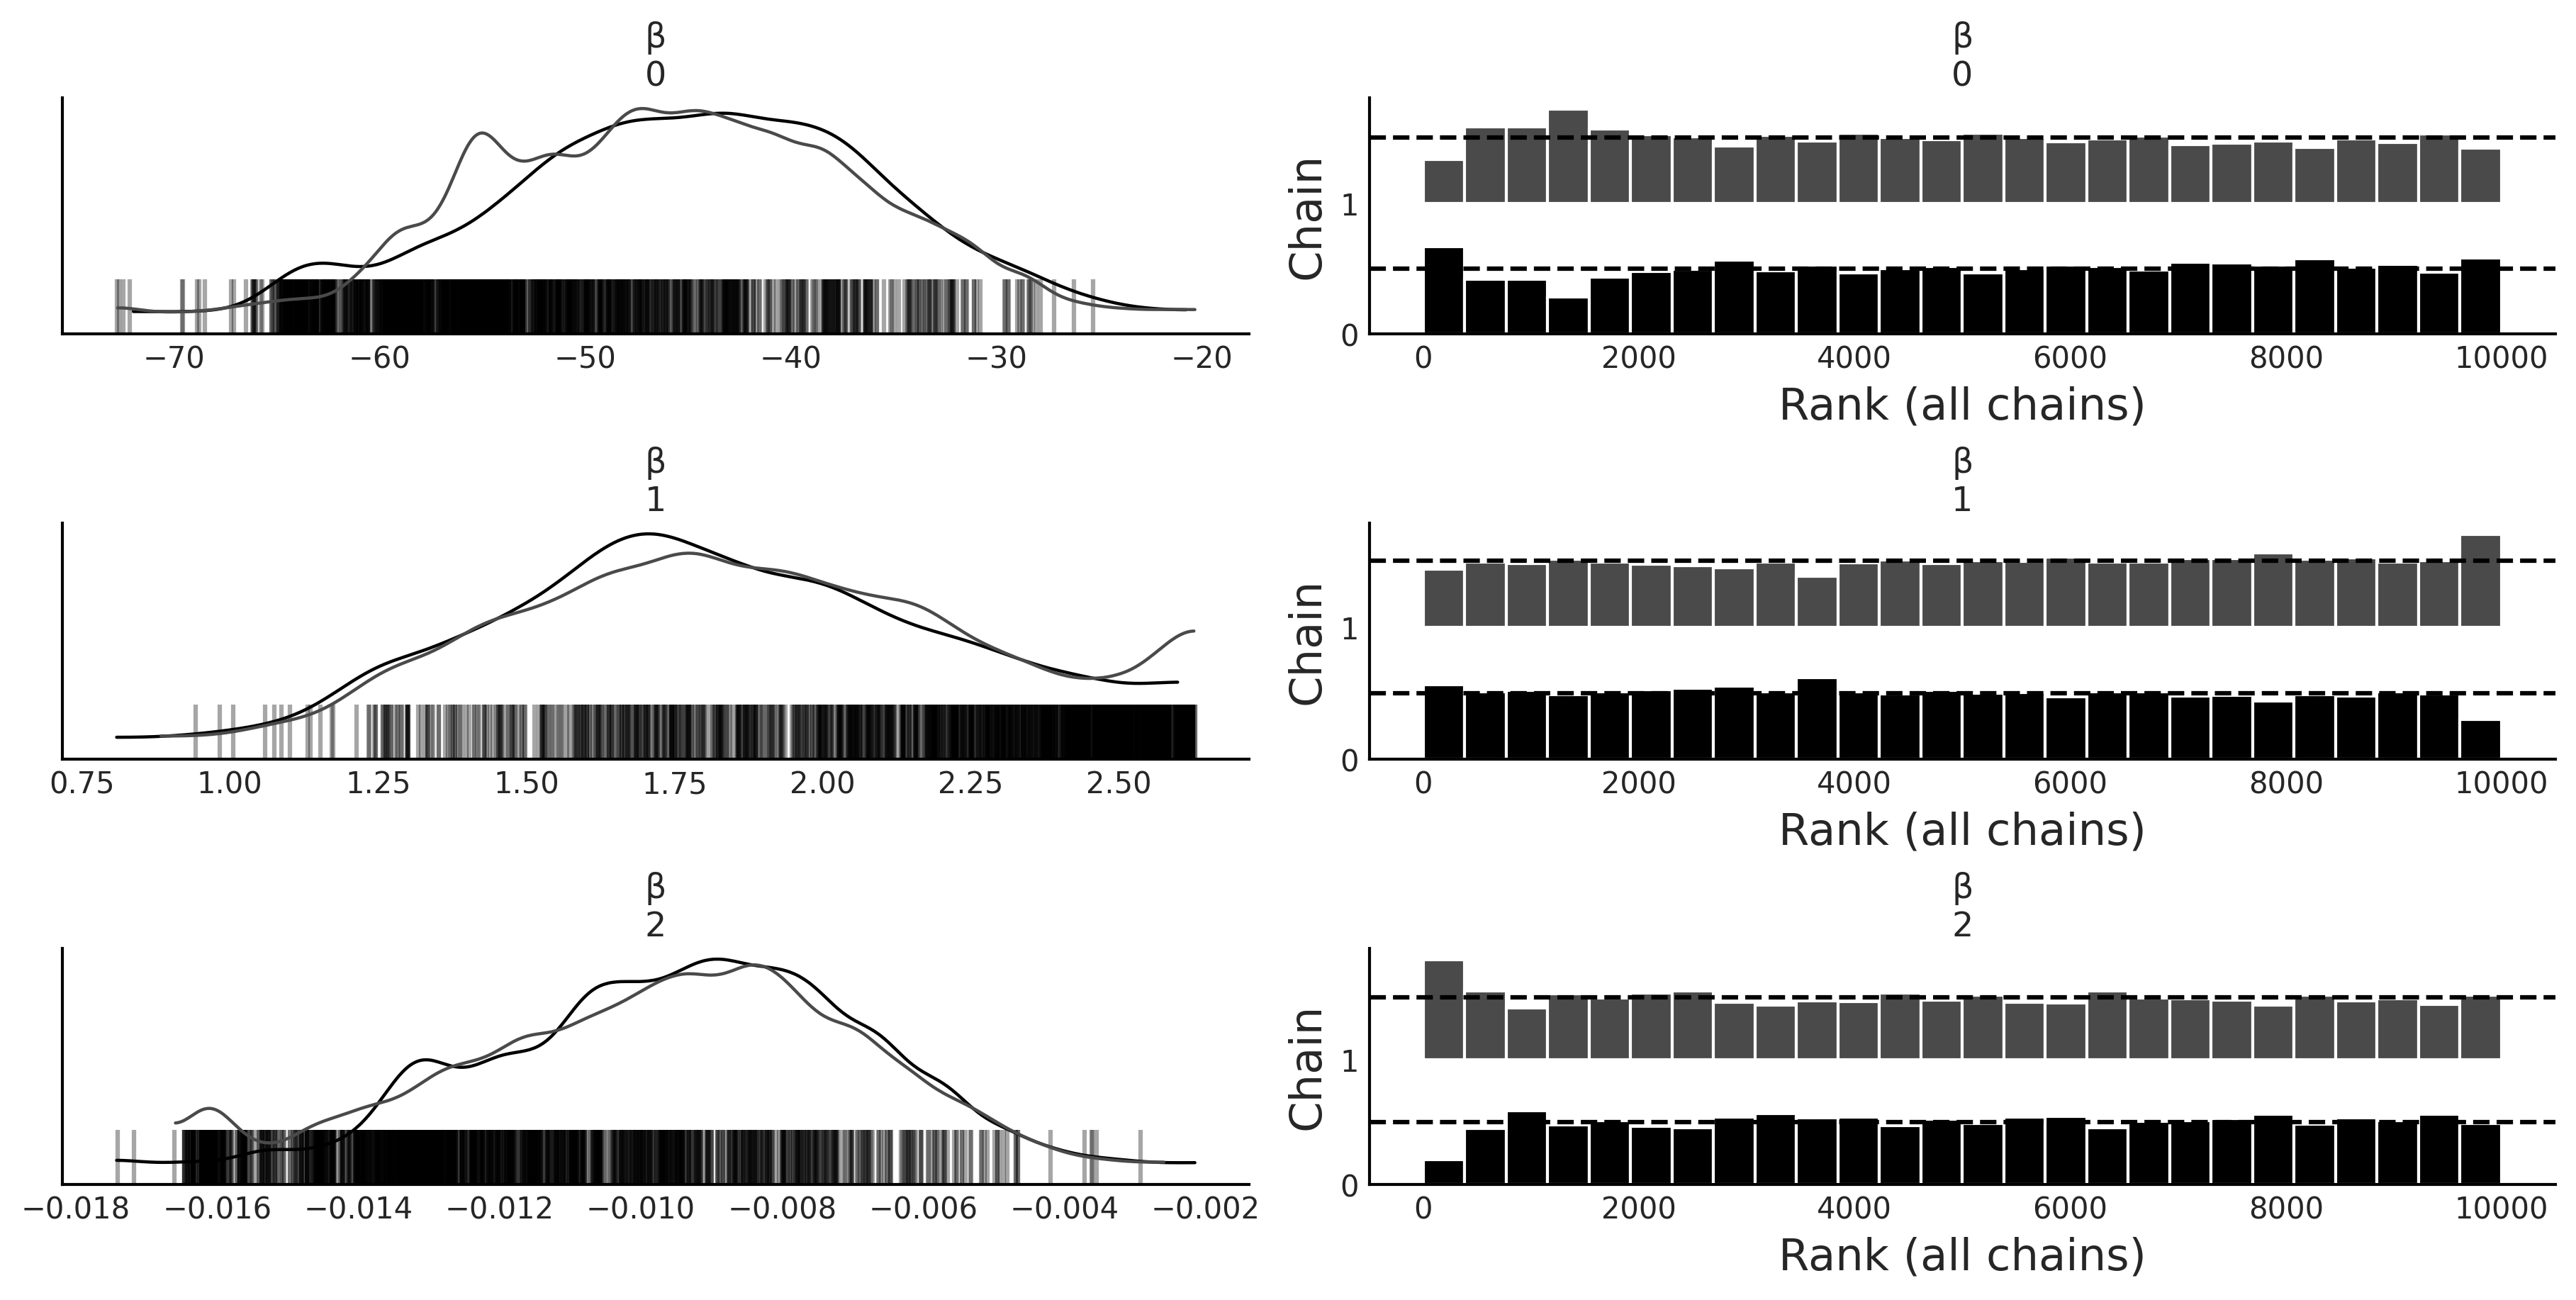

In [61]:
az.plot_trace(idata_logistic_penguins_bill_length_mass, compact=False, var_names=["β"], kind="rank_bars");

In [62]:
az.summary(idata_logistic_penguins_bill_length_mass, var_names=["β"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
β[0] -45.290  8.632 -59.944  -28.107      0.311    0.239     776.0     341.0   
β[1]   1.842  0.360   1.256    2.582      0.020    0.016     288.0      92.0   
β[2]  -0.010  0.003  -0.014   -0.005      0.000    0.000     323.0     110.0   

      r_hat  
β[0]   1.00  
β[1]   1.01  
β[2]   1.00

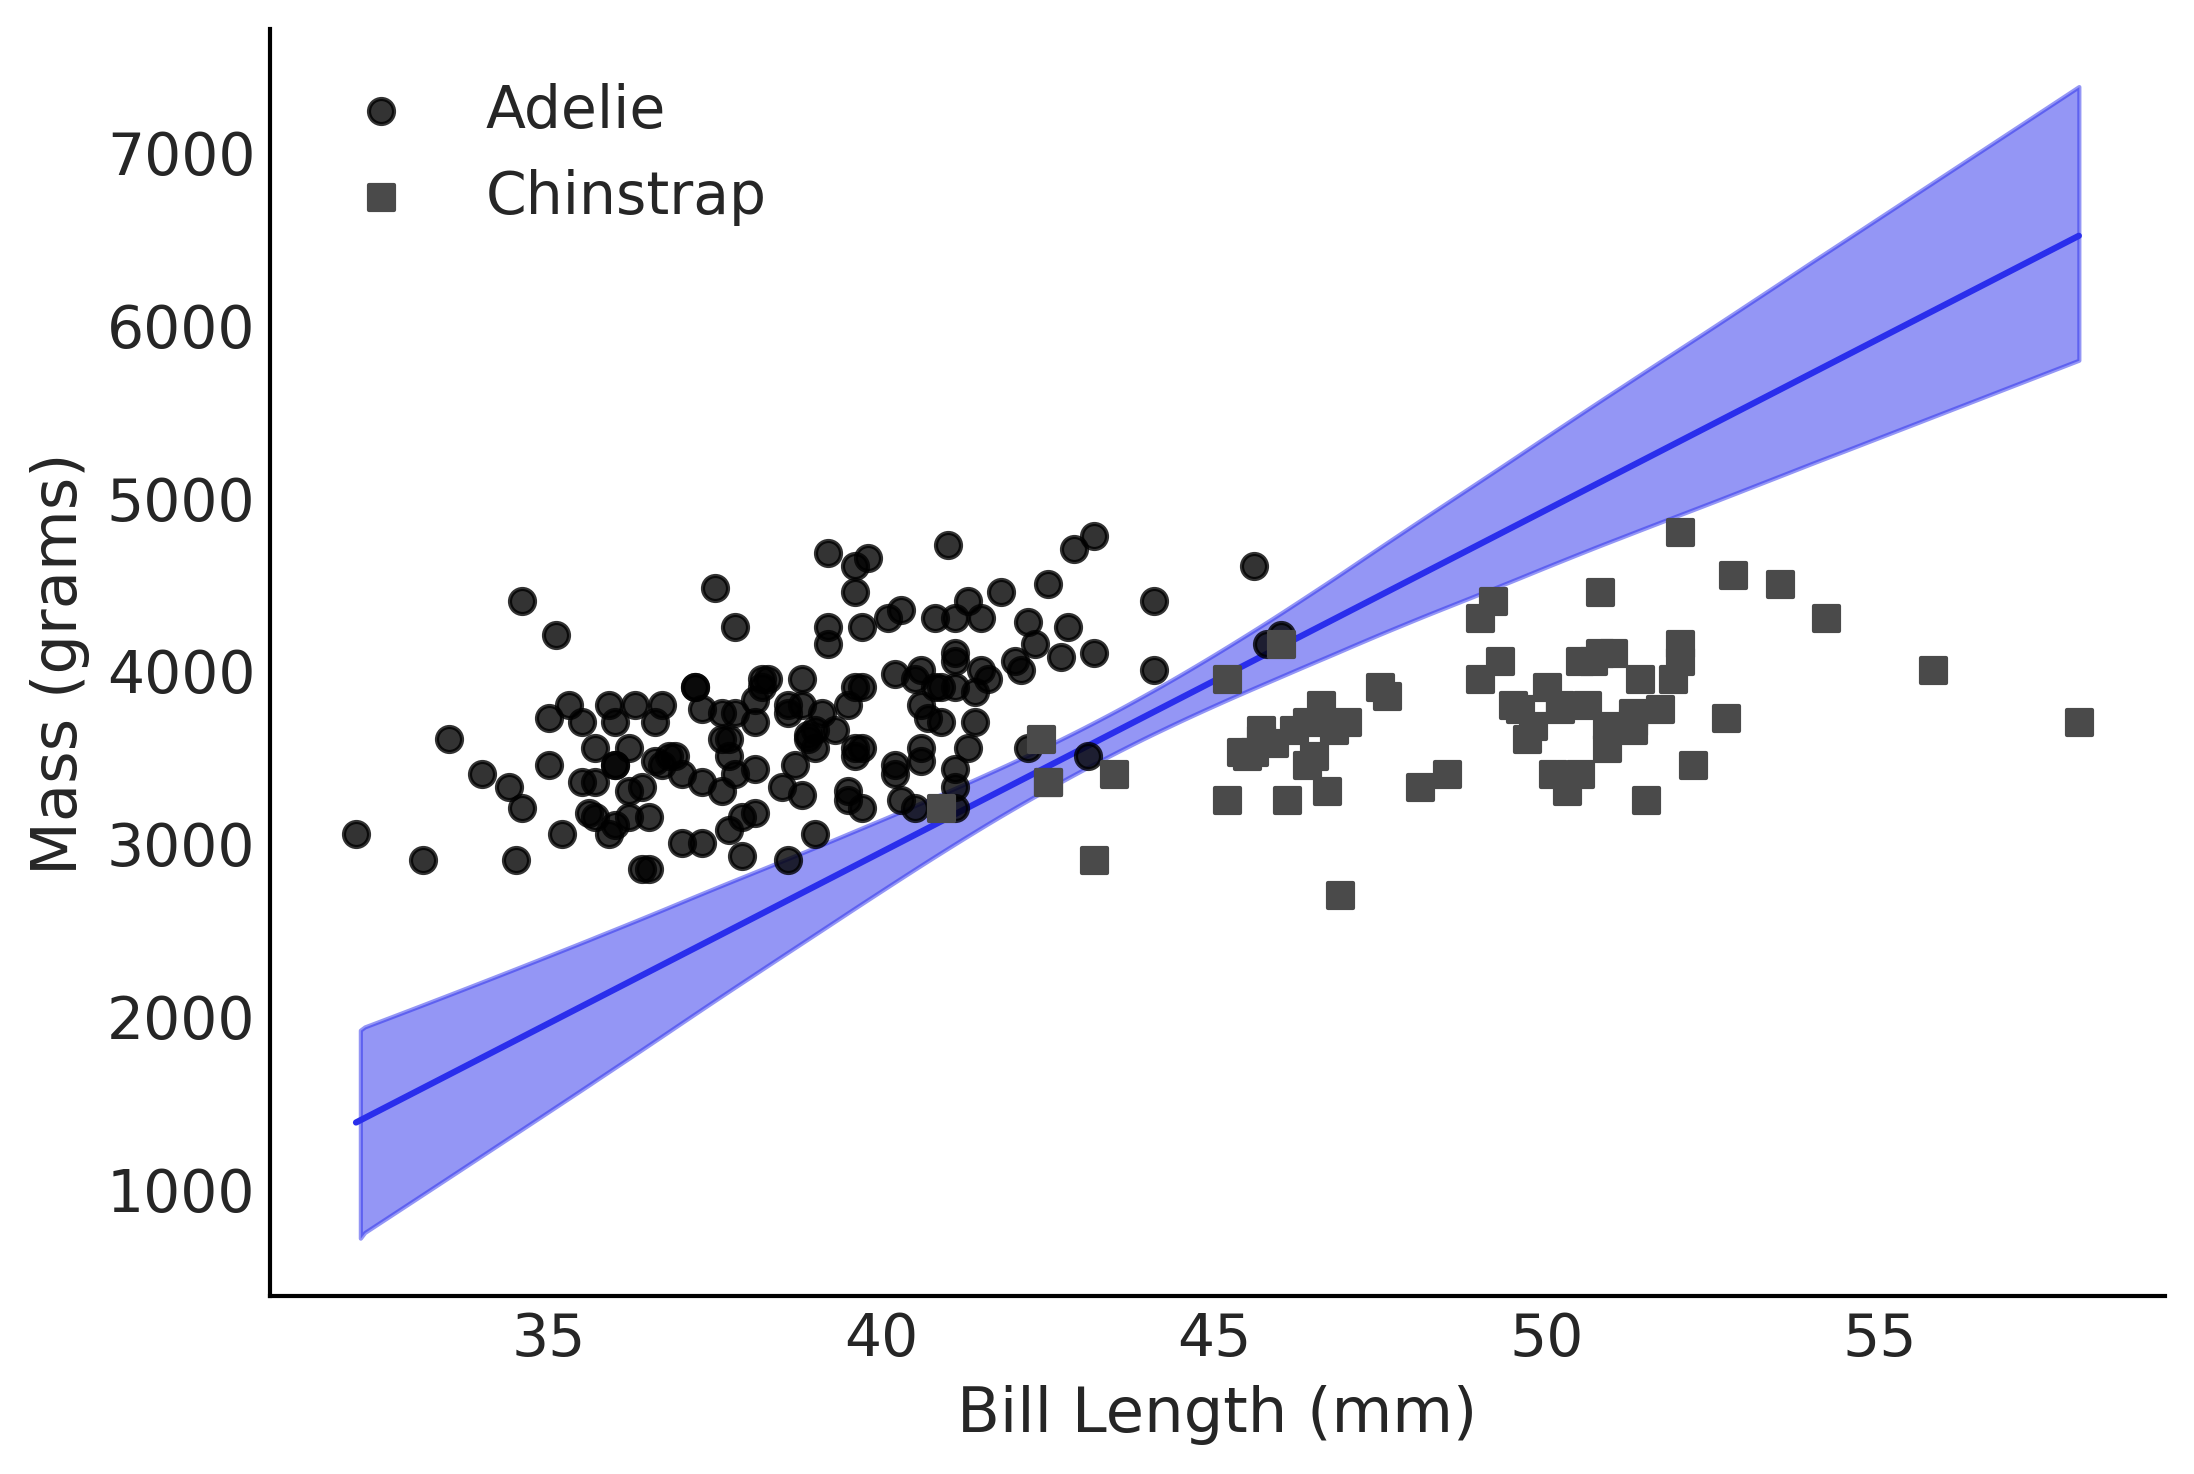

In [63]:
fig,ax  = plt.subplots()
idx = np.argsort(X[:,1])
bd = idata_logistic_penguins_bill_length_mass.posterior["bd"].mean(("chain", "draw"))[idx]


species_filter = species.codes.astype(bool)

# Linear fit
ax.plot(X[:,1][idx], bd, color='C4');
az.plot_hdi(X[:,1], idata_logistic_penguins_bill_length_mass.posterior["bd"], color='C4', ax=ax)

# Scatter
ax.scatter(X[~species_filter,1], X[~species_filter,2], alpha=.8,  label="Adelie", zorder=10)
ax.scatter(X[species_filter,1], X[species_filter,2], marker="s", label="Chinstrap", zorder=10)


ax.set_ylabel("Mass (grams)")
ax.set_xlabel("Bill Length (mm)")


ax.legend()
plt.savefig("img/chp03/decision_boundary_logistic_mass_bill_length.png");

To evaluate the model fit for logistic regressions we can use a
separation plot {cite:p}`separation_plot`, as shown in Code Block
[separability_plot](separability_plot) and
{numref}`fig:Penguins_Separation_Plot`. A separation plot is a way to
assess the calibration of a model with binary observed data. It shows
the sorted predictions per class, the idea being that with perfect
separation there would be two distinct rectangles. In our case we see
that none of our models did a perfect job separating the two species,
but the models that included bill length performed much better than the
model that included mass only. In general, perfect calibration is not
the goal of a Bayesian analysis, nevertheless separation plots (and
other calibration assessment methods like LOO-PIT) can help us to
compare models and reveal opportunities to improve them.

```{code-block} python
:name: separability_plot
:caption: separability_plot

models = {"bill": inf_data_logistic_penguins_bill_length,
          "mass": inf_data_logistic_penguins_mass,
          "mass bill": inf_data_logistic_penguins_bill_length_mass}

_, axes = plt.subplots(3, 1, figsize=(12, 4), sharey=True)
for (label, model), ax in zip(models.items(), axes):
    az.plot_separation(model, "yl", ax=ax, color="C4")
    ax.set_title(label)
```

```{figure} figures/Penguins_Separation_Plot.png
:name: fig:Penguins_Separation_Plot
:width: 7.00in
Separation plot of all three penguin models. The light versus dark value
indicates the binary class label. In this plot its much more evident
that the mass only model does a poor job separating the two species,
where are the bill and mass bill models perform better at this task.
```

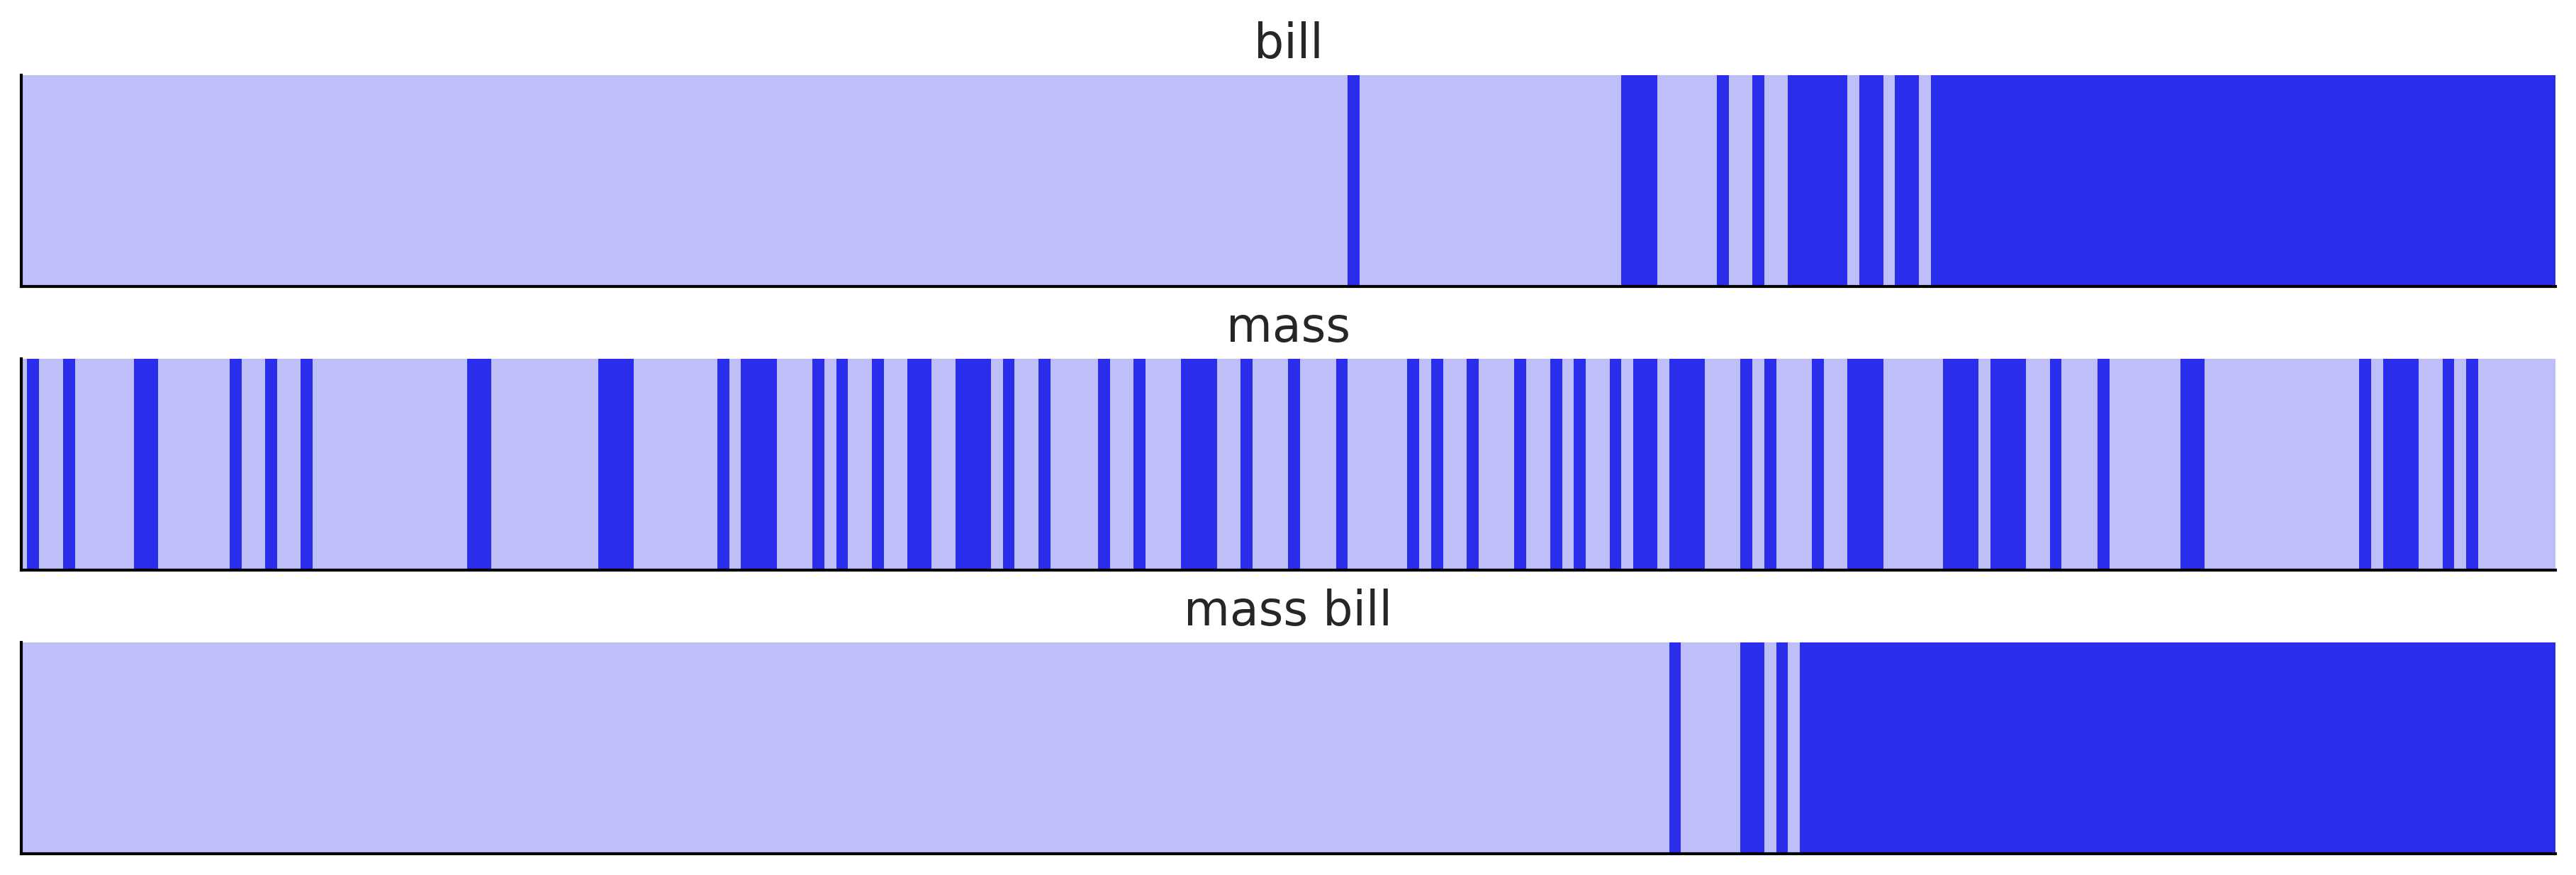

In [64]:
models = {"bill": idata_logistic_penguins_bill_length,
          "mass": idata_logistic_penguins_mass,
          "mass bill": idata_logistic_penguins_bill_length_mass}

_, axes = plt.subplots(3, 1, figsize=(12, 4), sharey=True)
for (label, model), ax in zip(models.items(), axes):
    az.plot_separation(model, "yl", ax=ax, color="C4")
    ax.set_title(label)

plt.savefig("img/chp03/penguins_separation_plot.png")

We can also use LOO to compare the three models we have just created,
the one for the mass, the one for the bill length and the one including
both covariates in Code Block
[penguin_model_loo](penguin_model_loo) and {numref}`tab:penguin_loo`. According to LOO the mass only
model is the worst at separating the species, the bill length only is
the middle candidate model, and the mass and bill length model performed
the best. This is unsurprising given what we have seen from the plots,
and now we have a numerical confirmation as well.

```{code-block} python
:name: penguin_model_loo
:caption: penguin_model_loo

az.compare({"mass":inf_data_logistic_penguins_mass,
            "bill": inf_data_logistic_penguins_bill_length,
            "mass_bill":inf_data_logistic_penguins_bill_length_mass})
```

```{list-table} Summary of model comparison. Models are ranked from lowest to highest ELPD values (loo column).
:name: tab:penguin_loo
* -
  - **rank**
  - **loo**
  - **p_loo**
  - **d_loo**
  - **weight**
  - **se**
  - **dse**
  - **warning**
  - **loo_scale**
* - **mass_bill**
  - 0
  - -11.3
  -  1.6
  -  0.0
  -  1.0
  -  3.1
  -  0.0
  -  True
  -  log
* - **bill**
  - 1
  - -27.0
  -   1.7
  -  15.6
  -   0.0
  -   6.2
  -   4.9
  -  True
  -  log
* - **mass**
  -  2
  - -135.8
  -  2.1
  -  124.5
  -   0.0
  -  5.3
  - 5.8
  -  True
  -  log
```

In [65]:
az.compare({"mass": idata_logistic_penguins_mass,
            "bill": idata_logistic_penguins_bill_length,
            "mass_bill": idata_logistic_penguins_bill_length_mass}).round(1)

/home/hwting/anaconda3/envs/rapids/lib/python3.11/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


rank  elpd_loo  p_loo  elpd_diff  weight   se  dse  warning scale
mass_bill     0     -11.4    1.6        0.0     1.0  3.1  0.0     True   log
bill          1     -28.0    1.0       16.6     0.0  5.0  3.9    False   log
mass          2    -135.6    1.9      124.3     0.0  5.3  5.8    False   log

(log_odds)=

### 3.4.3 Interpreting Log Odds

In a logistic regression the slope is telling you the increase in log
odds units when x is incremented one unit. Odds most simply are the
ratio between the probability of occurrence and probability of no
occurrence. For example, in our penguin example if we were to pick a
random penguin from Adelie or Chinstrap penguins the probability that we
pick an Adelie penguin would be 0.68 as seen in Code Block
[adelie_prob](adelie_prob)


```{code-block} python
:name: adelie_prob
:caption: adelie_prob

# Class counts of each penguin species
counts = penguins["species"].value_counts()
adelie_count = counts["Adelie"],
chinstrap_count = counts["Chinstrap"]
adelie_count / (adelie_count + chinstrap_count)
```

```
array([0.68224299])
```

In [66]:
penguins.loc[:,"species"].value_counts()

species
Adelie       146
Gentoo       119
Chinstrap     68
Name: count, dtype: int64

In [67]:
counts = penguins["species"].value_counts()
adelie_count = counts["Adelie"],
chinstrap_count = counts["Chinstrap"]
adelie_count / (adelie_count+chinstrap_count)

array([0.68224299])

And for the same event the odds would be

```{code-block} python
:name: adelie_odds
:caption: adelie_odds

adelie_count / chinstrap_count
```

```
array([2.14705882])
```

In [68]:
adelie_count / chinstrap_count

array([2.14705882])

In [69]:
idata_logistic_penguins_bill_length.posterior["β_0"].mean().item()

-34.515911796823765

In [70]:
β_0 = idata_logistic_penguins_bill_length.posterior["β_0"].mean().item()
β_1 = idata_logistic_penguins_bill_length.posterior["β_1"].mean().item()

In [71]:
β_0

-34.515911796823765

In [72]:
β_1

0.7803763949119994

Odds are made up of the same components as probability but are
transformed in a manner that makes interpreting the ratio of one event
occurring from another more straightforward. Stated in odds, if we were
to randomly sample from Adelie and Chinstrap penguins we would expect to
end up with a ratio of 2.14 more Adelie penguins than Chinstrap penguins
as calculated by Code Block [adelie_odds](adelie_odds).

Using our knowledge of odds we can define the logit. The logit is the
natural log of the odds which is the fraction shown in Equation
{eq}`eq:logit`. We can rewrite the logistic regression in Equation
{eq}`eq:logistic` in an alternative form of using the logit.

```{math}
:label: eq:logit
\log \left(\frac{p}{1-p} \right) = \boldsymbol{X} \beta

```

This alternative formulation lets us interpret the coefficients of
logistic regression as the change in log odds. Using this knowledge we
can calculate the probability of observing Adelie to Chinstrap penguins
given a change in the observed bill length as shown in Code Block
[logistic_interpretation](logistic_interpretation).
Transformations like these are both interesting mathematically, but also
very practically useful when discussing statistical results, a topic we
will discuss more deeply in {ref}`section_sharing_results`).

```{code-block} python
:name: logistic_interpretation
:caption: logistic_interpretation

x = 45
β_0 = inf_data_logistic_penguins_bill_length.posterior["β_0"].mean().values
β_1 = inf_data_logistic_penguins_bill_length.posterior["β_1"].mean().values
bill_length = 45

val_1 = β_0 + β_1*bill_length
val_2 = β_0 + β_1*(bill_length+1)

f"""(Class Probability change from 45mm Bill Length to 46mm:
{(special.expit(val_2) -  special.expit(val_1))*100:.0f}%)"""
```

```
'Class Probability change from 45mm Bill Length to 46mm: 15%'
```

In [73]:
bill_length = 45
val_1 = β_0 + β_1 * bill_length
val_2 = β_0 + β_1 * (bill_length+1)

f"Class Probability change from 45mm Bill Length to 46mm: {(special.expit(val_2) - special.expit(val_1))*100:.0f}%"

'Class Probability change from 45mm Bill Length to 46mm: 15%'

In [74]:
bill_length = np.array([30, 45])
val_1 = β_0 + β_1 * bill_length
val_2 = β_0 + β_1 * (bill_length+1)

#f"Slope Change {(val_2 - val_1):.2f} Probability Change {(special.expit(val_2) - special.expit(val_1)):.2f}"

In [75]:
special.expit(val_2) - special.expit(val_1)

array([1.77839959e-05, 1.53325135e-01])

(picking-priors-in-regression-models)=

## 3.5 Picking Priors in Regression Models

Now that we are familiar with generalized linear models let us focus on
the prior and its effect on posterior estimation. We will be borrowing
an example from Regression and Other Stories {cite:p}`ROS`, in particular a
study{cite:p}`LikehoodandPrior` where the relationship between the
attractiveness of parents and the percentage of girl births of those
parents is explored. In this study researchers estimated the
attractiveness of American teenagers on a five-point scale. Eventually
many of these subjects had children, of which the ratio of gender per
each attractiveness category was calculated, the resulting data points
of which are shown in Code Block
[uninformative_prior_sex_ratio](uninformative_prior_sex_ratio)
and plotted in {numref}`fig:BeautyRatio`. In the same code block we also
write a model for single variable regression. This time however, focus
specifically on how priors and likelihoods should be assessed together
and not independently.

```{figure} figures/BeautyRatio.png
:name: fig:BeautyRatio
:width: 7.00in
Data on the attractiveness of parents plotted against the gender ratio
of their children.
```

In [76]:
x = np.arange(-2,3,1)
y = [50, 44, 50, 47, 56]

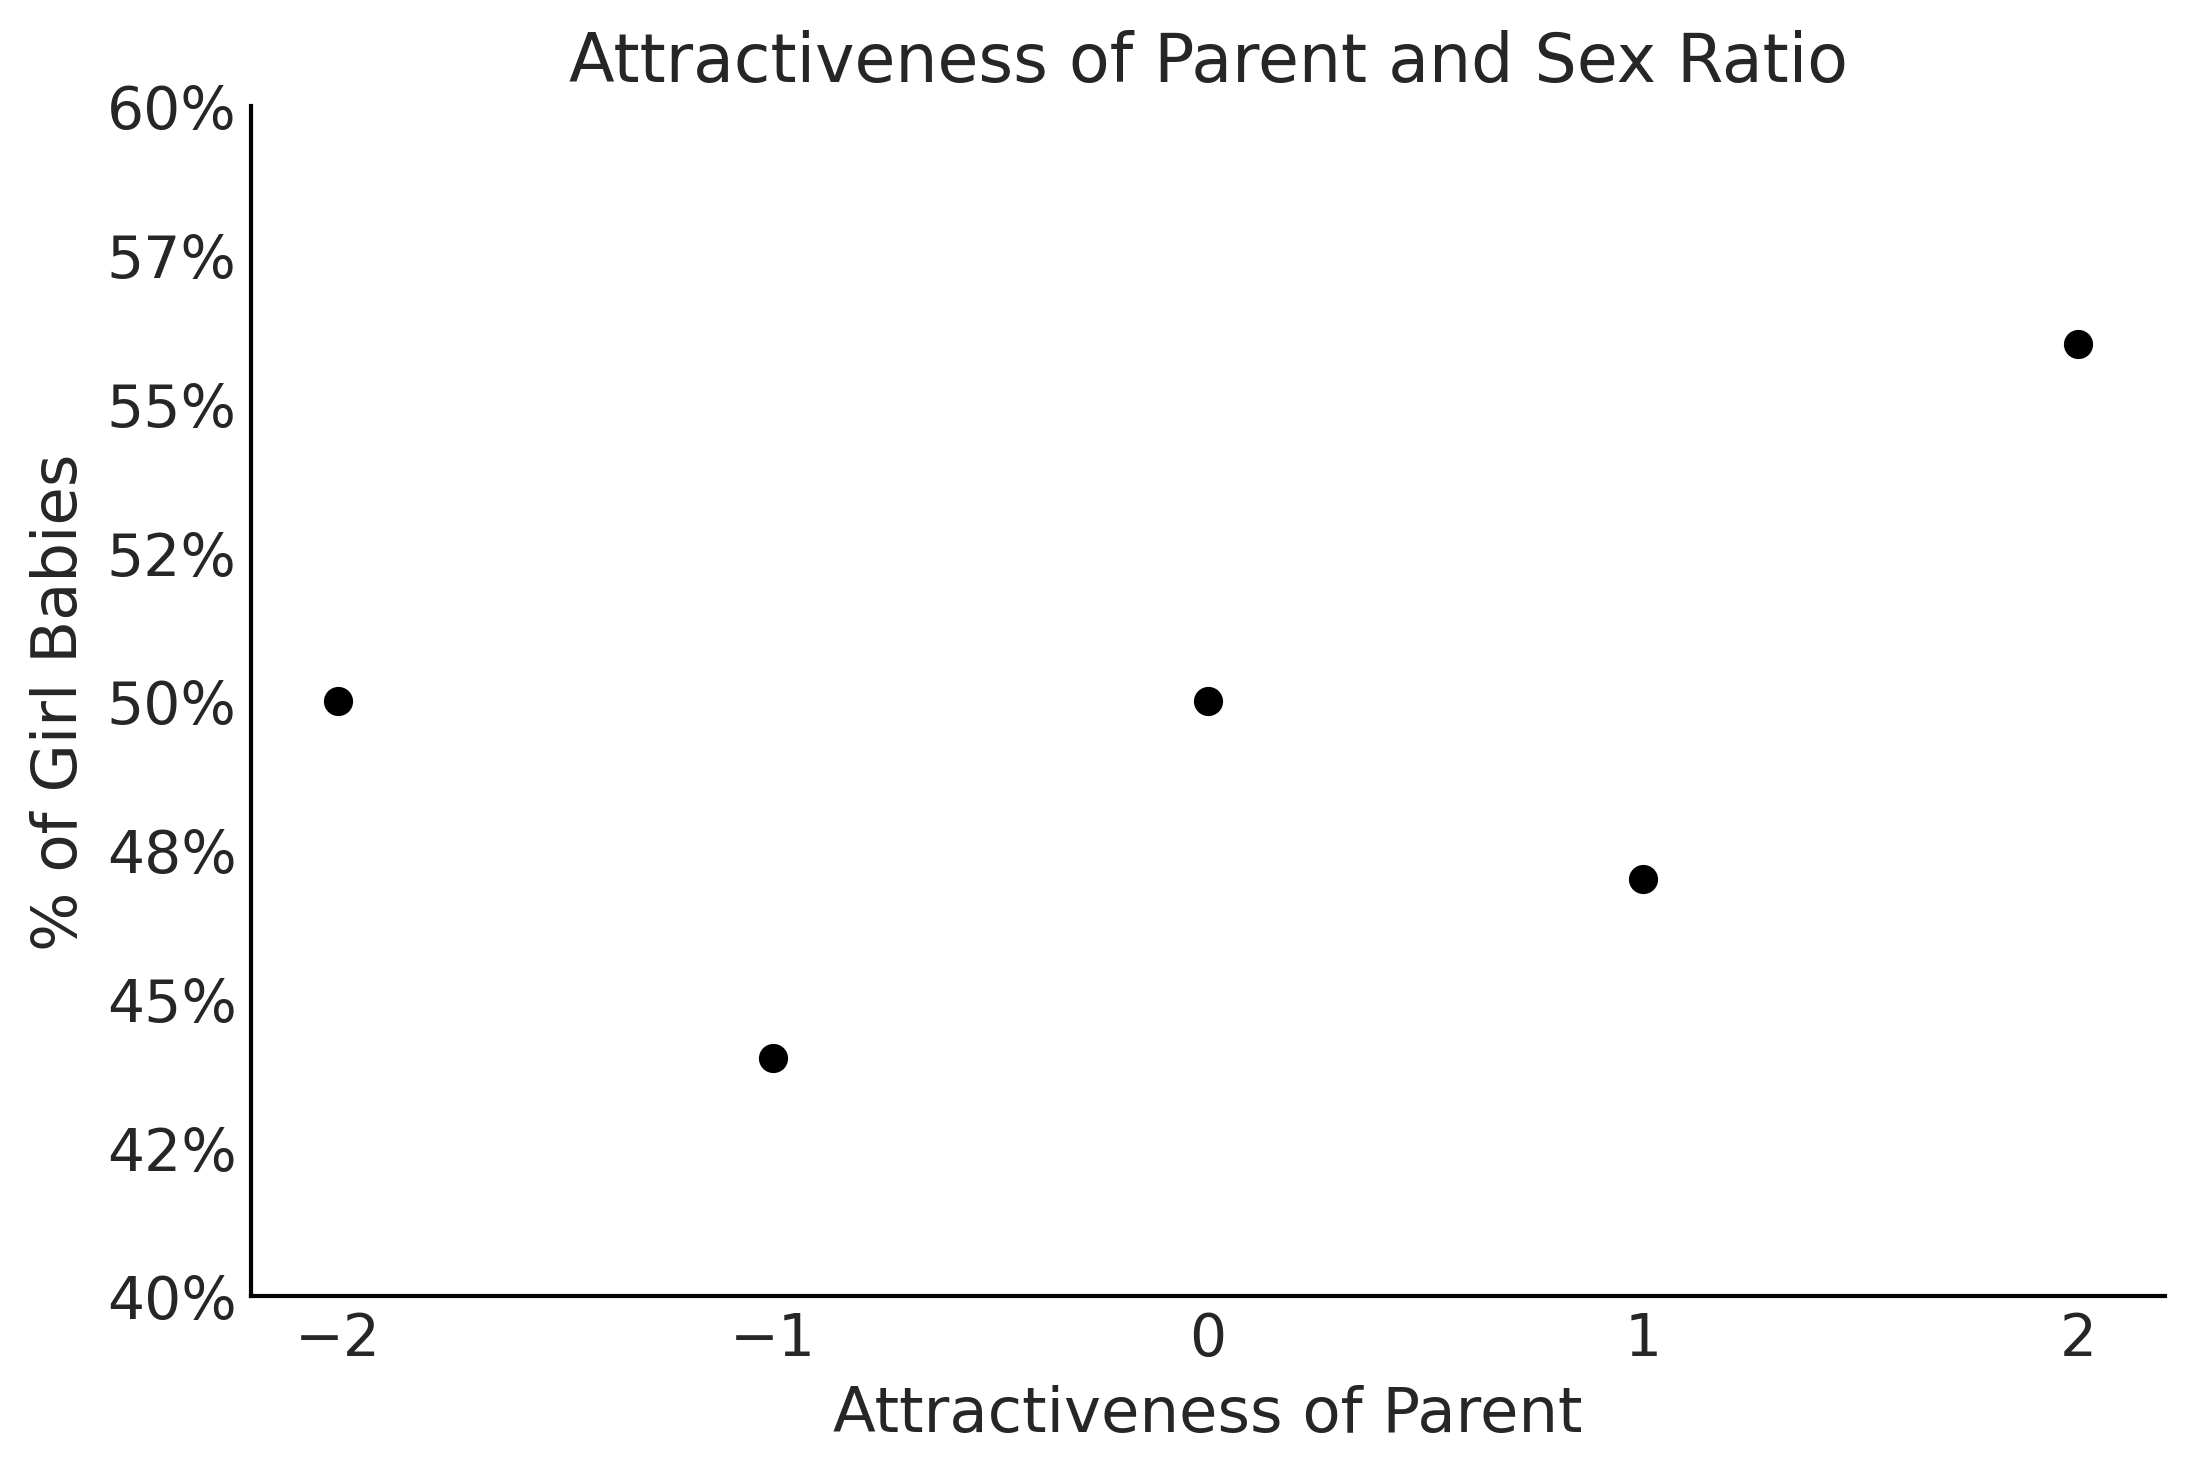

In [77]:
import matplotlib.ticker as mtick
fig, ax = plt.subplots()

ax.scatter(x, y)
ax.set_xticks(x)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax.set_ylim(40, 60)
ax.set_xlabel("Attractiveness of Parent")
ax.set_ylabel("% of Girl Babies")
ax.set_title("Attractiveness of Parent and Sex Ratio")
plt.savefig("img/chp03/beautyratio.png")

```{code-block} python
:name: uninformative_prior_sex_ratio
:caption: uninformative_prior_sex_ratio

x = np.arange(-2, 3, 1)
y = np.asarray([50, 44, 50, 47, 56])

with pm.Model() as model_uninformative_prior_sex_ratio:
    σ = pm.Exponential("σ", .5)
    β_1 = pm.Normal("β_1", 0, 20)
    β_0 = pm.Normal("β_0", 50, 20)

    μ = pm.Deterministic("μ", β_0 + β_1 * x)

    ratio = pm.Normal("ratio", mu=μ, sigma=σ, observed=y)

    prior_predictive_uninformative_prior_sex_ratio = pm.sample_prior_predictive(
        samples=10000
    )
    trace_uninformative_prior_sex_ratio = pm.sample()
    inf_data_uninformative_prior_sex_ratio = az.from_pymc3(
        trace=trace_uninformative_prior_sex_ratio,
        prior=prior_predictive_uninformative_prior_sex_ratio
    )
```

```{figure} figures/PosteriorUninformativeLinearRegression.png
:name: fig:PosteriorUninformativeLinearRegression
:width: 7.00in
With vague or very wide priors the model shows that large differences in
birth ratios are possible for parents rated as attractive. Some of these
possible fits are as large as a 20% change which seems implausible as no
other study has shown an effect this large on the sex ratio of births.
```

In [78]:
with pm.Model() as model_uninformative_prior_sex_ratio:
    σ = pm.Exponential("σ", .5)
    β_1 = pm.Normal("β_1", 0, 20)
    β_0 = pm.Normal("β_0", 50, 20)

    μ = pm.Deterministic("μ", β_0 + β_1 * x)

    ratio = pm.Normal("ratio", mu=μ, sigma=σ, observed=y)

    idata_uninformative_prior_sex_ratio = pm.sample(random_seed=0)
    idata_uninformative_prior_sex_ratio.extend(pm.sample_prior_predictive(samples=10000))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β_1, β_0]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [ratio, β_0, β_1, σ]


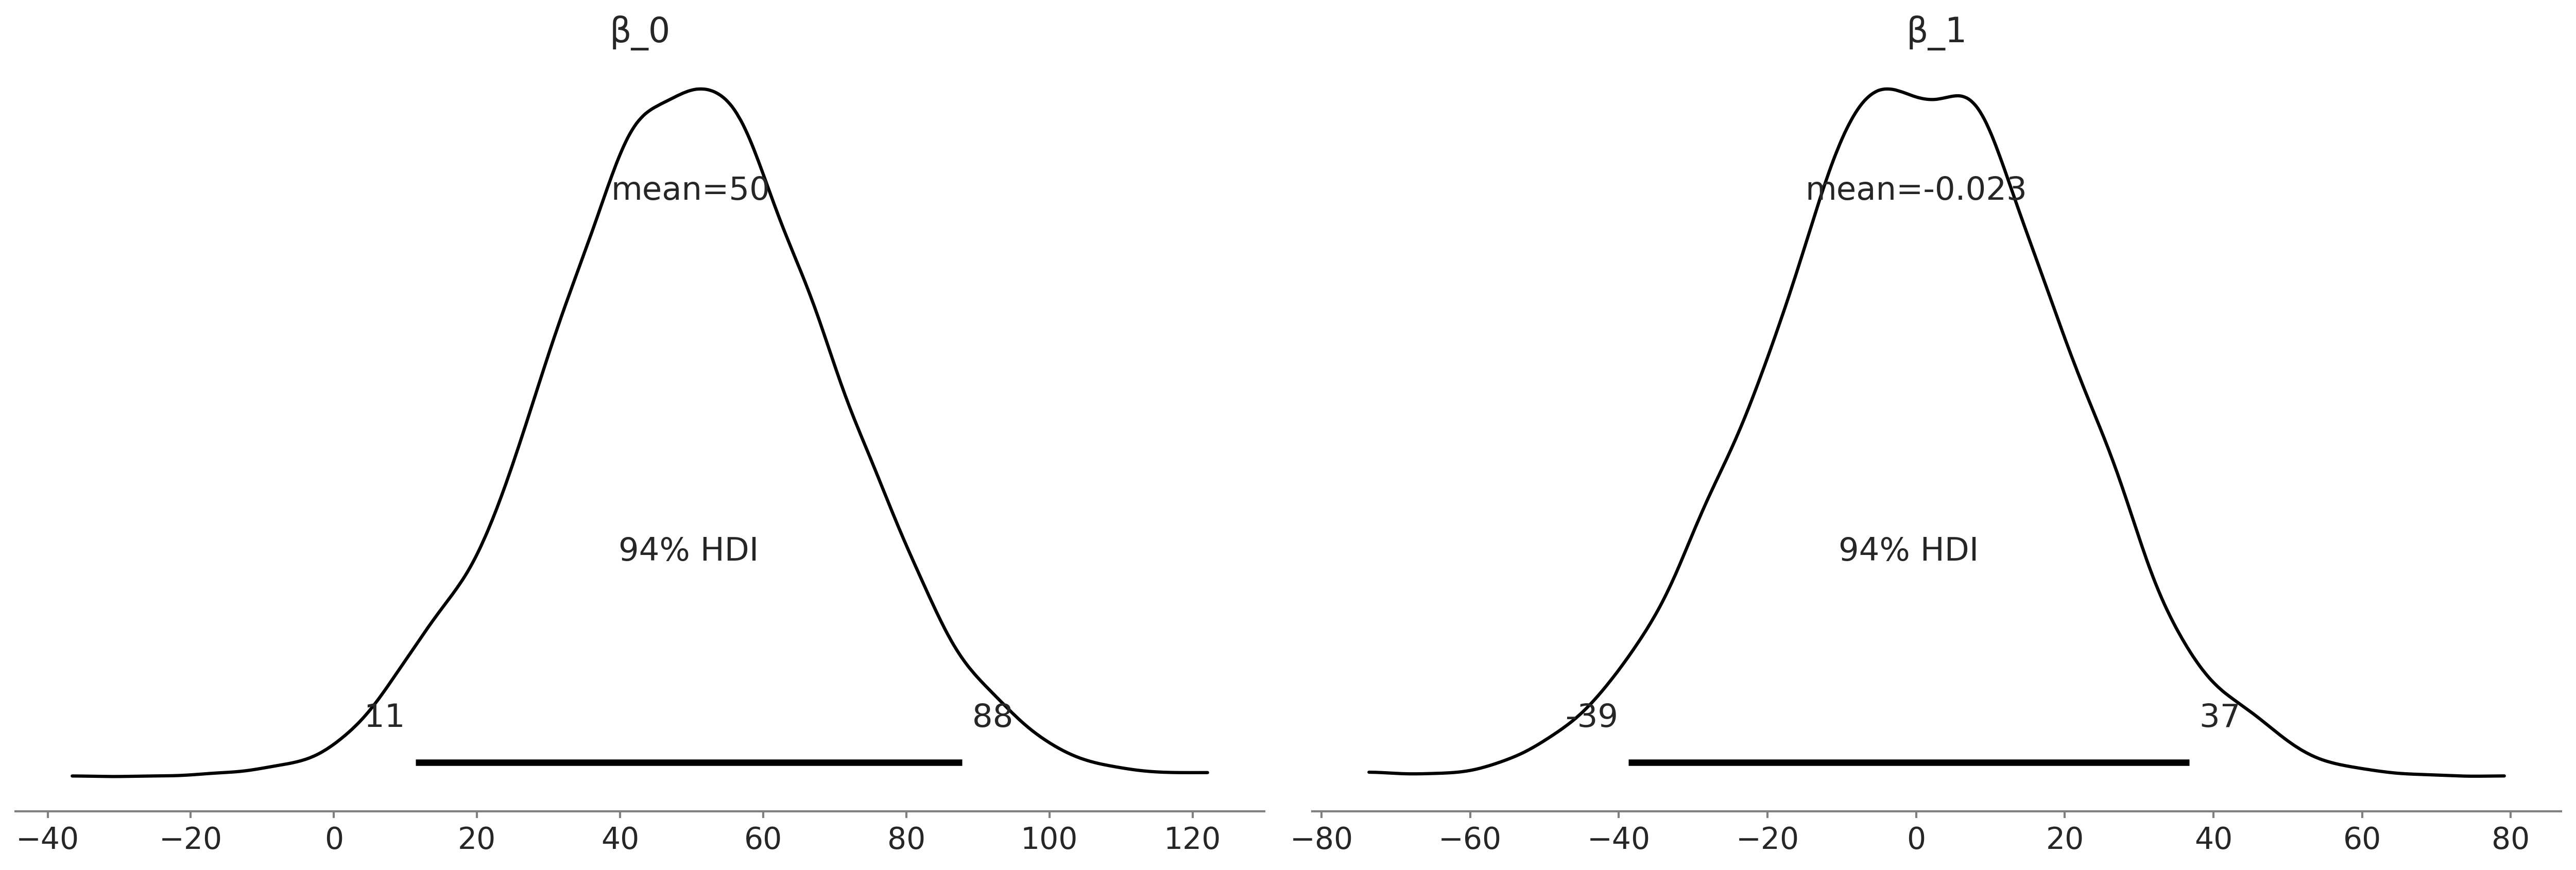

In [79]:
az.plot_posterior(idata_uninformative_prior_sex_ratio.prior, var_names=["β_0", "β_1"])
plt.savefig("img/chp03/priorpredictiveuninformativeKDE.png")

In [80]:
az.summary(idata_uninformative_prior_sex_ratio, var_names=["β_0", "β_1", "σ"], kind="stats")

mean     sd  hdi_3%  hdi_97%
β_0  49.363  2.039  45.082   53.051
β_1   1.542  1.430  -1.119    4.396
σ     4.298  1.542   1.973    7.106

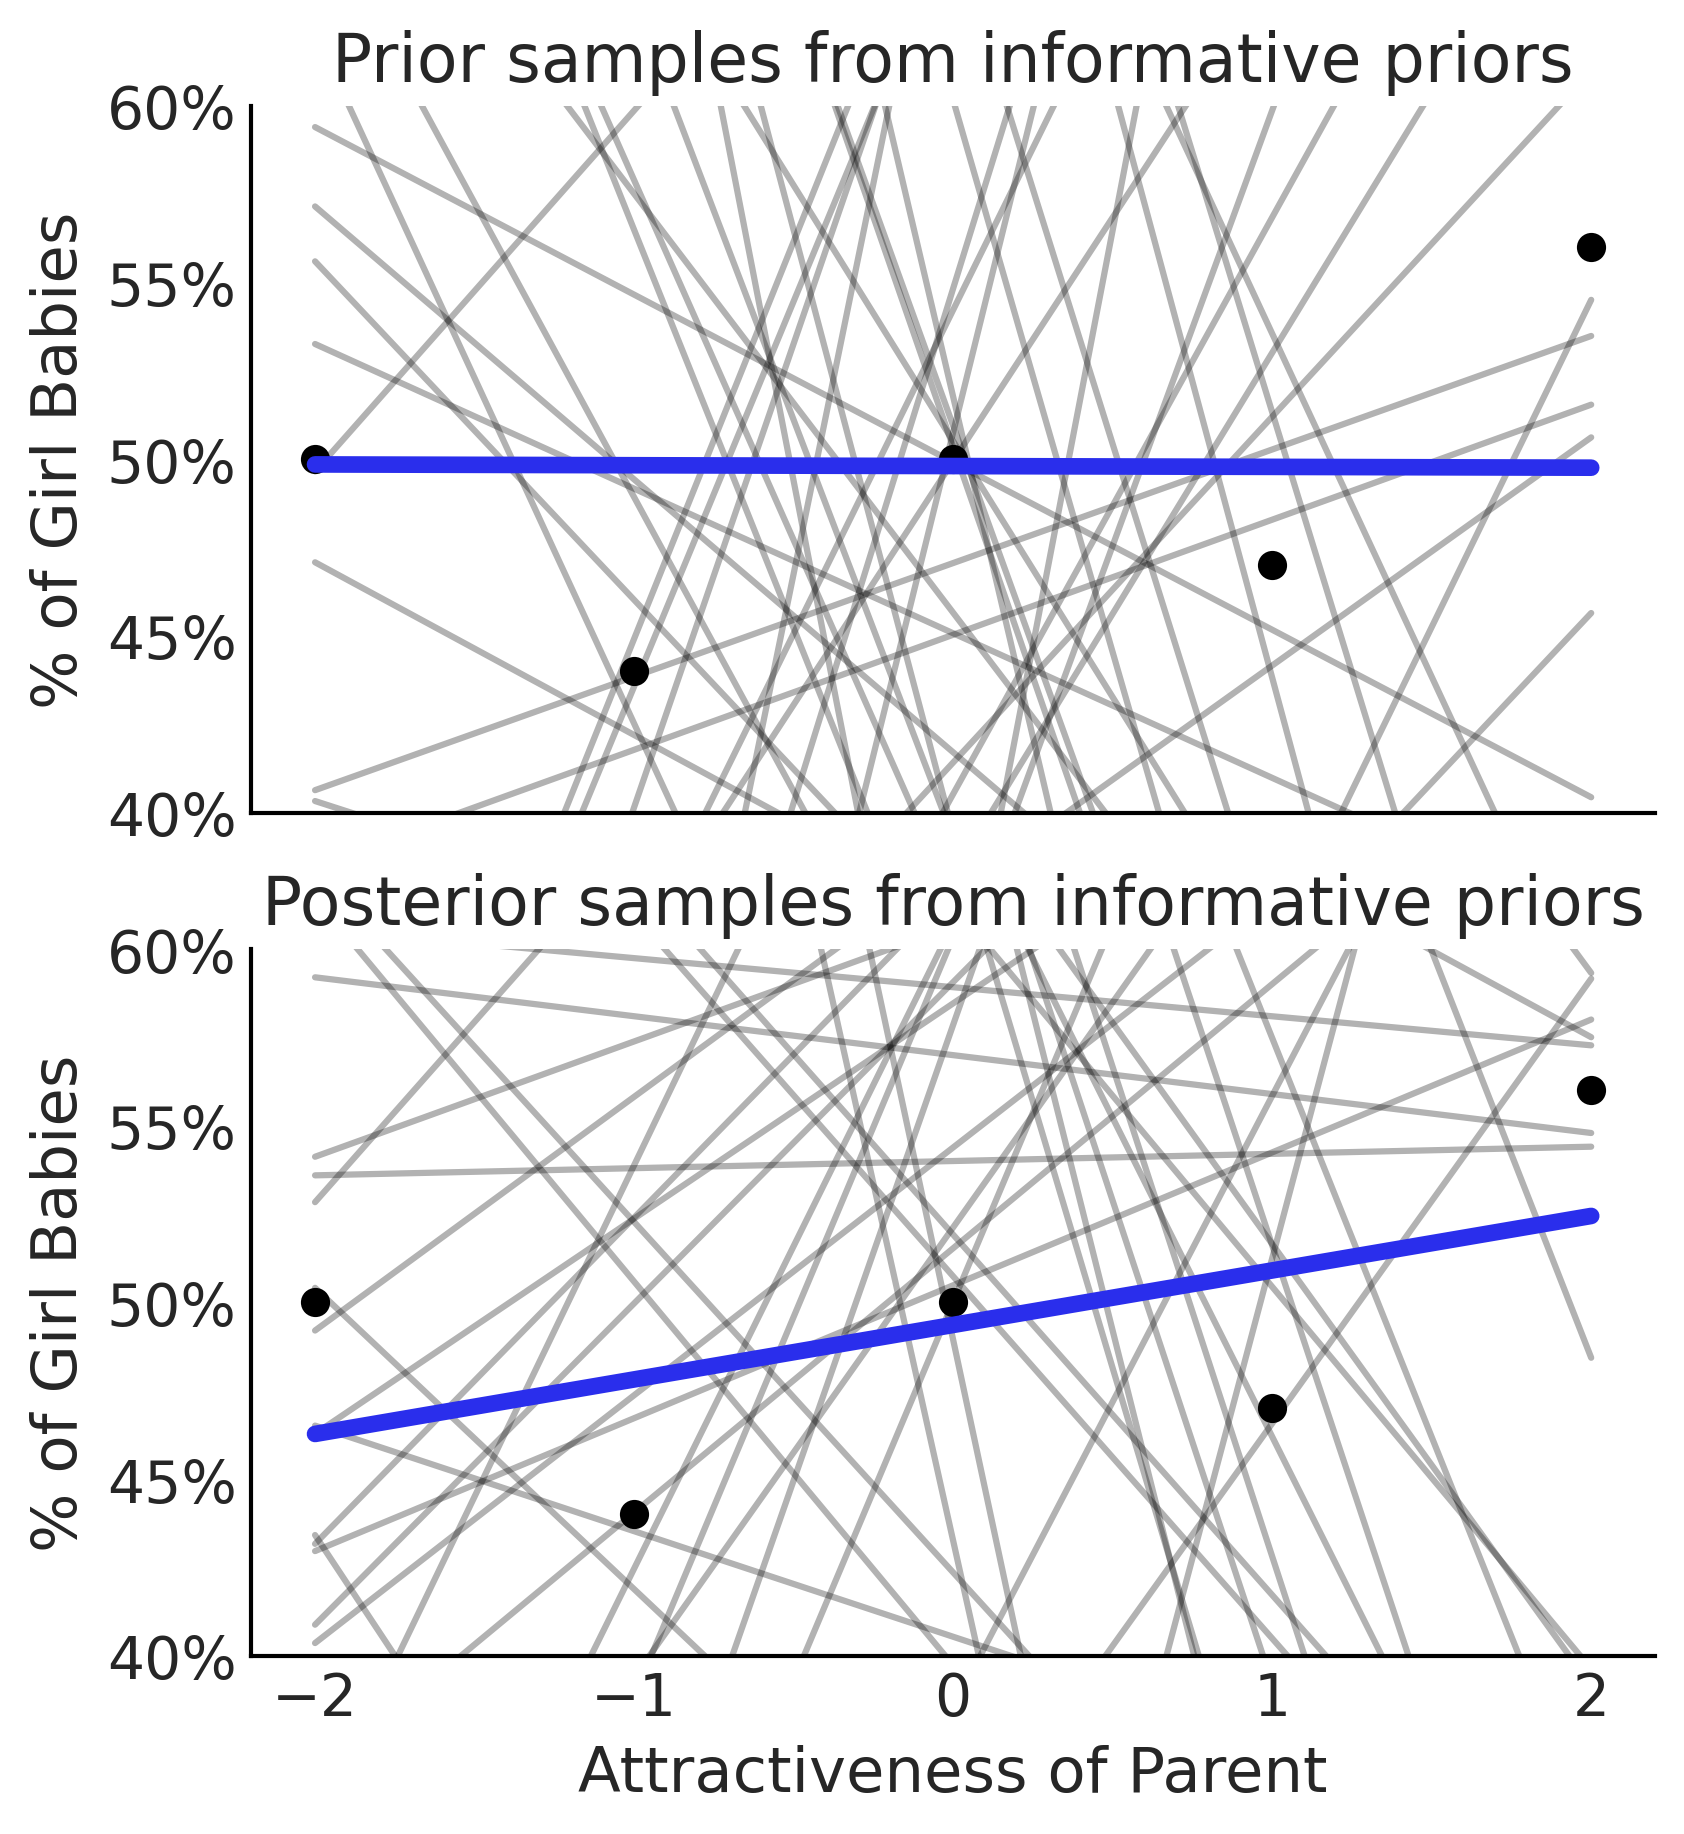

In [81]:
fig, axes = plt.subplots(2,1, figsize=(5.5, 6), sharex=True)

np.random.seed(0)
# Take 50 sample from the prior
num_samples = 50
subset = az.extract(idata_uninformative_prior_sex_ratio, group="prior", num_samples=50)

# Plot Line
axes[0].plot(x, (subset["β_0"]+subset["β_1"]*xr.DataArray(x)).T, c="black", alpha=.3)

# Add median line later
b_0_hat = idata_uninformative_prior_sex_ratio.prior["β_0"].values.mean()
b_1_hat = idata_uninformative_prior_sex_ratio.prior["β_1"].values.mean()

axes[0].plot(x, b_0_hat+b_1_hat*x, c="C4", linewidth=4)


# Add scatter plot
axes[0].scatter(x, y)
axes[0].set_xticks(x)
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
axes[0].set_ylim(40, 60)
axes[0].set_ylabel("% of Girl Babies")
axes[0].set_title("Prior samples from informative priors");


np.random.seed(0)
num_samples = 50
subset = az.extract(idata_uninformative_prior_sex_ratio, group="prior", num_samples=50)

axes[1].plot(x, (subset["β_0"]+subset["β_1"]*xr.DataArray(x)).T, c="black", alpha=.3)

# Add median line later
b_0_hat = idata_uninformative_prior_sex_ratio.posterior["β_0"].values.mean()
b_1_hat = idata_uninformative_prior_sex_ratio.posterior["β_1"].values.mean()

axes[1].plot(x, b_0_hat+b_1_hat*x, c="C4", linewidth=4)

# Add scatter plot
axes[1].scatter(x, y)
axes[1].set_xticks(x)
axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
axes[1].set_ylim(40, 60)

axes[1].set_xlabel("Attractiveness of Parent")
axes[1].set_ylabel("% of Girl Babies")
axes[1].set_title("Posterior samples from informative priors")



plt.savefig("img/chp03/posterioruninformativelinearregression.png")

Nominally we will assume births are equally split between males and
females, and that attractiveness has no effect on sex ratio. This
translates to setting the mean of the prior for intercept $\beta_0$ to
be 50 and the prior mean for the coefficient $\beta_1$ to be 0. We also
set a wide dispersion to express our lack of knowledge about both the
intercept and the effect of attractiveness on sex ratio. This is not a
fully *uninformative prior*, of which we covered in Section
{ref}`make_prior_count`, however, a very wide prior.
Given these choices we can write our model in Code Block
[uninformative_prior_sex_ratio](uninformative_prior_sex_ratio),
run inference, and generate samples to estimate posterior distribution.
From the data and model we estimate that the mean of $\beta_1$ to be
1.4, meaning the least attractive group when compared to the most
attractive group the birth ratio will differ by 7.4% on average. In
{numref}`fig:PosteriorUninformativeLinearRegression` if we include the
uncertainty, the ratio can vary by over 20% per unit of attractiveness
[^10] from a random sample of 50 possible "lines of fit\" prior to
conditioning the parameters to data.

From a mathematical lens this result is valid. But from the lens of our
general knowledge and our understanding of birth sex ratio outside of
this studies, these results are suspect. The "natural\" sex ratio at
birth has been measured to be around 105 boys per 100 girls (ranging
from around 103 to 107 boys), which means the sex ratio at birth is
48.5% female, with a standard deviation of 0.5. Moreover, even factors
that are more intrinsically tied to human biology do not affect birth
ratios to this magnitude, weakening the notion that attractiveness,
which is subjective, should have this magnitude of effect. Given this
information a change of 8% between two groups would require
extraordinary observations.

Let us run our model again but this time set more informative priors
shown in Code Block
[informative_prior_sex_ratio](informative_prior_sex_ratio)
that are consistent with this general knowledge. Plotting our posterior
samples the concentration of coefficients is smaller and the plotted
posterior lines fall into bounds that are more reasonable when considering
possible ratios.

```{code-block} python
:name: informative_prior_sex_ratio
:caption: informative_prior_sex_ratio

with pm.Model() as model_informative_prior_sex_ratio:
    σ = pm.Exponential("σ", .5)

    # Note the now more informative priors
    β_1 = pm.Normal("β_1", 0, .5)
    β_0 = pm.Normal("β_0", 48.5, .5)

    μ = pm.Deterministic("μ", β_0 + β_1 * x)
    ratio = pm.Normal("ratio", mu=μ, sigma=σ, observed=y)

    prior_predictive_informative_prior_sex_ratio = pm.sample_prior_predictive(
        samples=10000
    )
    trace_informative_prior_sex_ratio = pm.sample()
    inf_data_informative_prior_sex_ratio = az.from_pymc3(
        trace=trace_informative_prior_sex_ratio,
        prior=prior_predictive_informative_prior_sex_ratio)
```

```{figure} figures/PosteriorInformativeLinearRegression.png
:name: fig:PosteriorInformativeLinearRegression
:width: 7.00in
With priors informed from other papers and domain expertise the mean
posterior hardly changes across attractiveness ratio indicating that if
there is a belief there is an effect on birth ratio from the parents
attractiveness more data should be collected to showcase the effect.
```

[^10]: Estimate shown in corresponding notebook.

In [82]:
with pm.Model() as model_informative_prior_sex_ratio:
    σ = pm.Exponential("σ", .5)
    β_1 = pm.Normal("β_1", 0, .5)
    β_0 = pm.Normal("β_0", 48.5, .5)

    μ = pm.Deterministic("μ", β_0 + β_1 * x)

    ratio = pm.Normal("ratio", mu=μ, sigma=σ, observed=y)

    idata_informative_prior_sex_ratio = pm.sample(random_seed=0)
    idata_informative_prior_sex_ratio.extend(pm.sample_prior_predictive(samples=10000))


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β_1, β_0]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [ratio, β_0, β_1, σ]


In [83]:
az.summary(idata_informative_prior_sex_ratio, var_names=["β_0", "β_1", "σ"], kind="stats")

mean     sd  hdi_3%  hdi_97%
β_0  48.592  0.482  47.712   49.502
β_1   0.242  0.470  -0.668    1.115
σ     4.030  1.219   2.196    6.329

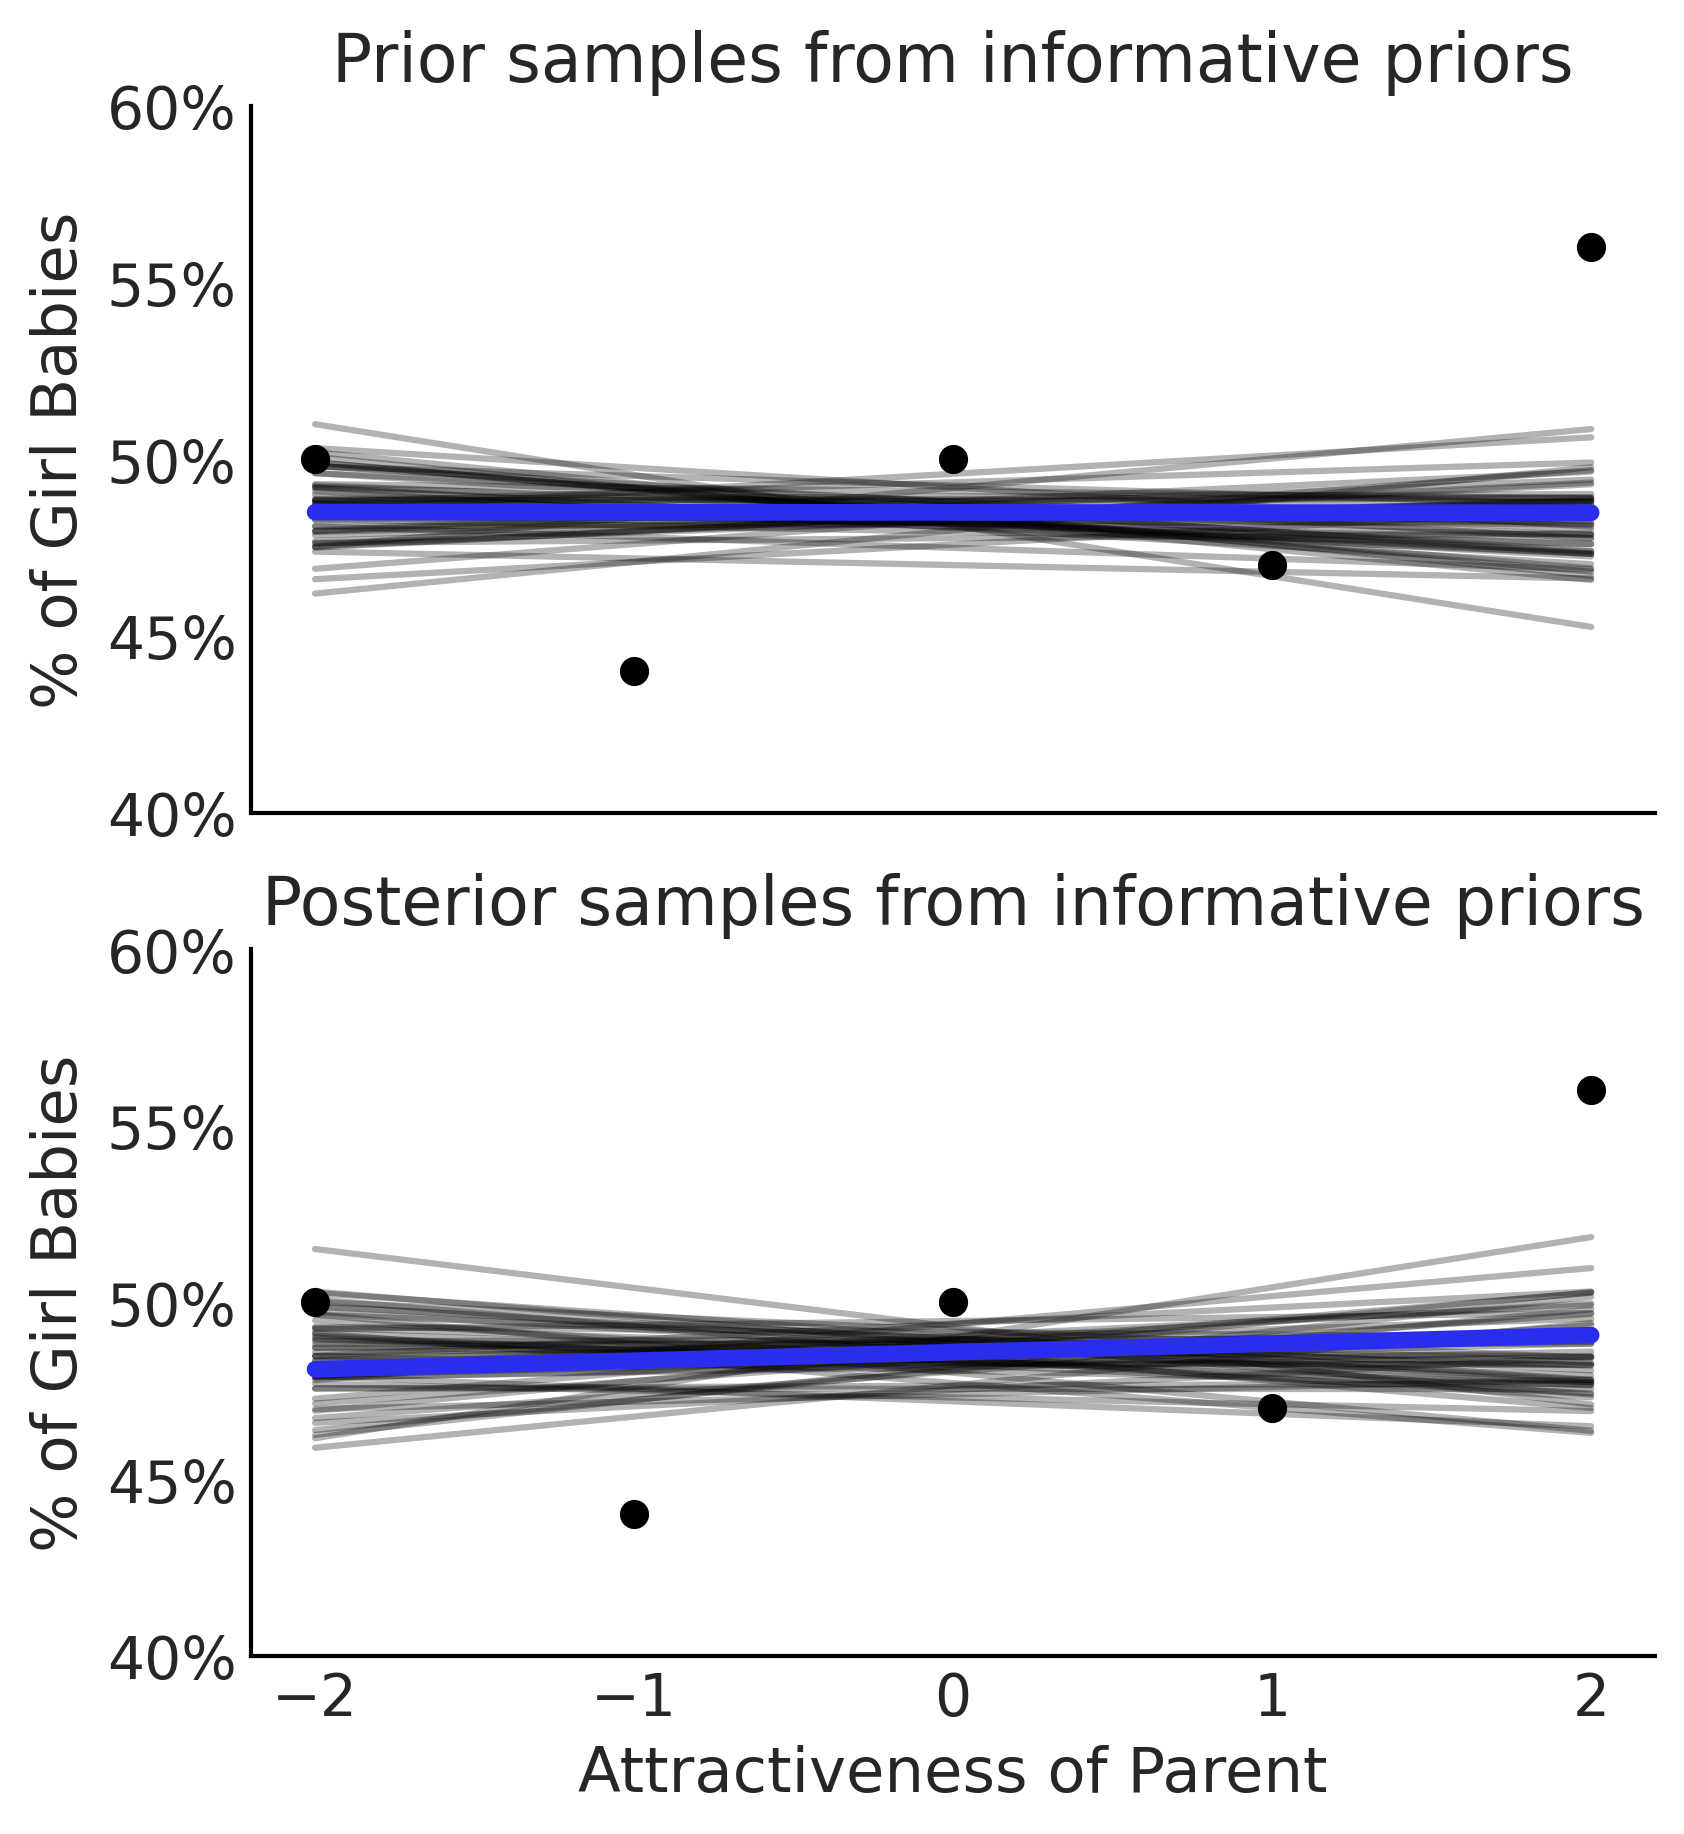

In [84]:
fig, axes = plt.subplots(2,1, figsize=(5.5, 6), sharex=True)

np.random.seed(0)
# Take 50 sample from the prior
num_samples = 50
subset = az.extract(idata_informative_prior_sex_ratio, group="prior", num_samples=50)

# Plot Line
axes[0].plot(x, (subset["β_0"]+subset["β_1"]*xr.DataArray(x)).T, c="black", alpha=.3)

# Add median line later
b_0_hat = idata_informative_prior_sex_ratio.prior["β_0"].values.mean()
b_1_hat = idata_informative_prior_sex_ratio.prior["β_1"].values.mean()

axes[0].plot(x, b_0_hat+b_1_hat*x, c="C4", linewidth=4)


# Add scatter plot
axes[0].scatter(x, y)
axes[0].set_xticks(x)
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
axes[0].set_ylim(40, 60)
axes[0].set_ylabel("% of Girl Babies")
axes[0].set_title("Prior samples from informative priors");


np.random.seed(0)
num_samples = 50
subset = az.extract(idata_informative_prior_sex_ratio, group="prior", num_samples=50)

axes[1].plot(x, (subset["β_0"]+subset["β_1"]*xr.DataArray(x)).T, c="black", alpha=.3)

# Add median line later
b_0_hat = idata_informative_prior_sex_ratio.posterior["β_0"].values.mean()
b_1_hat = idata_informative_prior_sex_ratio.posterior["β_1"].values.mean()

axes[1].plot(x, b_0_hat+b_1_hat*x, c="C4", linewidth=4)

# Add scatter plot
axes[1].scatter(x, y)
axes[1].set_xticks(x)
axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
axes[1].set_ylim(40, 60)

axes[1].set_xlabel("Attractiveness of Parent")
axes[1].set_ylabel("% of Girl Babies")
axes[1].set_title("Posterior samples from informative priors")


b_0_hat, b_1_hat
plt.savefig("img/chp03/posteriorinformativelinearregression.png")

This time we see that estimated effect of attractiveness on gender is
negligible, there simply was not enough information to affect the
posterior. As we mentioned in Section {ref}`make_prior_count`
choosing a prior is both a burden and a blessing. Regardless of which
you believe it is, it is important to use this statistical tool with an
explainable and principled choice.

(exercises3)=

## 3.6 Exercises

**E1.** Comparisons are part of everyday life. What is
something you compare on a daily basis and answer the following
question:

-   What is the numerical quantification you use for comparison?

-   How do you decide on the logical groupings for observations? For
    example in the penguin model we use species or sex

-   What point estimate would you use to compare them?


**E2.** Referring to Model
[penguin_mass](penguin_mass) complete the following tasks.

1.  Compute the values of Monte Carlo Standard Error Mean using
    `az.summary`. Given the computed values which of the following
    reported values of $\mu$ would not be well supported as a point
    estimate? 3707.235, 3707.2, or 3707.

2.  Plot the ESS and MCSE per quantiles and describe the results.

3.  Resample the model using a low number of draws until you get bad
    values of $\hat R$, and ESS

4.  Report the HDI 50% numerically and using `az.plot_posterior`


**E3.** In your own words explain how regression can be used
to do the following:

1.  Covariate estimation

2.  Prediction

3.  Counterfactual analysis

Explain how they are different, the steps to perform each, and
situations where they would be useful. Use the penguin example or come
up with your own.

**E4.** In Code Block
[flipper_centering](flipper_centering) and Code Block
[tfp_penguins_centered_predictor](tfp_penguins_centered_predictor)
we centered the flipper length covariate. Refit the model, but instead
of centering, subtract the minimum observed flipped length. Compare the
posterior estimates of the slope and intercept parameters of the
centered model. What is different, what is the same. How does the
interpretation of this model change when compared to the centered model?

**E5.** Translate the following primitives from PyMC3 to
TFP. Assume the model name is `pymc_model`

1.  `pm.StudentT("x", 0, 10, 20)`

2.  `pm.sample(chains=2)`

Hint: write the model and inference first in PyMC3, and find the similar
primitives in TFP using the code shown in this chapter.

**E6.** PyMC3 and TFP use different argument names for their
distribution parameterizations. For example in PyMC3 the Uniform
Distribution is parameterized as `pm.Uniform.dist(lower=, upper=)`
whereas in TFP it is `tfd.Uniform(low=, high=)`. Use the online
documentation to identify the difference in argument names for the
following distributions.

1.  Normal

2.  Poisson

3.  Beta

4.  Binomial

5.  Gumbel


**E7.** A common modeling technique for parameterizing
Bayesian multiple regressions is to assign a wide prior to the
intercept, and assign more informative prior to the slope coefficients.
Try modifying the `model_logistic_penguins_bill_length_mass` model in
Code Block
[model_logistic_penguins_bill_length_mass](model_logistic_penguins_bill_length_mass).
Do you get better inference results? Note that there are divergences with
the original parameterization.

**E8.** In linear regression models we have two terms. The
mean linear function and the noise term. Write down these two terms in
mathematical notation, referring to the equations in this chapter for
guidance. Explain in your own words what the purpose of these two parts
of regression are. In particular why are they useful when there is
random noise in any part of the data generating or data collection
process.

**E9.** Simulate the data using the formula y = 10 + 2x +
$\mathcal{N}(0, 5)$ with integer covariate x generated np.linspace(-10,
20, 100). Fit a linear model of the form $b_0 + b_1*X + \sigma$. Use a
Normal distribution for the likelihood and covariate priors and a Half
Student's T prior for the noise term as needed. Recover the parameters
verifying your results using both a posterior plot and a forest plot.

**E10.** Generate diagnostics for the model in Code Block
[non_centered_regression](non_centered_regression) to
verify the results shown in the chapter can be trusted. Use a
combination of visual and numerical diagnostics.

**E11.** Refit the model in Code Block
[non_centered_regression](non_centered_regression) on
Gentoo penguins and Chinstrap penguins. How are the posteriors different
from each other? How are they different from the Adelie posterior
estimation? What inferences can you make about the relationship between
flipper length and mass for these other species of penguins? What does
the change in $\sigma$ tell you about the ability of flipper length to
estimate mass?

**M12.** Using the model in Code Block
[tfp_flipper_bill_sex_counterfactuals](tfp_flipper_bill_sex_counterfactuals)
run a counterfactual analysis for female penguin flipper length with
mean flipper length and a bill length of 20mm. Plot a kernel density
estimate of the posterior predictive samples.

**M13.** Duplicate the flipper length covariate in Code
Block [non_centered_regression](non_centered_regression)
by adding a $\beta_2$ coefficient and rerun the model. What do
diagnostics such as ESS and rhat indicate about this model with a
duplicated coefficient?

**M14.** Translate the PyMC3 model in Code Block
[non_centered_regression](non_centered_regression) into
Tensorflow Probability. List three of the syntax differences.

**M15.** Translate the TFP model in Code Block
[tfp_penguins_centered_predictor](tfp_penguins_centered_predictor)
into PyMC3. List three of the syntax differences.

**M16.** Use a logistic regression with increasing number of
covariates to reproduce the prior predictive distributions in {numref}`fig:prior_predictive_check_01`.
Explain why its the case that a logistic regression with many covariates
generate a prior response with extreme values.

**H17.** Translate the PyMC3 model in Code Block
[model_logistic_penguins_bill_length_mass](model_logistic_penguins_bill_length_mass)
into TFP to classify Adelie and Chinstrap penguins. Reuse the same model
to classify Chinstrap and Gentoo penguins. Compare the coefficients, how
do they differ?

**H18.** In Code Block
[penguin_mass](penguin_mass) our model allowed for
negative values mass. Change the model so negative values are no longer
possible. Run a prior predictive check to verify that your change was
effective. Perform MCMC sampling and plot the posterior. Has the
posterior changed from the original model? Given the results why would
you choose one model over the other and why?

**H19.** The Palmer Penguin dataset includes additional data
for the observed penguins such as island and bill depth. Include these
covariates into the linear regression model defined in Code Block
[non_centered_regression](non_centered_regression) in two
parts, first adding bill depth, and then adding the island covariates.
Do these covariates help estimate Adelie mass more precisely? Justify
your answer using the parameter estimates and model comparison tools.

**H20.** Similar the exercise 2H19, see if adding bill depth
or island covariates to the penguin logistic regression help classify
Adelie and Gentoo penguins more precisely. Justify if the additional
covariates helped using the numerical and visual tools shown in this
chapter.